First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
# url = 'https://http://yaroslavvb.com/upload/notMNIST/'
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz


URLError: <urlopen error [Errno 11001] getaddrinfo failed>

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [11]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./ already present - Skipping extraction of ./.


Exception: Expected 10 folders, one per class. Found 3 instead.

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [15]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    print(folder,data_folders)
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

def load_folders(root):
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    return data_folders

train_datasets = maybe_pickle(load_folders("notMNIST_large"), 45000)
test_datasets = maybe_pickle(load_folders("notMNIST_small"), 1800)

notMNIST_large\A ['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B ['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C ['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D ['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

['notMNIST_small\\A.pickle', 'notMNIST_small\\B.pickle', 'notMNIST_small\\C.pickle', 'notMNIST_small\\D.pickle', 'notMNIST_small\\E.pickle', 'notMNIST_small\\F.pickle', 'notMNIST_small\\G.pickle', 'notMNIST_small\\H.pickle', 'notMNIST_small\\I.pickle', 'notMNIST_small\\J.pickle']
<class 'numpy.ndarray'>


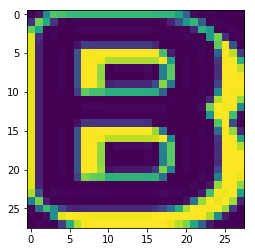

In [22]:
import matplotlib.pyplot as plt

print(test_datasets)
with open(test_datasets[1], 'rb') as f:
    B_pickle = pickle.load(f)
    print(type(B_pickle))
    plt.imshow(B_pickle[7,:,:])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [34]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 400000
valid_size = 20000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (400000, 28, 28) (400000,)
Validation: (20000, 28, 28) (20000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [35]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

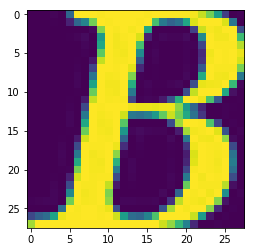

In [37]:
plt.imshow(train_dataset[7,:,:])

Finally, let's save the data for later reuse:

In [38]:
pickle_file = os.path.join('.', 'notMNIST.pickle')
# pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [39]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1350200515


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
print('train_dataset:',len(train_dataset),'test_dataset:',len(test_dataset))
overlap_num = 0
#遍历数据，判断两个图像是否相同
for train_data in train_dataset:
    for test_data in test_dataset:
        if (test_data==train_data).all()==True:
            overlap_num +=1

print('overlap: ',overlap_num)

overlap:  1
overlap:  2
overlap:  3
overlap:  4
overlap:  5
overlap:  6
overlap:  7
overlap:  8
overlap:  9
overlap:  10
overlap:  11
overlap:  12
overlap:  13
overlap:  14
overlap:  15
overlap:  16
overlap:  17
overlap:  18
overlap:  19
overlap:  20
overlap:  21
overlap:  22
overlap:  23
overlap:  24
overlap:  25
overlap:  26
overlap:  27
overlap:  28
overlap:  29
overlap:  30
overlap:  31
overlap:  32
overlap:  33
overlap:  34
overlap:  35
overlap:  36
overlap:  37
overlap:  38
overlap:  39
overlap:  40
overlap:  41
overlap:  42
overlap:  43
overlap:  44
overlap:  45
overlap:  46
overlap:  47
overlap:  48
overlap:  49
overlap:  50
overlap:  51
overlap:  52
overlap:  53
overlap:  54
overlap:  55
overlap:  56
overlap:  57
overlap:  58
overlap:  59
overlap:  60
overlap:  61
overlap:  62
overlap:  63
overlap:  64
overlap:  65
overlap:  66
overlap:  67
overlap:  68
overlap:  69
overlap:  70
overlap:  71
overlap:  72
overlap:  73
overlap:  74
overlap:  75
overlap:  76
overlap:  77
overlap:

overlap:  627
overlap:  628
overlap:  629
overlap:  630
overlap:  631
overlap:  632
overlap:  633
overlap:  634
overlap:  635
overlap:  636
overlap:  637
overlap:  638
overlap:  639
overlap:  640
overlap:  641
overlap:  642
overlap:  643
overlap:  644
overlap:  645
overlap:  646
overlap:  647
overlap:  648
overlap:  649
overlap:  650
overlap:  651
overlap:  652
overlap:  653
overlap:  654
overlap:  655
overlap:  656
overlap:  657
overlap:  658
overlap:  659
overlap:  660
overlap:  661
overlap:  662
overlap:  663
overlap:  664
overlap:  665
overlap:  666
overlap:  667
overlap:  668
overlap:  669
overlap:  670
overlap:  671
overlap:  672
overlap:  673
overlap:  674
overlap:  675
overlap:  676
overlap:  677
overlap:  678
overlap:  679
overlap:  680
overlap:  681
overlap:  682
overlap:  683
overlap:  684
overlap:  685
overlap:  686
overlap:  687
overlap:  688
overlap:  689
overlap:  690
overlap:  691
overlap:  692
overlap:  693
overlap:  694
overlap:  695
overlap:  696
overlap:  697
overla

overlap:  1258
overlap:  1259
overlap:  1260
overlap:  1261
overlap:  1262
overlap:  1263
overlap:  1264
overlap:  1265
overlap:  1266
overlap:  1267
overlap:  1268
overlap:  1269
overlap:  1270
overlap:  1271
overlap:  1272
overlap:  1273
overlap:  1274
overlap:  1275
overlap:  1276
overlap:  1277
overlap:  1278
overlap:  1279
overlap:  1280
overlap:  1281
overlap:  1282
overlap:  1283
overlap:  1284
overlap:  1285
overlap:  1286
overlap:  1287
overlap:  1288
overlap:  1289
overlap:  1290
overlap:  1291
overlap:  1292
overlap:  1293
overlap:  1294
overlap:  1295
overlap:  1296
overlap:  1297
overlap:  1298
overlap:  1299
overlap:  1300
overlap:  1301
overlap:  1302
overlap:  1303
overlap:  1304
overlap:  1305
overlap:  1306
overlap:  1307
overlap:  1308
overlap:  1309
overlap:  1310
overlap:  1311
overlap:  1312
overlap:  1313
overlap:  1314
overlap:  1315
overlap:  1316
overlap:  1317
overlap:  1318
overlap:  1319
overlap:  1320
overlap:  1321
overlap:  1322
overlap:  1323
overlap:  

overlap:  1884
overlap:  1885
overlap:  1886
overlap:  1887
overlap:  1888
overlap:  1889
overlap:  1890
overlap:  1891
overlap:  1892
overlap:  1893
overlap:  1894
overlap:  1895
overlap:  1896
overlap:  1897
overlap:  1898
overlap:  1899
overlap:  1900
overlap:  1901
overlap:  1902
overlap:  1903
overlap:  1904
overlap:  1905
overlap:  1906
overlap:  1907
overlap:  1908
overlap:  1909
overlap:  1910
overlap:  1911
overlap:  1912
overlap:  1913
overlap:  1914
overlap:  1915
overlap:  1916
overlap:  1917
overlap:  1918
overlap:  1919
overlap:  1920
overlap:  1921
overlap:  1922
overlap:  1923
overlap:  1924
overlap:  1925
overlap:  1926
overlap:  1927
overlap:  1928
overlap:  1929
overlap:  1930
overlap:  1931
overlap:  1932
overlap:  1933
overlap:  1934
overlap:  1935
overlap:  1936
overlap:  1937
overlap:  1938
overlap:  1939
overlap:  1940
overlap:  1941
overlap:  1942
overlap:  1943
overlap:  1944
overlap:  1945
overlap:  1946
overlap:  1947
overlap:  1948
overlap:  1949
overlap:  

overlap:  2514
overlap:  2515
overlap:  2516
overlap:  2517
overlap:  2518
overlap:  2519
overlap:  2520
overlap:  2521
overlap:  2522
overlap:  2523
overlap:  2524
overlap:  2525
overlap:  2526
overlap:  2527
overlap:  2528
overlap:  2529
overlap:  2530
overlap:  2531
overlap:  2532
overlap:  2533
overlap:  2534
overlap:  2535
overlap:  2536
overlap:  2537
overlap:  2538
overlap:  2539
overlap:  2540
overlap:  2541
overlap:  2542
overlap:  2543
overlap:  2544
overlap:  2545
overlap:  2546
overlap:  2547
overlap:  2548
overlap:  2549
overlap:  2550
overlap:  2551
overlap:  2552
overlap:  2553
overlap:  2554
overlap:  2555
overlap:  2556
overlap:  2557
overlap:  2558
overlap:  2559
overlap:  2560
overlap:  2561
overlap:  2562
overlap:  2563
overlap:  2564
overlap:  2565
overlap:  2566
overlap:  2567
overlap:  2568
overlap:  2569
overlap:  2570
overlap:  2571
overlap:  2572
overlap:  2573
overlap:  2574
overlap:  2575
overlap:  2576
overlap:  2577
overlap:  2578
overlap:  2579
overlap:  

overlap:  3143
overlap:  3144
overlap:  3145
overlap:  3146
overlap:  3147
overlap:  3148
overlap:  3149
overlap:  3150
overlap:  3151
overlap:  3152
overlap:  3153
overlap:  3154
overlap:  3155
overlap:  3156
overlap:  3157
overlap:  3158
overlap:  3159
overlap:  3160
overlap:  3161
overlap:  3162
overlap:  3163
overlap:  3164
overlap:  3165
overlap:  3166
overlap:  3167
overlap:  3168
overlap:  3169
overlap:  3170
overlap:  3171
overlap:  3172
overlap:  3173
overlap:  3174
overlap:  3175
overlap:  3176
overlap:  3177
overlap:  3178
overlap:  3179
overlap:  3180
overlap:  3181
overlap:  3182
overlap:  3183
overlap:  3184
overlap:  3185
overlap:  3186
overlap:  3187
overlap:  3188
overlap:  3189
overlap:  3190
overlap:  3191
overlap:  3192
overlap:  3193
overlap:  3194
overlap:  3195
overlap:  3196
overlap:  3197
overlap:  3198
overlap:  3199
overlap:  3200
overlap:  3201
overlap:  3202
overlap:  3203
overlap:  3204
overlap:  3205
overlap:  3206
overlap:  3207
overlap:  3208
overlap:  

overlap:  3774
overlap:  3775
overlap:  3776
overlap:  3777
overlap:  3778
overlap:  3779
overlap:  3780
overlap:  3781
overlap:  3782
overlap:  3783
overlap:  3784
overlap:  3785
overlap:  3786
overlap:  3787
overlap:  3788
overlap:  3789
overlap:  3790
overlap:  3791
overlap:  3792
overlap:  3793
overlap:  3794
overlap:  3795
overlap:  3796
overlap:  3797
overlap:  3798
overlap:  3799
overlap:  3800
overlap:  3801
overlap:  3802
overlap:  3803
overlap:  3804
overlap:  3805
overlap:  3806
overlap:  3807
overlap:  3808
overlap:  3809
overlap:  3810
overlap:  3811
overlap:  3812
overlap:  3813
overlap:  3814
overlap:  3815
overlap:  3816
overlap:  3817
overlap:  3818
overlap:  3819
overlap:  3820
overlap:  3821
overlap:  3822
overlap:  3823
overlap:  3824
overlap:  3825
overlap:  3826
overlap:  3827
overlap:  3828
overlap:  3829
overlap:  3830
overlap:  3831
overlap:  3832
overlap:  3833
overlap:  3834
overlap:  3835
overlap:  3836
overlap:  3837
overlap:  3838
overlap:  3839
overlap:  

overlap:  4401
overlap:  4402
overlap:  4403
overlap:  4404
overlap:  4405
overlap:  4406
overlap:  4407
overlap:  4408
overlap:  4409
overlap:  4410
overlap:  4411
overlap:  4412
overlap:  4413
overlap:  4414
overlap:  4415
overlap:  4416
overlap:  4417
overlap:  4418
overlap:  4419
overlap:  4420
overlap:  4421
overlap:  4422
overlap:  4423
overlap:  4424
overlap:  4425
overlap:  4426
overlap:  4427
overlap:  4428
overlap:  4429
overlap:  4430
overlap:  4431
overlap:  4432
overlap:  4433
overlap:  4434
overlap:  4435
overlap:  4436
overlap:  4437
overlap:  4438
overlap:  4439
overlap:  4440
overlap:  4441
overlap:  4442
overlap:  4443
overlap:  4444
overlap:  4445
overlap:  4446
overlap:  4447
overlap:  4448
overlap:  4449
overlap:  4450
overlap:  4451
overlap:  4452
overlap:  4453
overlap:  4454
overlap:  4455
overlap:  4456
overlap:  4457
overlap:  4458
overlap:  4459
overlap:  4460
overlap:  4461
overlap:  4462
overlap:  4463
overlap:  4464
overlap:  4465
overlap:  4466
overlap:  

overlap:  5029
overlap:  5030
overlap:  5031
overlap:  5032
overlap:  5033
overlap:  5034
overlap:  5035
overlap:  5036
overlap:  5037
overlap:  5038
overlap:  5039
overlap:  5040
overlap:  5041
overlap:  5042
overlap:  5043
overlap:  5044
overlap:  5045
overlap:  5046
overlap:  5047
overlap:  5048
overlap:  5049
overlap:  5050
overlap:  5051
overlap:  5052
overlap:  5053
overlap:  5054
overlap:  5055
overlap:  5056
overlap:  5057
overlap:  5058
overlap:  5059
overlap:  5060
overlap:  5061
overlap:  5062
overlap:  5063
overlap:  5064
overlap:  5065
overlap:  5066
overlap:  5067
overlap:  5068
overlap:  5069
overlap:  5070
overlap:  5071
overlap:  5072
overlap:  5073
overlap:  5074
overlap:  5075
overlap:  5076
overlap:  5077
overlap:  5078
overlap:  5079
overlap:  5080
overlap:  5081
overlap:  5082
overlap:  5083
overlap:  5084
overlap:  5085
overlap:  5086
overlap:  5087
overlap:  5088
overlap:  5089
overlap:  5090
overlap:  5091
overlap:  5092
overlap:  5093
overlap:  5094
overlap:  

overlap:  5657
overlap:  5658
overlap:  5659
overlap:  5660
overlap:  5661
overlap:  5662
overlap:  5663
overlap:  5664
overlap:  5665
overlap:  5666
overlap:  5667
overlap:  5668
overlap:  5669
overlap:  5670
overlap:  5671
overlap:  5672
overlap:  5673
overlap:  5674
overlap:  5675
overlap:  5676
overlap:  5677
overlap:  5678
overlap:  5679
overlap:  5680
overlap:  5681
overlap:  5682
overlap:  5683
overlap:  5684
overlap:  5685
overlap:  5686
overlap:  5687
overlap:  5688
overlap:  5689
overlap:  5690
overlap:  5691
overlap:  5692
overlap:  5693
overlap:  5694
overlap:  5695
overlap:  5696
overlap:  5697
overlap:  5698
overlap:  5699
overlap:  5700
overlap:  5701
overlap:  5702
overlap:  5703
overlap:  5704
overlap:  5705
overlap:  5706
overlap:  5707
overlap:  5708
overlap:  5709
overlap:  5710
overlap:  5711
overlap:  5712
overlap:  5713
overlap:  5714
overlap:  5715
overlap:  5716
overlap:  5717
overlap:  5718
overlap:  5719
overlap:  5720
overlap:  5721
overlap:  5722
overlap:  

overlap:  6285
overlap:  6286
overlap:  6287
overlap:  6288
overlap:  6289
overlap:  6290
overlap:  6291
overlap:  6292
overlap:  6293
overlap:  6294
overlap:  6295
overlap:  6296
overlap:  6297
overlap:  6298
overlap:  6299
overlap:  6300
overlap:  6301
overlap:  6302
overlap:  6303
overlap:  6304
overlap:  6305
overlap:  6306
overlap:  6307
overlap:  6308
overlap:  6309
overlap:  6310
overlap:  6311
overlap:  6312
overlap:  6313
overlap:  6314
overlap:  6315
overlap:  6316
overlap:  6317
overlap:  6318
overlap:  6319
overlap:  6320
overlap:  6321
overlap:  6322
overlap:  6323
overlap:  6324
overlap:  6325
overlap:  6326
overlap:  6327
overlap:  6328
overlap:  6329
overlap:  6330
overlap:  6331
overlap:  6332
overlap:  6333
overlap:  6334
overlap:  6335
overlap:  6336
overlap:  6337
overlap:  6338
overlap:  6339
overlap:  6340
overlap:  6341
overlap:  6342
overlap:  6343
overlap:  6344
overlap:  6345
overlap:  6346
overlap:  6347
overlap:  6348
overlap:  6349
overlap:  6350
overlap:  

overlap:  6918
overlap:  6919
overlap:  6920
overlap:  6921
overlap:  6922
overlap:  6923
overlap:  6924
overlap:  6925
overlap:  6926
overlap:  6927
overlap:  6928
overlap:  6929
overlap:  6930
overlap:  6931
overlap:  6932
overlap:  6933
overlap:  6934
overlap:  6935
overlap:  6936
overlap:  6937
overlap:  6938
overlap:  6939
overlap:  6940
overlap:  6941
overlap:  6942
overlap:  6943
overlap:  6944
overlap:  6945
overlap:  6946
overlap:  6947
overlap:  6948
overlap:  6949
overlap:  6950
overlap:  6951
overlap:  6952
overlap:  6953
overlap:  6954
overlap:  6955
overlap:  6956
overlap:  6957
overlap:  6958
overlap:  6959
overlap:  6960
overlap:  6961
overlap:  6962
overlap:  6963
overlap:  6964
overlap:  6965
overlap:  6966
overlap:  6967
overlap:  6968
overlap:  6969
overlap:  6970
overlap:  6971
overlap:  6972
overlap:  6973
overlap:  6974
overlap:  6975
overlap:  6976
overlap:  6977
overlap:  6978
overlap:  6979
overlap:  6980
overlap:  6981
overlap:  6982
overlap:  6983
overlap:  

overlap:  7545
overlap:  7546
overlap:  7547
overlap:  7548
overlap:  7549
overlap:  7550
overlap:  7551
overlap:  7552
overlap:  7553
overlap:  7554
overlap:  7555
overlap:  7556
overlap:  7557
overlap:  7558
overlap:  7559
overlap:  7560
overlap:  7561
overlap:  7562
overlap:  7563
overlap:  7564
overlap:  7565
overlap:  7566
overlap:  7567
overlap:  7568
overlap:  7569
overlap:  7570
overlap:  7571
overlap:  7572
overlap:  7573
overlap:  7574
overlap:  7575
overlap:  7576
overlap:  7577
overlap:  7578
overlap:  7579
overlap:  7580
overlap:  7581
overlap:  7582
overlap:  7583
overlap:  7584
overlap:  7585
overlap:  7586
overlap:  7587
overlap:  7588
overlap:  7589
overlap:  7590
overlap:  7591
overlap:  7592
overlap:  7593
overlap:  7594
overlap:  7595
overlap:  7596
overlap:  7597
overlap:  7598
overlap:  7599
overlap:  7600
overlap:  7601
overlap:  7602
overlap:  7603
overlap:  7604
overlap:  7605
overlap:  7606
overlap:  7607
overlap:  7608
overlap:  7609
overlap:  7610
overlap:  

overlap:  8172
overlap:  8173
overlap:  8174
overlap:  8175
overlap:  8176
overlap:  8177
overlap:  8178
overlap:  8179
overlap:  8180
overlap:  8181
overlap:  8182
overlap:  8183
overlap:  8184
overlap:  8185
overlap:  8186
overlap:  8187
overlap:  8188
overlap:  8189
overlap:  8190
overlap:  8191
overlap:  8192
overlap:  8193
overlap:  8194
overlap:  8195
overlap:  8196
overlap:  8197
overlap:  8198
overlap:  8199
overlap:  8200
overlap:  8201
overlap:  8202
overlap:  8203
overlap:  8204
overlap:  8205
overlap:  8206
overlap:  8207
overlap:  8208
overlap:  8209
overlap:  8210
overlap:  8211
overlap:  8212
overlap:  8213
overlap:  8214
overlap:  8215
overlap:  8216
overlap:  8217
overlap:  8218
overlap:  8219
overlap:  8220
overlap:  8221
overlap:  8222
overlap:  8223
overlap:  8224
overlap:  8225
overlap:  8226
overlap:  8227
overlap:  8228
overlap:  8229
overlap:  8230
overlap:  8231
overlap:  8232
overlap:  8233
overlap:  8234
overlap:  8235
overlap:  8236
overlap:  8237
overlap:  

overlap:  8799
overlap:  8800
overlap:  8801
overlap:  8802
overlap:  8803
overlap:  8804
overlap:  8805
overlap:  8806
overlap:  8807
overlap:  8808
overlap:  8809
overlap:  8810
overlap:  8811
overlap:  8812
overlap:  8813
overlap:  8814
overlap:  8815
overlap:  8816
overlap:  8817
overlap:  8818
overlap:  8819
overlap:  8820
overlap:  8821
overlap:  8822
overlap:  8823
overlap:  8824
overlap:  8825
overlap:  8826
overlap:  8827
overlap:  8828
overlap:  8829
overlap:  8830
overlap:  8831
overlap:  8832
overlap:  8833
overlap:  8834
overlap:  8835
overlap:  8836
overlap:  8837
overlap:  8838
overlap:  8839
overlap:  8840
overlap:  8841
overlap:  8842
overlap:  8843
overlap:  8844
overlap:  8845
overlap:  8846
overlap:  8847
overlap:  8848
overlap:  8849
overlap:  8850
overlap:  8851
overlap:  8852
overlap:  8853
overlap:  8854
overlap:  8855
overlap:  8856
overlap:  8857
overlap:  8858
overlap:  8859
overlap:  8860
overlap:  8861
overlap:  8862
overlap:  8863
overlap:  8864
overlap:  

overlap:  9428
overlap:  9429
overlap:  9430
overlap:  9431
overlap:  9432
overlap:  9433
overlap:  9434
overlap:  9435
overlap:  9436
overlap:  9437
overlap:  9438
overlap:  9439
overlap:  9440
overlap:  9441
overlap:  9442
overlap:  9443
overlap:  9444
overlap:  9445
overlap:  9446
overlap:  9447
overlap:  9448
overlap:  9449
overlap:  9450
overlap:  9451
overlap:  9452
overlap:  9453
overlap:  9454
overlap:  9455
overlap:  9456
overlap:  9457
overlap:  9458
overlap:  9459
overlap:  9460
overlap:  9461
overlap:  9462
overlap:  9463
overlap:  9464
overlap:  9465
overlap:  9466
overlap:  9467
overlap:  9468
overlap:  9469
overlap:  9470
overlap:  9471
overlap:  9472
overlap:  9473
overlap:  9474
overlap:  9475
overlap:  9476
overlap:  9477
overlap:  9478
overlap:  9479
overlap:  9480
overlap:  9481
overlap:  9482
overlap:  9483
overlap:  9484
overlap:  9485
overlap:  9486
overlap:  9487
overlap:  9488
overlap:  9489
overlap:  9490
overlap:  9491
overlap:  9492
overlap:  9493
overlap:  

overlap:  10063
overlap:  10064
overlap:  10065
overlap:  10066
overlap:  10067
overlap:  10068
overlap:  10069
overlap:  10070
overlap:  10071
overlap:  10072
overlap:  10073
overlap:  10074
overlap:  10075
overlap:  10076
overlap:  10077
overlap:  10078
overlap:  10079
overlap:  10080
overlap:  10081
overlap:  10082
overlap:  10083
overlap:  10084
overlap:  10085
overlap:  10086
overlap:  10087
overlap:  10088
overlap:  10089
overlap:  10090
overlap:  10091
overlap:  10092
overlap:  10093
overlap:  10094
overlap:  10095
overlap:  10096
overlap:  10097
overlap:  10098
overlap:  10099
overlap:  10100
overlap:  10101
overlap:  10102
overlap:  10103
overlap:  10104
overlap:  10105
overlap:  10106
overlap:  10107
overlap:  10108
overlap:  10109
overlap:  10110
overlap:  10111
overlap:  10112
overlap:  10113
overlap:  10114
overlap:  10115
overlap:  10116
overlap:  10117
overlap:  10118
overlap:  10119
overlap:  10120
overlap:  10121
overlap:  10122
overlap:  10123
overlap:  10124
overlap:

overlap:  10692
overlap:  10693
overlap:  10694
overlap:  10695
overlap:  10696
overlap:  10697
overlap:  10698
overlap:  10699
overlap:  10700
overlap:  10701
overlap:  10702
overlap:  10703
overlap:  10704
overlap:  10705
overlap:  10706
overlap:  10707
overlap:  10708
overlap:  10709
overlap:  10710
overlap:  10711
overlap:  10712
overlap:  10713
overlap:  10714
overlap:  10715
overlap:  10716
overlap:  10717
overlap:  10718
overlap:  10719
overlap:  10720
overlap:  10721
overlap:  10722
overlap:  10723
overlap:  10724
overlap:  10725
overlap:  10726
overlap:  10727
overlap:  10728
overlap:  10729
overlap:  10730
overlap:  10731
overlap:  10732
overlap:  10733
overlap:  10734
overlap:  10735
overlap:  10736
overlap:  10737
overlap:  10738
overlap:  10739
overlap:  10740
overlap:  10741
overlap:  10742
overlap:  10743
overlap:  10744
overlap:  10745
overlap:  10746
overlap:  10747
overlap:  10748
overlap:  10749
overlap:  10750
overlap:  10751
overlap:  10752
overlap:  10753
overlap:

overlap:  11321
overlap:  11322
overlap:  11323
overlap:  11324
overlap:  11325
overlap:  11326
overlap:  11327
overlap:  11328
overlap:  11329
overlap:  11330
overlap:  11331
overlap:  11332
overlap:  11333
overlap:  11334
overlap:  11335
overlap:  11336
overlap:  11337
overlap:  11338
overlap:  11339
overlap:  11340
overlap:  11341
overlap:  11342
overlap:  11343
overlap:  11344
overlap:  11345
overlap:  11346
overlap:  11347
overlap:  11348
overlap:  11349
overlap:  11350
overlap:  11351
overlap:  11352
overlap:  11353
overlap:  11354
overlap:  11355
overlap:  11356
overlap:  11357
overlap:  11358
overlap:  11359
overlap:  11360
overlap:  11361
overlap:  11362
overlap:  11363
overlap:  11364
overlap:  11365
overlap:  11366
overlap:  11367
overlap:  11368
overlap:  11369
overlap:  11370
overlap:  11371
overlap:  11372
overlap:  11373
overlap:  11374
overlap:  11375
overlap:  11376
overlap:  11377
overlap:  11378
overlap:  11379
overlap:  11380
overlap:  11381
overlap:  11382
overlap:

overlap:  11949
overlap:  11950
overlap:  11951
overlap:  11952
overlap:  11953
overlap:  11954
overlap:  11955
overlap:  11956
overlap:  11957
overlap:  11958
overlap:  11959
overlap:  11960
overlap:  11961
overlap:  11962
overlap:  11963
overlap:  11964
overlap:  11965
overlap:  11966
overlap:  11967
overlap:  11968
overlap:  11969
overlap:  11970
overlap:  11971
overlap:  11972
overlap:  11973
overlap:  11974
overlap:  11975
overlap:  11976
overlap:  11977
overlap:  11978
overlap:  11979
overlap:  11980
overlap:  11981
overlap:  11982
overlap:  11983
overlap:  11984
overlap:  11985
overlap:  11986
overlap:  11987
overlap:  11988
overlap:  11989
overlap:  11990
overlap:  11991
overlap:  11992
overlap:  11993
overlap:  11994
overlap:  11995
overlap:  11996
overlap:  11997
overlap:  11998
overlap:  11999
overlap:  12000
overlap:  12001
overlap:  12002
overlap:  12003
overlap:  12004
overlap:  12005
overlap:  12006
overlap:  12007
overlap:  12008
overlap:  12009
overlap:  12010
overlap:

overlap:  12578
overlap:  12579
overlap:  12580
overlap:  12581
overlap:  12582
overlap:  12583
overlap:  12584
overlap:  12585
overlap:  12586
overlap:  12587
overlap:  12588
overlap:  12589
overlap:  12590
overlap:  12591
overlap:  12592
overlap:  12593
overlap:  12594
overlap:  12595
overlap:  12596
overlap:  12597
overlap:  12598
overlap:  12599
overlap:  12600
overlap:  12601
overlap:  12602
overlap:  12603
overlap:  12604
overlap:  12605
overlap:  12606
overlap:  12607
overlap:  12608
overlap:  12609
overlap:  12610
overlap:  12611
overlap:  12612
overlap:  12613
overlap:  12614
overlap:  12615
overlap:  12616
overlap:  12617
overlap:  12618
overlap:  12619
overlap:  12620
overlap:  12621
overlap:  12622
overlap:  12623
overlap:  12624
overlap:  12625
overlap:  12626
overlap:  12627
overlap:  12628
overlap:  12629
overlap:  12630
overlap:  12631
overlap:  12632
overlap:  12633
overlap:  12634
overlap:  12635
overlap:  12636
overlap:  12637
overlap:  12638
overlap:  12639
overlap:

overlap:  13207
overlap:  13208
overlap:  13209
overlap:  13210
overlap:  13211
overlap:  13212
overlap:  13213
overlap:  13214
overlap:  13215
overlap:  13216
overlap:  13217
overlap:  13218
overlap:  13219
overlap:  13220
overlap:  13221
overlap:  13222
overlap:  13223
overlap:  13224
overlap:  13225
overlap:  13226
overlap:  13227
overlap:  13228
overlap:  13229
overlap:  13230
overlap:  13231
overlap:  13232
overlap:  13233
overlap:  13234
overlap:  13235
overlap:  13236
overlap:  13237
overlap:  13238
overlap:  13239
overlap:  13240
overlap:  13241
overlap:  13242
overlap:  13243
overlap:  13244
overlap:  13245
overlap:  13246
overlap:  13247
overlap:  13248
overlap:  13249
overlap:  13250
overlap:  13251
overlap:  13252
overlap:  13253
overlap:  13254
overlap:  13255
overlap:  13256
overlap:  13257
overlap:  13258
overlap:  13259
overlap:  13260
overlap:  13261
overlap:  13262
overlap:  13263
overlap:  13264
overlap:  13265
overlap:  13266
overlap:  13267
overlap:  13268
overlap:

overlap:  13834
overlap:  13835
overlap:  13836
overlap:  13837
overlap:  13838
overlap:  13839
overlap:  13840
overlap:  13841
overlap:  13842
overlap:  13843
overlap:  13844
overlap:  13845
overlap:  13846
overlap:  13847
overlap:  13848
overlap:  13849
overlap:  13850
overlap:  13851
overlap:  13852
overlap:  13853
overlap:  13854
overlap:  13855
overlap:  13856
overlap:  13857
overlap:  13858
overlap:  13859
overlap:  13860
overlap:  13861
overlap:  13862
overlap:  13863
overlap:  13864
overlap:  13865
overlap:  13866
overlap:  13867
overlap:  13868
overlap:  13869
overlap:  13870
overlap:  13871
overlap:  13872
overlap:  13873
overlap:  13874
overlap:  13875
overlap:  13876
overlap:  13877
overlap:  13878
overlap:  13879
overlap:  13880
overlap:  13881
overlap:  13882
overlap:  13883
overlap:  13884
overlap:  13885
overlap:  13886
overlap:  13887
overlap:  13888
overlap:  13889
overlap:  13890
overlap:  13891
overlap:  13892
overlap:  13893
overlap:  13894
overlap:  13895
overlap:

overlap:  14463
overlap:  14464
overlap:  14465
overlap:  14466
overlap:  14467
overlap:  14468
overlap:  14469
overlap:  14470
overlap:  14471
overlap:  14472
overlap:  14473
overlap:  14474
overlap:  14475
overlap:  14476
overlap:  14477
overlap:  14478
overlap:  14479
overlap:  14480
overlap:  14481
overlap:  14482
overlap:  14483
overlap:  14484
overlap:  14485
overlap:  14486
overlap:  14487
overlap:  14488
overlap:  14489
overlap:  14490
overlap:  14491
overlap:  14492
overlap:  14493
overlap:  14494
overlap:  14495
overlap:  14496
overlap:  14497
overlap:  14498
overlap:  14499
overlap:  14500
overlap:  14501
overlap:  14502
overlap:  14503
overlap:  14504
overlap:  14505
overlap:  14506
overlap:  14507
overlap:  14508
overlap:  14509
overlap:  14510
overlap:  14511
overlap:  14512
overlap:  14513
overlap:  14514
overlap:  14515
overlap:  14516
overlap:  14517
overlap:  14518
overlap:  14519
overlap:  14520
overlap:  14521
overlap:  14522
overlap:  14523
overlap:  14524
overlap:

overlap:  15089
overlap:  15090
overlap:  15091
overlap:  15092
overlap:  15093
overlap:  15094
overlap:  15095
overlap:  15096
overlap:  15097
overlap:  15098
overlap:  15099
overlap:  15100
overlap:  15101
overlap:  15102
overlap:  15103
overlap:  15104
overlap:  15105
overlap:  15106
overlap:  15107
overlap:  15108
overlap:  15109
overlap:  15110
overlap:  15111
overlap:  15112
overlap:  15113
overlap:  15114
overlap:  15115
overlap:  15116
overlap:  15117
overlap:  15118
overlap:  15119
overlap:  15120
overlap:  15121
overlap:  15122
overlap:  15123
overlap:  15124
overlap:  15125
overlap:  15126
overlap:  15127
overlap:  15128
overlap:  15129
overlap:  15130
overlap:  15131
overlap:  15132
overlap:  15133
overlap:  15134
overlap:  15135
overlap:  15136
overlap:  15137
overlap:  15138
overlap:  15139
overlap:  15140
overlap:  15141
overlap:  15142
overlap:  15143
overlap:  15144
overlap:  15145
overlap:  15146
overlap:  15147
overlap:  15148
overlap:  15149
overlap:  15150
overlap:

overlap:  15715
overlap:  15716
overlap:  15717
overlap:  15718
overlap:  15719
overlap:  15720
overlap:  15721
overlap:  15722
overlap:  15723
overlap:  15724
overlap:  15725
overlap:  15726
overlap:  15727
overlap:  15728
overlap:  15729
overlap:  15730
overlap:  15731
overlap:  15732
overlap:  15733
overlap:  15734
overlap:  15735
overlap:  15736
overlap:  15737
overlap:  15738
overlap:  15739
overlap:  15740
overlap:  15741
overlap:  15742
overlap:  15743
overlap:  15744
overlap:  15745
overlap:  15746
overlap:  15747
overlap:  15748
overlap:  15749
overlap:  15750
overlap:  15751
overlap:  15752
overlap:  15753
overlap:  15754
overlap:  15755
overlap:  15756
overlap:  15757
overlap:  15758
overlap:  15759
overlap:  15760
overlap:  15761
overlap:  15762
overlap:  15763
overlap:  15764
overlap:  15765
overlap:  15766
overlap:  15767
overlap:  15768
overlap:  15769
overlap:  15770
overlap:  15771
overlap:  15772
overlap:  15773
overlap:  15774
overlap:  15775
overlap:  15776
overlap:

overlap:  16340
overlap:  16341
overlap:  16342
overlap:  16343
overlap:  16344
overlap:  16345
overlap:  16346
overlap:  16347
overlap:  16348
overlap:  16349
overlap:  16350
overlap:  16351
overlap:  16352
overlap:  16353
overlap:  16354
overlap:  16355
overlap:  16356
overlap:  16357
overlap:  16358
overlap:  16359
overlap:  16360
overlap:  16361
overlap:  16362
overlap:  16363
overlap:  16364
overlap:  16365
overlap:  16366
overlap:  16367
overlap:  16368
overlap:  16369
overlap:  16370
overlap:  16371
overlap:  16372
overlap:  16373
overlap:  16374
overlap:  16375
overlap:  16376
overlap:  16377
overlap:  16378
overlap:  16379
overlap:  16380
overlap:  16381
overlap:  16382
overlap:  16383
overlap:  16384
overlap:  16385
overlap:  16386
overlap:  16387
overlap:  16388
overlap:  16389
overlap:  16390
overlap:  16391
overlap:  16392
overlap:  16393
overlap:  16394
overlap:  16395
overlap:  16396
overlap:  16397
overlap:  16398
overlap:  16399
overlap:  16400
overlap:  16401
overlap:

overlap:  16990
overlap:  16991
overlap:  16992
overlap:  16993
overlap:  16994
overlap:  16995
overlap:  16996
overlap:  16997
overlap:  16998
overlap:  16999
overlap:  17000
overlap:  17001
overlap:  17002
overlap:  17003
overlap:  17004
overlap:  17005
overlap:  17006
overlap:  17007
overlap:  17008
overlap:  17009
overlap:  17010
overlap:  17011
overlap:  17012
overlap:  17013
overlap:  17014
overlap:  17015
overlap:  17016
overlap:  17017
overlap:  17018
overlap:  17019
overlap:  17020
overlap:  17021
overlap:  17022
overlap:  17023
overlap:  17024
overlap:  17025
overlap:  17026
overlap:  17027
overlap:  17028
overlap:  17029
overlap:  17030
overlap:  17031
overlap:  17032
overlap:  17033
overlap:  17034
overlap:  17035
overlap:  17036
overlap:  17037
overlap:  17038
overlap:  17039
overlap:  17040
overlap:  17041
overlap:  17042
overlap:  17043
overlap:  17044
overlap:  17045
overlap:  17046
overlap:  17047
overlap:  17048
overlap:  17049
overlap:  17050
overlap:  17051
overlap:

overlap:  17595
overlap:  17596
overlap:  17597
overlap:  17598
overlap:  17599
overlap:  17600
overlap:  17601
overlap:  17602
overlap:  17603
overlap:  17604
overlap:  17605
overlap:  17606
overlap:  17607
overlap:  17608
overlap:  17609
overlap:  17610
overlap:  17611
overlap:  17612
overlap:  17613
overlap:  17614
overlap:  17615
overlap:  17616
overlap:  17617
overlap:  17618
overlap:  17619
overlap:  17620
overlap:  17621
overlap:  17622
overlap:  17623
overlap:  17624
overlap:  17625
overlap:  17626
overlap:  17627
overlap:  17628
overlap:  17629
overlap:  17630
overlap:  17631
overlap:  17632
overlap:  17633
overlap:  17634
overlap:  17635
overlap:  17636
overlap:  17637
overlap:  17638
overlap:  17639
overlap:  17640
overlap:  17641
overlap:  17642
overlap:  17643
overlap:  17644
overlap:  17645
overlap:  17646
overlap:  17647
overlap:  17648
overlap:  17649
overlap:  17650
overlap:  17651
overlap:  17652
overlap:  17653
overlap:  17654
overlap:  17655
overlap:  17656
overlap:

overlap:  18224
overlap:  18225
overlap:  18226
overlap:  18227
overlap:  18228
overlap:  18229
overlap:  18230
overlap:  18231
overlap:  18232
overlap:  18233
overlap:  18234
overlap:  18235
overlap:  18236
overlap:  18237
overlap:  18238
overlap:  18239
overlap:  18240
overlap:  18241
overlap:  18242
overlap:  18243
overlap:  18244
overlap:  18245
overlap:  18246
overlap:  18247
overlap:  18248
overlap:  18249
overlap:  18250
overlap:  18251
overlap:  18252
overlap:  18253
overlap:  18254
overlap:  18255
overlap:  18256
overlap:  18257
overlap:  18258
overlap:  18259
overlap:  18260
overlap:  18261
overlap:  18262
overlap:  18263
overlap:  18264
overlap:  18265
overlap:  18266
overlap:  18267
overlap:  18268
overlap:  18269
overlap:  18270
overlap:  18271
overlap:  18272
overlap:  18273
overlap:  18274
overlap:  18275
overlap:  18276
overlap:  18277
overlap:  18278
overlap:  18279
overlap:  18280
overlap:  18281
overlap:  18282
overlap:  18283
overlap:  18284
overlap:  18285
overlap:

overlap:  18850
overlap:  18851
overlap:  18852
overlap:  18853
overlap:  18854
overlap:  18855
overlap:  18856
overlap:  18857
overlap:  18858
overlap:  18859
overlap:  18860
overlap:  18861
overlap:  18862
overlap:  18863
overlap:  18864
overlap:  18865
overlap:  18866
overlap:  18867
overlap:  18868
overlap:  18869
overlap:  18870
overlap:  18871
overlap:  18872
overlap:  18873
overlap:  18874
overlap:  18875
overlap:  18876
overlap:  18877
overlap:  18878
overlap:  18879
overlap:  18880
overlap:  18881
overlap:  18882
overlap:  18883
overlap:  18884
overlap:  18885
overlap:  18886
overlap:  18887
overlap:  18888
overlap:  18889
overlap:  18890
overlap:  18891
overlap:  18892
overlap:  18893
overlap:  18894
overlap:  18895
overlap:  18896
overlap:  18897
overlap:  18898
overlap:  18899
overlap:  18900
overlap:  18901
overlap:  18902
overlap:  18903
overlap:  18904
overlap:  18905
overlap:  18906
overlap:  18907
overlap:  18908
overlap:  18909
overlap:  18910
overlap:  18911
overlap:

overlap:  19479
overlap:  19480
overlap:  19481
overlap:  19482
overlap:  19483
overlap:  19484
overlap:  19485
overlap:  19486
overlap:  19487
overlap:  19488
overlap:  19489
overlap:  19490
overlap:  19491
overlap:  19492
overlap:  19493
overlap:  19494
overlap:  19495
overlap:  19496
overlap:  19497
overlap:  19498
overlap:  19499
overlap:  19500
overlap:  19501
overlap:  19502
overlap:  19503
overlap:  19504
overlap:  19505
overlap:  19506
overlap:  19507
overlap:  19508
overlap:  19509
overlap:  19510
overlap:  19511
overlap:  19512
overlap:  19513
overlap:  19514
overlap:  19515
overlap:  19516
overlap:  19517
overlap:  19518
overlap:  19519
overlap:  19520
overlap:  19521
overlap:  19522
overlap:  19523
overlap:  19524
overlap:  19525
overlap:  19526
overlap:  19527
overlap:  19528
overlap:  19529
overlap:  19530
overlap:  19531
overlap:  19532
overlap:  19533
overlap:  19534
overlap:  19535
overlap:  19536
overlap:  19537
overlap:  19538
overlap:  19539
overlap:  19540
overlap:

overlap:  20111
overlap:  20112
overlap:  20113
overlap:  20114
overlap:  20115
overlap:  20116
overlap:  20117
overlap:  20118
overlap:  20119
overlap:  20120
overlap:  20121
overlap:  20122
overlap:  20123
overlap:  20124
overlap:  20125
overlap:  20126
overlap:  20127
overlap:  20128
overlap:  20129
overlap:  20130
overlap:  20131
overlap:  20132
overlap:  20133
overlap:  20134
overlap:  20135
overlap:  20136
overlap:  20137
overlap:  20138
overlap:  20139
overlap:  20140
overlap:  20141
overlap:  20142
overlap:  20143
overlap:  20144
overlap:  20145
overlap:  20146
overlap:  20147
overlap:  20148
overlap:  20149
overlap:  20150
overlap:  20151
overlap:  20152
overlap:  20153
overlap:  20154
overlap:  20155
overlap:  20156
overlap:  20157
overlap:  20158
overlap:  20159
overlap:  20160
overlap:  20161
overlap:  20162
overlap:  20163
overlap:  20164
overlap:  20165
overlap:  20166
overlap:  20167
overlap:  20168
overlap:  20169
overlap:  20170
overlap:  20171
overlap:  20172
overlap:

overlap:  20739
overlap:  20740
overlap:  20741
overlap:  20742
overlap:  20743
overlap:  20744
overlap:  20745
overlap:  20746
overlap:  20747
overlap:  20748
overlap:  20749
overlap:  20750
overlap:  20751
overlap:  20752
overlap:  20753
overlap:  20754
overlap:  20755
overlap:  20756
overlap:  20757
overlap:  20758
overlap:  20759
overlap:  20760
overlap:  20761
overlap:  20762
overlap:  20763
overlap:  20764
overlap:  20765
overlap:  20766
overlap:  20767
overlap:  20768
overlap:  20769
overlap:  20770
overlap:  20771
overlap:  20772
overlap:  20773
overlap:  20774
overlap:  20775
overlap:  20776
overlap:  20777
overlap:  20778
overlap:  20779
overlap:  20780
overlap:  20781
overlap:  20782
overlap:  20783
overlap:  20784
overlap:  20785
overlap:  20786
overlap:  20787
overlap:  20788
overlap:  20789
overlap:  20790
overlap:  20791
overlap:  20792
overlap:  20793
overlap:  20794
overlap:  20795
overlap:  20796
overlap:  20797
overlap:  20798
overlap:  20799
overlap:  20800
overlap:

overlap:  21367
overlap:  21368
overlap:  21369
overlap:  21370
overlap:  21371
overlap:  21372
overlap:  21373
overlap:  21374
overlap:  21375
overlap:  21376
overlap:  21377
overlap:  21378
overlap:  21379
overlap:  21380
overlap:  21381
overlap:  21382
overlap:  21383
overlap:  21384
overlap:  21385
overlap:  21386
overlap:  21387
overlap:  21388
overlap:  21389
overlap:  21390
overlap:  21391
overlap:  21392
overlap:  21393
overlap:  21394
overlap:  21395
overlap:  21396
overlap:  21397
overlap:  21398
overlap:  21399
overlap:  21400
overlap:  21401
overlap:  21402
overlap:  21403
overlap:  21404
overlap:  21405
overlap:  21406
overlap:  21407
overlap:  21408
overlap:  21409
overlap:  21410
overlap:  21411
overlap:  21412
overlap:  21413
overlap:  21414
overlap:  21415
overlap:  21416
overlap:  21417
overlap:  21418
overlap:  21419
overlap:  21420
overlap:  21421
overlap:  21422
overlap:  21423
overlap:  21424
overlap:  21425
overlap:  21426
overlap:  21427
overlap:  21428
overlap:

overlap:  21993
overlap:  21994
overlap:  21995
overlap:  21996
overlap:  21997
overlap:  21998
overlap:  21999
overlap:  22000
overlap:  22001
overlap:  22002
overlap:  22003
overlap:  22004
overlap:  22005
overlap:  22006
overlap:  22007
overlap:  22008
overlap:  22009
overlap:  22010
overlap:  22011
overlap:  22012
overlap:  22013
overlap:  22014
overlap:  22015
overlap:  22016
overlap:  22017
overlap:  22018
overlap:  22019
overlap:  22020
overlap:  22021
overlap:  22022
overlap:  22023
overlap:  22024
overlap:  22025
overlap:  22026
overlap:  22027
overlap:  22028
overlap:  22029
overlap:  22030
overlap:  22031
overlap:  22032
overlap:  22033
overlap:  22034
overlap:  22035
overlap:  22036
overlap:  22037
overlap:  22038
overlap:  22039
overlap:  22040
overlap:  22041
overlap:  22042
overlap:  22043
overlap:  22044
overlap:  22045
overlap:  22046
overlap:  22047
overlap:  22048
overlap:  22049
overlap:  22050
overlap:  22051
overlap:  22052
overlap:  22053
overlap:  22054
overlap:

overlap:  22620
overlap:  22621
overlap:  22622
overlap:  22623
overlap:  22624
overlap:  22625
overlap:  22626
overlap:  22627
overlap:  22628
overlap:  22629
overlap:  22630
overlap:  22631
overlap:  22632
overlap:  22633
overlap:  22634
overlap:  22635
overlap:  22636
overlap:  22637
overlap:  22638
overlap:  22639
overlap:  22640
overlap:  22641
overlap:  22642
overlap:  22643
overlap:  22644
overlap:  22645
overlap:  22646
overlap:  22647
overlap:  22648
overlap:  22649
overlap:  22650
overlap:  22651
overlap:  22652
overlap:  22653
overlap:  22654
overlap:  22655
overlap:  22656
overlap:  22657
overlap:  22658
overlap:  22659
overlap:  22660
overlap:  22661
overlap:  22662
overlap:  22663
overlap:  22664
overlap:  22665
overlap:  22666
overlap:  22667
overlap:  22668
overlap:  22669
overlap:  22670
overlap:  22671
overlap:  22672
overlap:  22673
overlap:  22674
overlap:  22675
overlap:  22676
overlap:  22677
overlap:  22678
overlap:  22679
overlap:  22680
overlap:  22681
overlap:

overlap:  23257
overlap:  23258
overlap:  23259
overlap:  23260
overlap:  23261
overlap:  23262
overlap:  23263
overlap:  23264
overlap:  23265
overlap:  23266
overlap:  23267
overlap:  23268
overlap:  23269
overlap:  23270
overlap:  23271
overlap:  23272
overlap:  23273
overlap:  23274
overlap:  23275
overlap:  23276
overlap:  23277
overlap:  23278
overlap:  23279
overlap:  23280
overlap:  23281
overlap:  23282
overlap:  23283
overlap:  23284
overlap:  23285
overlap:  23286
overlap:  23287
overlap:  23288
overlap:  23289
overlap:  23290
overlap:  23291
overlap:  23292
overlap:  23293
overlap:  23294
overlap:  23295
overlap:  23296
overlap:  23297
overlap:  23298
overlap:  23299
overlap:  23300
overlap:  23301
overlap:  23302
overlap:  23303
overlap:  23304
overlap:  23305
overlap:  23306
overlap:  23307
overlap:  23308
overlap:  23309
overlap:  23310
overlap:  23311
overlap:  23312
overlap:  23313
overlap:  23314
overlap:  23315
overlap:  23316
overlap:  23317
overlap:  23318
overlap:

overlap:  23882
overlap:  23883
overlap:  23884
overlap:  23885
overlap:  23886
overlap:  23887
overlap:  23888
overlap:  23889
overlap:  23890
overlap:  23891
overlap:  23892
overlap:  23893
overlap:  23894
overlap:  23895
overlap:  23896
overlap:  23897
overlap:  23898
overlap:  23899
overlap:  23900
overlap:  23901
overlap:  23902
overlap:  23903
overlap:  23904
overlap:  23905
overlap:  23906
overlap:  23907
overlap:  23908
overlap:  23909
overlap:  23910
overlap:  23911
overlap:  23912
overlap:  23913
overlap:  23914
overlap:  23915
overlap:  23916
overlap:  23917
overlap:  23918
overlap:  23919
overlap:  23920
overlap:  23921
overlap:  23922
overlap:  23923
overlap:  23924
overlap:  23925
overlap:  23926
overlap:  23927
overlap:  23928
overlap:  23929
overlap:  23930
overlap:  23931
overlap:  23932
overlap:  23933
overlap:  23934
overlap:  23935
overlap:  23936
overlap:  23937
overlap:  23938
overlap:  23939
overlap:  23940
overlap:  23941
overlap:  23942
overlap:  23943
overlap:

overlap:  24508
overlap:  24509
overlap:  24510
overlap:  24511
overlap:  24512
overlap:  24513
overlap:  24514
overlap:  24515
overlap:  24516
overlap:  24517
overlap:  24518
overlap:  24519
overlap:  24520
overlap:  24521
overlap:  24522
overlap:  24523
overlap:  24524
overlap:  24525
overlap:  24526
overlap:  24527
overlap:  24528
overlap:  24529
overlap:  24530
overlap:  24531
overlap:  24532
overlap:  24533
overlap:  24534
overlap:  24535
overlap:  24536
overlap:  24537
overlap:  24538
overlap:  24539
overlap:  24540
overlap:  24541
overlap:  24542
overlap:  24543
overlap:  24544
overlap:  24545
overlap:  24546
overlap:  24547
overlap:  24548
overlap:  24549
overlap:  24550
overlap:  24551
overlap:  24552
overlap:  24553
overlap:  24554
overlap:  24555
overlap:  24556
overlap:  24557
overlap:  24558
overlap:  24559
overlap:  24560
overlap:  24561
overlap:  24562
overlap:  24563
overlap:  24564
overlap:  24565
overlap:  24566
overlap:  24567
overlap:  24568
overlap:  24569
overlap:

overlap:  25134
overlap:  25135
overlap:  25136
overlap:  25137
overlap:  25138
overlap:  25139
overlap:  25140
overlap:  25141
overlap:  25142
overlap:  25143
overlap:  25144
overlap:  25145
overlap:  25146
overlap:  25147
overlap:  25148
overlap:  25149
overlap:  25150
overlap:  25151
overlap:  25152
overlap:  25153
overlap:  25154
overlap:  25155
overlap:  25156
overlap:  25157
overlap:  25158
overlap:  25159
overlap:  25160
overlap:  25161
overlap:  25162
overlap:  25163
overlap:  25164
overlap:  25165
overlap:  25166
overlap:  25167
overlap:  25168
overlap:  25169
overlap:  25170
overlap:  25171
overlap:  25172
overlap:  25173
overlap:  25174
overlap:  25175
overlap:  25176
overlap:  25177
overlap:  25178
overlap:  25179
overlap:  25180
overlap:  25181
overlap:  25182
overlap:  25183
overlap:  25184
overlap:  25185
overlap:  25186
overlap:  25187
overlap:  25188
overlap:  25189
overlap:  25190
overlap:  25191
overlap:  25192
overlap:  25193
overlap:  25194
overlap:  25195
overlap:

overlap:  25764
overlap:  25765
overlap:  25766
overlap:  25767
overlap:  25768
overlap:  25769
overlap:  25770
overlap:  25771
overlap:  25772
overlap:  25773
overlap:  25774
overlap:  25775
overlap:  25776
overlap:  25777
overlap:  25778
overlap:  25779
overlap:  25780
overlap:  25781
overlap:  25782
overlap:  25783
overlap:  25784
overlap:  25785
overlap:  25786
overlap:  25787
overlap:  25788
overlap:  25789
overlap:  25790
overlap:  25791
overlap:  25792
overlap:  25793
overlap:  25794
overlap:  25795
overlap:  25796
overlap:  25797
overlap:  25798
overlap:  25799
overlap:  25800
overlap:  25801
overlap:  25802
overlap:  25803
overlap:  25804
overlap:  25805
overlap:  25806
overlap:  25807
overlap:  25808
overlap:  25809
overlap:  25810
overlap:  25811
overlap:  25812
overlap:  25813
overlap:  25814
overlap:  25815
overlap:  25816
overlap:  25817
overlap:  25818
overlap:  25819
overlap:  25820
overlap:  25821
overlap:  25822
overlap:  25823
overlap:  25824
overlap:  25825
overlap:

overlap:  26391
overlap:  26392
overlap:  26393
overlap:  26394
overlap:  26395
overlap:  26396
overlap:  26397
overlap:  26398
overlap:  26399
overlap:  26400
overlap:  26401
overlap:  26402
overlap:  26403
overlap:  26404
overlap:  26405
overlap:  26406
overlap:  26407
overlap:  26408
overlap:  26409
overlap:  26410
overlap:  26411
overlap:  26412
overlap:  26413
overlap:  26414
overlap:  26415
overlap:  26416
overlap:  26417
overlap:  26418
overlap:  26419
overlap:  26420
overlap:  26421
overlap:  26422
overlap:  26423
overlap:  26424
overlap:  26425
overlap:  26426
overlap:  26427
overlap:  26428
overlap:  26429
overlap:  26430
overlap:  26431
overlap:  26432
overlap:  26433
overlap:  26434
overlap:  26435
overlap:  26436
overlap:  26437
overlap:  26438
overlap:  26439
overlap:  26440
overlap:  26441
overlap:  26442
overlap:  26443
overlap:  26444
overlap:  26445
overlap:  26446
overlap:  26447
overlap:  26448
overlap:  26449
overlap:  26450
overlap:  26451
overlap:  26452
overlap:

overlap:  27022
overlap:  27023
overlap:  27024
overlap:  27025
overlap:  27026
overlap:  27027
overlap:  27028
overlap:  27029
overlap:  27030
overlap:  27031
overlap:  27032
overlap:  27033
overlap:  27034
overlap:  27035
overlap:  27036
overlap:  27037
overlap:  27038
overlap:  27039
overlap:  27040
overlap:  27041
overlap:  27042
overlap:  27043
overlap:  27044
overlap:  27045
overlap:  27046
overlap:  27047
overlap:  27048
overlap:  27049
overlap:  27050
overlap:  27051
overlap:  27052
overlap:  27053
overlap:  27054
overlap:  27055
overlap:  27056
overlap:  27057
overlap:  27058
overlap:  27059
overlap:  27060
overlap:  27061
overlap:  27062
overlap:  27063
overlap:  27064
overlap:  27065
overlap:  27066
overlap:  27067
overlap:  27068
overlap:  27069
overlap:  27070
overlap:  27071
overlap:  27072
overlap:  27073
overlap:  27074
overlap:  27075
overlap:  27076
overlap:  27077
overlap:  27078
overlap:  27079
overlap:  27080
overlap:  27081
overlap:  27082
overlap:  27083
overlap:

overlap:  27651
overlap:  27652
overlap:  27653
overlap:  27654
overlap:  27655
overlap:  27656
overlap:  27657
overlap:  27658
overlap:  27659
overlap:  27660
overlap:  27661
overlap:  27662
overlap:  27663
overlap:  27664
overlap:  27665
overlap:  27666
overlap:  27667
overlap:  27668
overlap:  27669
overlap:  27670
overlap:  27671
overlap:  27672
overlap:  27673
overlap:  27674
overlap:  27675
overlap:  27676
overlap:  27677
overlap:  27678
overlap:  27679
overlap:  27680
overlap:  27681
overlap:  27682
overlap:  27683
overlap:  27684
overlap:  27685
overlap:  27686
overlap:  27687
overlap:  27688
overlap:  27689
overlap:  27690
overlap:  27691
overlap:  27692
overlap:  27693
overlap:  27694
overlap:  27695
overlap:  27696
overlap:  27697
overlap:  27698
overlap:  27699
overlap:  27700
overlap:  27701
overlap:  27702
overlap:  27703
overlap:  27704
overlap:  27705
overlap:  27706
overlap:  27707
overlap:  27708
overlap:  27709
overlap:  27710
overlap:  27711
overlap:  27712
overlap:

overlap:  28278
overlap:  28279
overlap:  28280
overlap:  28281
overlap:  28282
overlap:  28283
overlap:  28284
overlap:  28285
overlap:  28286
overlap:  28287
overlap:  28288
overlap:  28289
overlap:  28290
overlap:  28291
overlap:  28292
overlap:  28293
overlap:  28294
overlap:  28295
overlap:  28296
overlap:  28297
overlap:  28298
overlap:  28299
overlap:  28300
overlap:  28301
overlap:  28302
overlap:  28303
overlap:  28304
overlap:  28305
overlap:  28306
overlap:  28307
overlap:  28308
overlap:  28309
overlap:  28310
overlap:  28311
overlap:  28312
overlap:  28313
overlap:  28314
overlap:  28315
overlap:  28316
overlap:  28317
overlap:  28318
overlap:  28319
overlap:  28320
overlap:  28321
overlap:  28322
overlap:  28323
overlap:  28324
overlap:  28325
overlap:  28326
overlap:  28327
overlap:  28328
overlap:  28329
overlap:  28330
overlap:  28331
overlap:  28332
overlap:  28333
overlap:  28334
overlap:  28335
overlap:  28336
overlap:  28337
overlap:  28338
overlap:  28339
overlap:

overlap:  28907
overlap:  28908
overlap:  28909
overlap:  28910
overlap:  28911
overlap:  28912
overlap:  28913
overlap:  28914
overlap:  28915
overlap:  28916
overlap:  28917
overlap:  28918
overlap:  28919
overlap:  28920
overlap:  28921
overlap:  28922
overlap:  28923
overlap:  28924
overlap:  28925
overlap:  28926
overlap:  28927
overlap:  28928
overlap:  28929
overlap:  28930
overlap:  28931
overlap:  28932
overlap:  28933
overlap:  28934
overlap:  28935
overlap:  28936
overlap:  28937
overlap:  28938
overlap:  28939
overlap:  28940
overlap:  28941
overlap:  28942
overlap:  28943
overlap:  28944
overlap:  28945
overlap:  28946
overlap:  28947
overlap:  28948
overlap:  28949
overlap:  28950
overlap:  28951
overlap:  28952
overlap:  28953
overlap:  28954
overlap:  28955
overlap:  28956
overlap:  28957
overlap:  28958
overlap:  28959
overlap:  28960
overlap:  28961
overlap:  28962
overlap:  28963
overlap:  28964
overlap:  28965
overlap:  28966
overlap:  28967
overlap:  28968
overlap:

overlap:  29534
overlap:  29535
overlap:  29536
overlap:  29537
overlap:  29538
overlap:  29539
overlap:  29540
overlap:  29541
overlap:  29542
overlap:  29543
overlap:  29544
overlap:  29545
overlap:  29546
overlap:  29547
overlap:  29548
overlap:  29549
overlap:  29550
overlap:  29551
overlap:  29552
overlap:  29553
overlap:  29554
overlap:  29555
overlap:  29556
overlap:  29557
overlap:  29558
overlap:  29559
overlap:  29560
overlap:  29561
overlap:  29562
overlap:  29563
overlap:  29564
overlap:  29565
overlap:  29566
overlap:  29567
overlap:  29568
overlap:  29569
overlap:  29570
overlap:  29571
overlap:  29572
overlap:  29573
overlap:  29574
overlap:  29575
overlap:  29576
overlap:  29577
overlap:  29578
overlap:  29579
overlap:  29580
overlap:  29581
overlap:  29582
overlap:  29583
overlap:  29584
overlap:  29585
overlap:  29586
overlap:  29587
overlap:  29588
overlap:  29589
overlap:  29590
overlap:  29591
overlap:  29592
overlap:  29593
overlap:  29594
overlap:  29595
overlap:

overlap:  30164
overlap:  30165
overlap:  30166
overlap:  30167
overlap:  30168
overlap:  30169
overlap:  30170
overlap:  30171
overlap:  30172
overlap:  30173
overlap:  30174
overlap:  30175
overlap:  30176
overlap:  30177
overlap:  30178
overlap:  30179
overlap:  30180
overlap:  30181
overlap:  30182
overlap:  30183
overlap:  30184
overlap:  30185
overlap:  30186
overlap:  30187
overlap:  30188
overlap:  30189
overlap:  30190
overlap:  30191
overlap:  30192
overlap:  30193
overlap:  30194
overlap:  30195
overlap:  30196
overlap:  30197
overlap:  30198
overlap:  30199
overlap:  30200
overlap:  30201
overlap:  30202
overlap:  30203
overlap:  30204
overlap:  30205
overlap:  30206
overlap:  30207
overlap:  30208
overlap:  30209
overlap:  30210
overlap:  30211
overlap:  30212
overlap:  30213
overlap:  30214
overlap:  30215
overlap:  30216
overlap:  30217
overlap:  30218
overlap:  30219
overlap:  30220
overlap:  30221
overlap:  30222
overlap:  30223
overlap:  30224
overlap:  30225
overlap:

overlap:  30790
overlap:  30791
overlap:  30792
overlap:  30793
overlap:  30794
overlap:  30795
overlap:  30796
overlap:  30797
overlap:  30798
overlap:  30799
overlap:  30800
overlap:  30801
overlap:  30802
overlap:  30803
overlap:  30804
overlap:  30805
overlap:  30806
overlap:  30807
overlap:  30808
overlap:  30809
overlap:  30810
overlap:  30811
overlap:  30812
overlap:  30813
overlap:  30814
overlap:  30815
overlap:  30816
overlap:  30817
overlap:  30818
overlap:  30819
overlap:  30820
overlap:  30821
overlap:  30822
overlap:  30823
overlap:  30824
overlap:  30825
overlap:  30826
overlap:  30827
overlap:  30828
overlap:  30829
overlap:  30830
overlap:  30831
overlap:  30832
overlap:  30833
overlap:  30834
overlap:  30835
overlap:  30836
overlap:  30837
overlap:  30838
overlap:  30839
overlap:  30840
overlap:  30841
overlap:  30842
overlap:  30843
overlap:  30844
overlap:  30845
overlap:  30846
overlap:  30847
overlap:  30848
overlap:  30849
overlap:  30850
overlap:  30851
overlap:

overlap:  31417
overlap:  31418
overlap:  31419
overlap:  31420
overlap:  31421
overlap:  31422
overlap:  31423
overlap:  31424
overlap:  31425
overlap:  31426
overlap:  31427
overlap:  31428
overlap:  31429
overlap:  31430
overlap:  31431
overlap:  31432
overlap:  31433
overlap:  31434
overlap:  31435
overlap:  31436
overlap:  31437
overlap:  31438
overlap:  31439
overlap:  31440
overlap:  31441
overlap:  31442
overlap:  31443
overlap:  31444
overlap:  31445
overlap:  31446
overlap:  31447
overlap:  31448
overlap:  31449
overlap:  31450
overlap:  31451
overlap:  31452
overlap:  31453
overlap:  31454
overlap:  31455
overlap:  31456
overlap:  31457
overlap:  31458
overlap:  31459
overlap:  31460
overlap:  31461
overlap:  31462
overlap:  31463
overlap:  31464
overlap:  31465
overlap:  31466
overlap:  31467
overlap:  31468
overlap:  31469
overlap:  31470
overlap:  31471
overlap:  31472
overlap:  31473
overlap:  31474
overlap:  31475
overlap:  31476
overlap:  31477
overlap:  31478
overlap:

overlap:  32044
overlap:  32045
overlap:  32046
overlap:  32047
overlap:  32048
overlap:  32049
overlap:  32050
overlap:  32051
overlap:  32052
overlap:  32053
overlap:  32054
overlap:  32055
overlap:  32056
overlap:  32057
overlap:  32058
overlap:  32059
overlap:  32060
overlap:  32061
overlap:  32062
overlap:  32063
overlap:  32064
overlap:  32065
overlap:  32066
overlap:  32067
overlap:  32068
overlap:  32069
overlap:  32070
overlap:  32071
overlap:  32072
overlap:  32073
overlap:  32074
overlap:  32075
overlap:  32076
overlap:  32077
overlap:  32078
overlap:  32079
overlap:  32080
overlap:  32081
overlap:  32082
overlap:  32083
overlap:  32084
overlap:  32085
overlap:  32086
overlap:  32087
overlap:  32088
overlap:  32089
overlap:  32090
overlap:  32091
overlap:  32092
overlap:  32093
overlap:  32094
overlap:  32095
overlap:  32096
overlap:  32097
overlap:  32098
overlap:  32099
overlap:  32100
overlap:  32101
overlap:  32102
overlap:  32103
overlap:  32104
overlap:  32105
overlap:

overlap:  32671
overlap:  32672
overlap:  32673
overlap:  32674
overlap:  32675
overlap:  32676
overlap:  32677
overlap:  32678
overlap:  32679
overlap:  32680
overlap:  32681
overlap:  32682
overlap:  32683
overlap:  32684
overlap:  32685
overlap:  32686
overlap:  32687
overlap:  32688
overlap:  32689
overlap:  32690
overlap:  32691
overlap:  32692
overlap:  32693
overlap:  32694
overlap:  32695
overlap:  32696
overlap:  32697
overlap:  32698
overlap:  32699
overlap:  32700
overlap:  32701
overlap:  32702
overlap:  32703
overlap:  32704
overlap:  32705
overlap:  32706
overlap:  32707
overlap:  32708
overlap:  32709
overlap:  32710
overlap:  32711
overlap:  32712
overlap:  32713
overlap:  32714
overlap:  32715
overlap:  32716
overlap:  32717
overlap:  32718
overlap:  32719
overlap:  32720
overlap:  32721
overlap:  32722
overlap:  32723
overlap:  32724
overlap:  32725
overlap:  32726
overlap:  32727
overlap:  32728
overlap:  32729
overlap:  32730
overlap:  32731
overlap:  32732
overlap:

overlap:  33301
overlap:  33302
overlap:  33303
overlap:  33304
overlap:  33305
overlap:  33306
overlap:  33307
overlap:  33308
overlap:  33309
overlap:  33310
overlap:  33311
overlap:  33312
overlap:  33313
overlap:  33314
overlap:  33315
overlap:  33316
overlap:  33317
overlap:  33318
overlap:  33319
overlap:  33320
overlap:  33321
overlap:  33322
overlap:  33323
overlap:  33324
overlap:  33325
overlap:  33326
overlap:  33327
overlap:  33328
overlap:  33329
overlap:  33330
overlap:  33331
overlap:  33332
overlap:  33333
overlap:  33334
overlap:  33335
overlap:  33336
overlap:  33337
overlap:  33338
overlap:  33339
overlap:  33340
overlap:  33341
overlap:  33342
overlap:  33343
overlap:  33344
overlap:  33345
overlap:  33346
overlap:  33347
overlap:  33348
overlap:  33349
overlap:  33350
overlap:  33351
overlap:  33352
overlap:  33353
overlap:  33354
overlap:  33355
overlap:  33356
overlap:  33357
overlap:  33358
overlap:  33359
overlap:  33360
overlap:  33361
overlap:  33362
overlap:

overlap:  33929
overlap:  33930
overlap:  33931
overlap:  33932
overlap:  33933
overlap:  33934
overlap:  33935
overlap:  33936
overlap:  33937
overlap:  33938
overlap:  33939
overlap:  33940
overlap:  33941
overlap:  33942
overlap:  33943
overlap:  33944
overlap:  33945
overlap:  33946
overlap:  33947
overlap:  33948
overlap:  33949
overlap:  33950
overlap:  33951
overlap:  33952
overlap:  33953
overlap:  33954
overlap:  33955
overlap:  33956
overlap:  33957
overlap:  33958
overlap:  33959
overlap:  33960
overlap:  33961
overlap:  33962
overlap:  33963
overlap:  33964
overlap:  33965
overlap:  33966
overlap:  33967
overlap:  33968
overlap:  33969
overlap:  33970
overlap:  33971
overlap:  33972
overlap:  33973
overlap:  33974
overlap:  33975
overlap:  33976
overlap:  33977
overlap:  33978
overlap:  33979
overlap:  33980
overlap:  33981
overlap:  33982
overlap:  33983
overlap:  33984
overlap:  33985
overlap:  33986
overlap:  33987
overlap:  33988
overlap:  33989
overlap:  33990
overlap:

overlap:  34556
overlap:  34557
overlap:  34558
overlap:  34559
overlap:  34560
overlap:  34561
overlap:  34562
overlap:  34563
overlap:  34564
overlap:  34565
overlap:  34566
overlap:  34567
overlap:  34568
overlap:  34569
overlap:  34570
overlap:  34571
overlap:  34572
overlap:  34573
overlap:  34574
overlap:  34575
overlap:  34576
overlap:  34577
overlap:  34578
overlap:  34579
overlap:  34580
overlap:  34581
overlap:  34582
overlap:  34583
overlap:  34584
overlap:  34585
overlap:  34586
overlap:  34587
overlap:  34588
overlap:  34589
overlap:  34590
overlap:  34591
overlap:  34592
overlap:  34593
overlap:  34594
overlap:  34595
overlap:  34596
overlap:  34597
overlap:  34598
overlap:  34599
overlap:  34600
overlap:  34601
overlap:  34602
overlap:  34603
overlap:  34604
overlap:  34605
overlap:  34606
overlap:  34607
overlap:  34608
overlap:  34609
overlap:  34610
overlap:  34611
overlap:  34612
overlap:  34613
overlap:  34614
overlap:  34615
overlap:  34616
overlap:  34617
overlap:

overlap:  35195
overlap:  35196
overlap:  35197
overlap:  35198
overlap:  35199
overlap:  35200
overlap:  35201
overlap:  35202
overlap:  35203
overlap:  35204
overlap:  35205
overlap:  35206
overlap:  35207
overlap:  35208
overlap:  35209
overlap:  35210
overlap:  35211
overlap:  35212
overlap:  35213
overlap:  35214
overlap:  35215
overlap:  35216
overlap:  35217
overlap:  35218
overlap:  35219
overlap:  35220
overlap:  35221
overlap:  35222
overlap:  35223
overlap:  35224
overlap:  35225
overlap:  35226
overlap:  35227
overlap:  35228
overlap:  35229
overlap:  35230
overlap:  35231
overlap:  35232
overlap:  35233
overlap:  35234
overlap:  35235
overlap:  35236
overlap:  35237
overlap:  35238
overlap:  35239
overlap:  35240
overlap:  35241
overlap:  35242
overlap:  35243
overlap:  35244
overlap:  35245
overlap:  35246
overlap:  35247
overlap:  35248
overlap:  35249
overlap:  35250
overlap:  35251
overlap:  35252
overlap:  35253
overlap:  35254
overlap:  35255
overlap:  35256
overlap:

overlap:  35811
overlap:  35812
overlap:  35813
overlap:  35814
overlap:  35815
overlap:  35816
overlap:  35817
overlap:  35818
overlap:  35819
overlap:  35820
overlap:  35821
overlap:  35822
overlap:  35823
overlap:  35824
overlap:  35825
overlap:  35826
overlap:  35827
overlap:  35828
overlap:  35829
overlap:  35830
overlap:  35831
overlap:  35832
overlap:  35833
overlap:  35834
overlap:  35835
overlap:  35836
overlap:  35837
overlap:  35838
overlap:  35839
overlap:  35840
overlap:  35841
overlap:  35842
overlap:  35843
overlap:  35844
overlap:  35845
overlap:  35846
overlap:  35847
overlap:  35848
overlap:  35849
overlap:  35850
overlap:  35851
overlap:  35852
overlap:  35853
overlap:  35854
overlap:  35855
overlap:  35856
overlap:  35857
overlap:  35858
overlap:  35859
overlap:  35860
overlap:  35861
overlap:  35862
overlap:  35863
overlap:  35864
overlap:  35865
overlap:  35866
overlap:  35867
overlap:  35868
overlap:  35869
overlap:  35870
overlap:  35871
overlap:  35872
overlap:

overlap:  36441
overlap:  36442
overlap:  36443
overlap:  36444
overlap:  36445
overlap:  36446
overlap:  36447
overlap:  36448
overlap:  36449
overlap:  36450
overlap:  36451
overlap:  36452
overlap:  36453
overlap:  36454
overlap:  36455
overlap:  36456
overlap:  36457
overlap:  36458
overlap:  36459
overlap:  36460
overlap:  36461
overlap:  36462
overlap:  36463
overlap:  36464
overlap:  36465
overlap:  36466
overlap:  36467
overlap:  36468
overlap:  36469
overlap:  36470
overlap:  36471
overlap:  36472
overlap:  36473
overlap:  36474
overlap:  36475
overlap:  36476
overlap:  36477
overlap:  36478
overlap:  36479
overlap:  36480
overlap:  36481
overlap:  36482
overlap:  36483
overlap:  36484
overlap:  36485
overlap:  36486
overlap:  36487
overlap:  36488
overlap:  36489
overlap:  36490
overlap:  36491
overlap:  36492
overlap:  36493
overlap:  36494
overlap:  36495
overlap:  36496
overlap:  36497
overlap:  36498
overlap:  36499
overlap:  36500
overlap:  36501
overlap:  36502
overlap:

overlap:  37144
overlap:  37145
overlap:  37146
overlap:  37147
overlap:  37148
overlap:  37149
overlap:  37150
overlap:  37151
overlap:  37152
overlap:  37153
overlap:  37154
overlap:  37155
overlap:  37156
overlap:  37157
overlap:  37158
overlap:  37159
overlap:  37160
overlap:  37161
overlap:  37162
overlap:  37163
overlap:  37164
overlap:  37165
overlap:  37166
overlap:  37167
overlap:  37168
overlap:  37169
overlap:  37170
overlap:  37171
overlap:  37172
overlap:  37173
overlap:  37174
overlap:  37175
overlap:  37176
overlap:  37177
overlap:  37178
overlap:  37179
overlap:  37180
overlap:  37181
overlap:  37182
overlap:  37183
overlap:  37184
overlap:  37185
overlap:  37186
overlap:  37187
overlap:  37188
overlap:  37189
overlap:  37190
overlap:  37191
overlap:  37192
overlap:  37193
overlap:  37194
overlap:  37195
overlap:  37196
overlap:  37197
overlap:  37198
overlap:  37199
overlap:  37200
overlap:  37201
overlap:  37202
overlap:  37203
overlap:  37204
overlap:  37205
overlap:

overlap:  37698
overlap:  37699
overlap:  37700
overlap:  37701
overlap:  37702
overlap:  37703
overlap:  37704
overlap:  37705
overlap:  37706
overlap:  37707
overlap:  37708
overlap:  37709
overlap:  37710
overlap:  37711
overlap:  37712
overlap:  37713
overlap:  37714
overlap:  37715
overlap:  37716
overlap:  37717
overlap:  37718
overlap:  37719
overlap:  37720
overlap:  37721
overlap:  37722
overlap:  37723
overlap:  37724
overlap:  37725
overlap:  37726
overlap:  37727
overlap:  37728
overlap:  37729
overlap:  37730
overlap:  37731
overlap:  37732
overlap:  37733
overlap:  37734
overlap:  37735
overlap:  37736
overlap:  37737
overlap:  37738
overlap:  37739
overlap:  37740
overlap:  37741
overlap:  37742
overlap:  37743
overlap:  37744
overlap:  37745
overlap:  37746
overlap:  37747
overlap:  37748
overlap:  37749
overlap:  37750
overlap:  37751
overlap:  37752
overlap:  37753
overlap:  37754
overlap:  37755
overlap:  37756
overlap:  37757
overlap:  37758
overlap:  37759
overlap:

overlap:  38325
overlap:  38326
overlap:  38327
overlap:  38328
overlap:  38329
overlap:  38330
overlap:  38331
overlap:  38332
overlap:  38333
overlap:  38334
overlap:  38335
overlap:  38336
overlap:  38337
overlap:  38338
overlap:  38339
overlap:  38340
overlap:  38341
overlap:  38342
overlap:  38343
overlap:  38344
overlap:  38345
overlap:  38346
overlap:  38347
overlap:  38348
overlap:  38349
overlap:  38350
overlap:  38351
overlap:  38352
overlap:  38353
overlap:  38354
overlap:  38355
overlap:  38356
overlap:  38357
overlap:  38358
overlap:  38359
overlap:  38360
overlap:  38361
overlap:  38362
overlap:  38363
overlap:  38364
overlap:  38365
overlap:  38366
overlap:  38367
overlap:  38368
overlap:  38369
overlap:  38370
overlap:  38371
overlap:  38372
overlap:  38373
overlap:  38374
overlap:  38375
overlap:  38376
overlap:  38377
overlap:  38378
overlap:  38379
overlap:  38380
overlap:  38381
overlap:  38382
overlap:  38383
overlap:  38384
overlap:  38385
overlap:  38386
overlap:

overlap:  38957
overlap:  38958
overlap:  38959
overlap:  38960
overlap:  38961
overlap:  38962
overlap:  38963
overlap:  38964
overlap:  38965
overlap:  38966
overlap:  38967
overlap:  38968
overlap:  38969
overlap:  38970
overlap:  38971
overlap:  38972
overlap:  38973
overlap:  38974
overlap:  38975
overlap:  38976
overlap:  38977
overlap:  38978
overlap:  38979
overlap:  38980
overlap:  38981
overlap:  38982
overlap:  38983
overlap:  38984
overlap:  38985
overlap:  38986
overlap:  38987
overlap:  38988
overlap:  38989
overlap:  38990
overlap:  38991
overlap:  38992
overlap:  38993
overlap:  38994
overlap:  38995
overlap:  38996
overlap:  38997
overlap:  38998
overlap:  38999
overlap:  39000
overlap:  39001
overlap:  39002
overlap:  39003
overlap:  39004
overlap:  39005
overlap:  39006
overlap:  39007
overlap:  39008
overlap:  39009
overlap:  39010
overlap:  39011
overlap:  39012
overlap:  39013
overlap:  39014
overlap:  39015
overlap:  39016
overlap:  39017
overlap:  39018
overlap:

overlap:  39689
overlap:  39690
overlap:  39691
overlap:  39692
overlap:  39693
overlap:  39694
overlap:  39695
overlap:  39696
overlap:  39697
overlap:  39698
overlap:  39699
overlap:  39700
overlap:  39701
overlap:  39702
overlap:  39703
overlap:  39704
overlap:  39705
overlap:  39706
overlap:  39707
overlap:  39708
overlap:  39709
overlap:  39710
overlap:  39711
overlap:  39712
overlap:  39713
overlap:  39714
overlap:  39715
overlap:  39716
overlap:  39717
overlap:  39718
overlap:  39719
overlap:  39720
overlap:  39721
overlap:  39722
overlap:  39723
overlap:  39724
overlap:  39725
overlap:  39726
overlap:  39727
overlap:  39728
overlap:  39729
overlap:  39730
overlap:  39731
overlap:  39732
overlap:  39733
overlap:  39734
overlap:  39735
overlap:  39736
overlap:  39737
overlap:  39738
overlap:  39739
overlap:  39740
overlap:  39741
overlap:  39742
overlap:  39743
overlap:  39744
overlap:  39745
overlap:  39746
overlap:  39747
overlap:  39748
overlap:  39749
overlap:  39750
overlap:

overlap:  40211
overlap:  40212
overlap:  40213
overlap:  40214
overlap:  40215
overlap:  40216
overlap:  40217
overlap:  40218
overlap:  40219
overlap:  40220
overlap:  40221
overlap:  40222
overlap:  40223
overlap:  40224
overlap:  40225
overlap:  40226
overlap:  40227
overlap:  40228
overlap:  40229
overlap:  40230
overlap:  40231
overlap:  40232
overlap:  40233
overlap:  40234
overlap:  40235
overlap:  40236
overlap:  40237
overlap:  40238
overlap:  40239
overlap:  40240
overlap:  40241
overlap:  40242
overlap:  40243
overlap:  40244
overlap:  40245
overlap:  40246
overlap:  40247
overlap:  40248
overlap:  40249
overlap:  40250
overlap:  40251
overlap:  40252
overlap:  40253
overlap:  40254
overlap:  40255
overlap:  40256
overlap:  40257
overlap:  40258
overlap:  40259
overlap:  40260
overlap:  40261
overlap:  40262
overlap:  40263
overlap:  40264
overlap:  40265
overlap:  40266
overlap:  40267
overlap:  40268
overlap:  40269
overlap:  40270
overlap:  40271
overlap:  40272
overlap:

overlap:  40839
overlap:  40840
overlap:  40841
overlap:  40842
overlap:  40843
overlap:  40844
overlap:  40845
overlap:  40846
overlap:  40847
overlap:  40848
overlap:  40849
overlap:  40850
overlap:  40851
overlap:  40852
overlap:  40853
overlap:  40854
overlap:  40855
overlap:  40856
overlap:  40857
overlap:  40858
overlap:  40859
overlap:  40860
overlap:  40861
overlap:  40862
overlap:  40863
overlap:  40864
overlap:  40865
overlap:  40866
overlap:  40867
overlap:  40868
overlap:  40869
overlap:  40870
overlap:  40871
overlap:  40872
overlap:  40873
overlap:  40874
overlap:  40875
overlap:  40876
overlap:  40877
overlap:  40878
overlap:  40879
overlap:  40880
overlap:  40881
overlap:  40882
overlap:  40883
overlap:  40884
overlap:  40885
overlap:  40886
overlap:  40887
overlap:  40888
overlap:  40889
overlap:  40890
overlap:  40891
overlap:  40892
overlap:  40893
overlap:  40894
overlap:  40895
overlap:  40896
overlap:  40897
overlap:  40898
overlap:  40899
overlap:  40900
overlap:

overlap:  41471
overlap:  41472
overlap:  41473
overlap:  41474
overlap:  41475
overlap:  41476
overlap:  41477
overlap:  41478
overlap:  41479
overlap:  41480
overlap:  41481
overlap:  41482
overlap:  41483
overlap:  41484
overlap:  41485
overlap:  41486
overlap:  41487
overlap:  41488
overlap:  41489
overlap:  41490
overlap:  41491
overlap:  41492
overlap:  41493
overlap:  41494
overlap:  41495
overlap:  41496
overlap:  41497
overlap:  41498
overlap:  41499
overlap:  41500
overlap:  41501
overlap:  41502
overlap:  41503
overlap:  41504
overlap:  41505
overlap:  41506
overlap:  41507
overlap:  41508
overlap:  41509
overlap:  41510
overlap:  41511
overlap:  41512
overlap:  41513
overlap:  41514
overlap:  41515
overlap:  41516
overlap:  41517
overlap:  41518
overlap:  41519
overlap:  41520
overlap:  41521
overlap:  41522
overlap:  41523
overlap:  41524
overlap:  41525
overlap:  41526
overlap:  41527
overlap:  41528
overlap:  41529
overlap:  41530
overlap:  41531
overlap:  41532
overlap:

overlap:  42099
overlap:  42100
overlap:  42101
overlap:  42102
overlap:  42103
overlap:  42104
overlap:  42105
overlap:  42106
overlap:  42107
overlap:  42108
overlap:  42109
overlap:  42110
overlap:  42111
overlap:  42112
overlap:  42113
overlap:  42114
overlap:  42115
overlap:  42116
overlap:  42117
overlap:  42118
overlap:  42119
overlap:  42120
overlap:  42121
overlap:  42122
overlap:  42123
overlap:  42124
overlap:  42125
overlap:  42126
overlap:  42127
overlap:  42128
overlap:  42129
overlap:  42130
overlap:  42131
overlap:  42132
overlap:  42133
overlap:  42134
overlap:  42135
overlap:  42136
overlap:  42137
overlap:  42138
overlap:  42139
overlap:  42140
overlap:  42141
overlap:  42142
overlap:  42143
overlap:  42144
overlap:  42145
overlap:  42146
overlap:  42147
overlap:  42148
overlap:  42149
overlap:  42150
overlap:  42151
overlap:  42152
overlap:  42153
overlap:  42154
overlap:  42155
overlap:  42156
overlap:  42157
overlap:  42158
overlap:  42159
overlap:  42160
overlap:

overlap:  42726
overlap:  42727
overlap:  42728
overlap:  42729
overlap:  42730
overlap:  42731
overlap:  42732
overlap:  42733
overlap:  42734
overlap:  42735
overlap:  42736
overlap:  42737
overlap:  42738
overlap:  42739
overlap:  42740
overlap:  42741
overlap:  42742
overlap:  42743
overlap:  42744
overlap:  42745
overlap:  42746
overlap:  42747
overlap:  42748
overlap:  42749
overlap:  42750
overlap:  42751
overlap:  42752
overlap:  42753
overlap:  42754
overlap:  42755
overlap:  42756
overlap:  42757
overlap:  42758
overlap:  42759
overlap:  42760
overlap:  42761
overlap:  42762
overlap:  42763
overlap:  42764
overlap:  42765
overlap:  42766
overlap:  42767
overlap:  42768
overlap:  42769
overlap:  42770
overlap:  42771
overlap:  42772
overlap:  42773
overlap:  42774
overlap:  42775
overlap:  42776
overlap:  42777
overlap:  42778
overlap:  42779
overlap:  42780
overlap:  42781
overlap:  42782
overlap:  42783
overlap:  42784
overlap:  42785
overlap:  42786
overlap:  42787
overlap:

overlap:  43352
overlap:  43353
overlap:  43354
overlap:  43355
overlap:  43356
overlap:  43357
overlap:  43358
overlap:  43359
overlap:  43360
overlap:  43361
overlap:  43362
overlap:  43363
overlap:  43364
overlap:  43365
overlap:  43366
overlap:  43367
overlap:  43368
overlap:  43369
overlap:  43370
overlap:  43371
overlap:  43372
overlap:  43373
overlap:  43374
overlap:  43375
overlap:  43376
overlap:  43377
overlap:  43378
overlap:  43379
overlap:  43380
overlap:  43381
overlap:  43382
overlap:  43383
overlap:  43384
overlap:  43385
overlap:  43386
overlap:  43387
overlap:  43388
overlap:  43389
overlap:  43390
overlap:  43391
overlap:  43392
overlap:  43393
overlap:  43394
overlap:  43395
overlap:  43396
overlap:  43397
overlap:  43398
overlap:  43399
overlap:  43400
overlap:  43401
overlap:  43402
overlap:  43403
overlap:  43404
overlap:  43405
overlap:  43406
overlap:  43407
overlap:  43408
overlap:  43409
overlap:  43410
overlap:  43411
overlap:  43412
overlap:  43413
overlap:

overlap:  43981
overlap:  43982
overlap:  43983
overlap:  43984
overlap:  43985
overlap:  43986
overlap:  43987
overlap:  43988
overlap:  43989
overlap:  43990
overlap:  43991
overlap:  43992
overlap:  43993
overlap:  43994
overlap:  43995
overlap:  43996
overlap:  43997
overlap:  43998
overlap:  43999
overlap:  44000
overlap:  44001
overlap:  44002
overlap:  44003
overlap:  44004
overlap:  44005
overlap:  44006
overlap:  44007
overlap:  44008
overlap:  44009
overlap:  44010
overlap:  44011
overlap:  44012
overlap:  44013
overlap:  44014
overlap:  44015
overlap:  44016
overlap:  44017
overlap:  44018
overlap:  44019
overlap:  44020
overlap:  44021
overlap:  44022
overlap:  44023
overlap:  44024
overlap:  44025
overlap:  44026
overlap:  44027
overlap:  44028
overlap:  44029
overlap:  44030
overlap:  44031
overlap:  44032
overlap:  44033
overlap:  44034
overlap:  44035
overlap:  44036
overlap:  44037
overlap:  44038
overlap:  44039
overlap:  44040
overlap:  44041
overlap:  44042
overlap:

overlap:  44542
overlap:  44543
overlap:  44544
overlap:  44545
overlap:  44546
overlap:  44547
overlap:  44548
overlap:  44549
overlap:  44550
overlap:  44551
overlap:  44552
overlap:  44553
overlap:  44554
overlap:  44555
overlap:  44556
overlap:  44557
overlap:  44558
overlap:  44559
overlap:  44560
overlap:  44561
overlap:  44562
overlap:  44563
overlap:  44564
overlap:  44565
overlap:  44566
overlap:  44567
overlap:  44568
overlap:  44569
overlap:  44570
overlap:  44571
overlap:  44572
overlap:  44573
overlap:  44574
overlap:  44575
overlap:  44576
overlap:  44577
overlap:  44578
overlap:  44579
overlap:  44580
overlap:  44581
overlap:  44582
overlap:  44583
overlap:  44584
overlap:  44585
overlap:  44586
overlap:  44587
overlap:  44588
overlap:  44589
overlap:  44590
overlap:  44591
overlap:  44592
overlap:  44593
overlap:  44594
overlap:  44595
overlap:  44596
overlap:  44597
overlap:  44598
overlap:  44599
overlap:  44600
overlap:  44601
overlap:  44602
overlap:  44603
overlap:

overlap:  45111
overlap:  45112
overlap:  45113
overlap:  45114
overlap:  45115
overlap:  45116
overlap:  45117
overlap:  45118
overlap:  45119
overlap:  45120
overlap:  45121
overlap:  45122
overlap:  45123
overlap:  45124
overlap:  45125
overlap:  45126
overlap:  45127
overlap:  45128
overlap:  45129
overlap:  45130
overlap:  45131
overlap:  45132
overlap:  45133
overlap:  45134
overlap:  45135
overlap:  45136
overlap:  45137
overlap:  45138
overlap:  45139
overlap:  45140
overlap:  45141
overlap:  45142
overlap:  45143
overlap:  45144
overlap:  45145
overlap:  45146
overlap:  45147
overlap:  45148
overlap:  45149
overlap:  45150
overlap:  45151
overlap:  45152
overlap:  45153
overlap:  45154
overlap:  45155
overlap:  45156
overlap:  45157
overlap:  45158
overlap:  45159
overlap:  45160
overlap:  45161
overlap:  45162
overlap:  45163
overlap:  45164
overlap:  45165
overlap:  45166
overlap:  45167
overlap:  45168
overlap:  45169
overlap:  45170
overlap:  45171
overlap:  45172
overlap:

overlap:  45744
overlap:  45745
overlap:  45746
overlap:  45747
overlap:  45748
overlap:  45749
overlap:  45750
overlap:  45751
overlap:  45752
overlap:  45753
overlap:  45754
overlap:  45755
overlap:  45756
overlap:  45757
overlap:  45758
overlap:  45759
overlap:  45760
overlap:  45761
overlap:  45762
overlap:  45763
overlap:  45764
overlap:  45765
overlap:  45766
overlap:  45767
overlap:  45768
overlap:  45769
overlap:  45770
overlap:  45771
overlap:  45772
overlap:  45773
overlap:  45774
overlap:  45775
overlap:  45776
overlap:  45777
overlap:  45778
overlap:  45779
overlap:  45780
overlap:  45781
overlap:  45782
overlap:  45783
overlap:  45784
overlap:  45785
overlap:  45786
overlap:  45787
overlap:  45788
overlap:  45789
overlap:  45790
overlap:  45791
overlap:  45792
overlap:  45793
overlap:  45794
overlap:  45795
overlap:  45796
overlap:  45797
overlap:  45798
overlap:  45799
overlap:  45800
overlap:  45801
overlap:  45802
overlap:  45803
overlap:  45804
overlap:  45805
overlap:

overlap:  46373
overlap:  46374
overlap:  46375
overlap:  46376
overlap:  46377
overlap:  46378
overlap:  46379
overlap:  46380
overlap:  46381
overlap:  46382
overlap:  46383
overlap:  46384
overlap:  46385
overlap:  46386
overlap:  46387
overlap:  46388
overlap:  46389
overlap:  46390
overlap:  46391
overlap:  46392
overlap:  46393
overlap:  46394
overlap:  46395
overlap:  46396
overlap:  46397
overlap:  46398
overlap:  46399
overlap:  46400
overlap:  46401
overlap:  46402
overlap:  46403
overlap:  46404
overlap:  46405
overlap:  46406
overlap:  46407
overlap:  46408
overlap:  46409
overlap:  46410
overlap:  46411
overlap:  46412
overlap:  46413
overlap:  46414
overlap:  46415
overlap:  46416
overlap:  46417
overlap:  46418
overlap:  46419
overlap:  46420
overlap:  46421
overlap:  46422
overlap:  46423
overlap:  46424
overlap:  46425
overlap:  46426
overlap:  46427
overlap:  46428
overlap:  46429
overlap:  46430
overlap:  46431
overlap:  46432
overlap:  46433
overlap:  46434
overlap:

overlap:  46999
overlap:  47000
overlap:  47001
overlap:  47002
overlap:  47003
overlap:  47004
overlap:  47005
overlap:  47006
overlap:  47007
overlap:  47008
overlap:  47009
overlap:  47010
overlap:  47011
overlap:  47012
overlap:  47013
overlap:  47014
overlap:  47015
overlap:  47016
overlap:  47017
overlap:  47018
overlap:  47019
overlap:  47020
overlap:  47021
overlap:  47022
overlap:  47023
overlap:  47024
overlap:  47025
overlap:  47026
overlap:  47027
overlap:  47028
overlap:  47029
overlap:  47030
overlap:  47031
overlap:  47032
overlap:  47033
overlap:  47034
overlap:  47035
overlap:  47036
overlap:  47037
overlap:  47038
overlap:  47039
overlap:  47040
overlap:  47041
overlap:  47042
overlap:  47043
overlap:  47044
overlap:  47045
overlap:  47046
overlap:  47047
overlap:  47048
overlap:  47049
overlap:  47050
overlap:  47051
overlap:  47052
overlap:  47053
overlap:  47054
overlap:  47055
overlap:  47056
overlap:  47057
overlap:  47058
overlap:  47059
overlap:  47060
overlap:

overlap:  47631
overlap:  47632
overlap:  47633
overlap:  47634
overlap:  47635
overlap:  47636
overlap:  47637
overlap:  47638
overlap:  47639
overlap:  47640
overlap:  47641
overlap:  47642
overlap:  47643
overlap:  47644
overlap:  47645
overlap:  47646
overlap:  47647
overlap:  47648
overlap:  47649
overlap:  47650
overlap:  47651
overlap:  47652
overlap:  47653
overlap:  47654
overlap:  47655
overlap:  47656
overlap:  47657
overlap:  47658
overlap:  47659
overlap:  47660
overlap:  47661
overlap:  47662
overlap:  47663
overlap:  47664
overlap:  47665
overlap:  47666
overlap:  47667
overlap:  47668
overlap:  47669
overlap:  47670
overlap:  47671
overlap:  47672
overlap:  47673
overlap:  47674
overlap:  47675
overlap:  47676
overlap:  47677
overlap:  47678
overlap:  47679
overlap:  47680
overlap:  47681
overlap:  47682
overlap:  47683
overlap:  47684
overlap:  47685
overlap:  47686
overlap:  47687
overlap:  47688
overlap:  47689
overlap:  47690
overlap:  47691
overlap:  47692
overlap:

overlap:  48343
overlap:  48344
overlap:  48345
overlap:  48346
overlap:  48347
overlap:  48348
overlap:  48349
overlap:  48350
overlap:  48351
overlap:  48352
overlap:  48353
overlap:  48354
overlap:  48355
overlap:  48356
overlap:  48357
overlap:  48358
overlap:  48359
overlap:  48360
overlap:  48361
overlap:  48362
overlap:  48363
overlap:  48364
overlap:  48365
overlap:  48366
overlap:  48367
overlap:  48368
overlap:  48369
overlap:  48370
overlap:  48371
overlap:  48372
overlap:  48373
overlap:  48374
overlap:  48375
overlap:  48376
overlap:  48377
overlap:  48378
overlap:  48379
overlap:  48380
overlap:  48381
overlap:  48382
overlap:  48383
overlap:  48384
overlap:  48385
overlap:  48386
overlap:  48387
overlap:  48388
overlap:  48389
overlap:  48390
overlap:  48391
overlap:  48392
overlap:  48393
overlap:  48394
overlap:  48395
overlap:  48396
overlap:  48397
overlap:  48398
overlap:  48399
overlap:  48400
overlap:  48401
overlap:  48402
overlap:  48403
overlap:  48404
overlap:

overlap:  48889
overlap:  48890
overlap:  48891
overlap:  48892
overlap:  48893
overlap:  48894
overlap:  48895
overlap:  48896
overlap:  48897
overlap:  48898
overlap:  48899
overlap:  48900
overlap:  48901
overlap:  48902
overlap:  48903
overlap:  48904
overlap:  48905
overlap:  48906
overlap:  48907
overlap:  48908
overlap:  48909
overlap:  48910
overlap:  48911
overlap:  48912
overlap:  48913
overlap:  48914
overlap:  48915
overlap:  48916
overlap:  48917
overlap:  48918
overlap:  48919
overlap:  48920
overlap:  48921
overlap:  48922
overlap:  48923
overlap:  48924
overlap:  48925
overlap:  48926
overlap:  48927
overlap:  48928
overlap:  48929
overlap:  48930
overlap:  48931
overlap:  48932
overlap:  48933
overlap:  48934
overlap:  48935
overlap:  48936
overlap:  48937
overlap:  48938
overlap:  48939
overlap:  48940
overlap:  48941
overlap:  48942
overlap:  48943
overlap:  48944
overlap:  48945
overlap:  48946
overlap:  48947
overlap:  48948
overlap:  48949
overlap:  48950
overlap:

overlap:  49515
overlap:  49516
overlap:  49517
overlap:  49518
overlap:  49519
overlap:  49520
overlap:  49521
overlap:  49522
overlap:  49523
overlap:  49524
overlap:  49525
overlap:  49526
overlap:  49527
overlap:  49528
overlap:  49529
overlap:  49530
overlap:  49531
overlap:  49532
overlap:  49533
overlap:  49534
overlap:  49535
overlap:  49536
overlap:  49537
overlap:  49538
overlap:  49539
overlap:  49540
overlap:  49541
overlap:  49542
overlap:  49543
overlap:  49544
overlap:  49545
overlap:  49546
overlap:  49547
overlap:  49548
overlap:  49549
overlap:  49550
overlap:  49551
overlap:  49552
overlap:  49553
overlap:  49554
overlap:  49555
overlap:  49556
overlap:  49557
overlap:  49558
overlap:  49559
overlap:  49560
overlap:  49561
overlap:  49562
overlap:  49563
overlap:  49564
overlap:  49565
overlap:  49566
overlap:  49567
overlap:  49568
overlap:  49569
overlap:  49570
overlap:  49571
overlap:  49572
overlap:  49573
overlap:  49574
overlap:  49575
overlap:  49576
overlap:

overlap:  50145
overlap:  50146
overlap:  50147
overlap:  50148
overlap:  50149
overlap:  50150
overlap:  50151
overlap:  50152
overlap:  50153
overlap:  50154
overlap:  50155
overlap:  50156
overlap:  50157
overlap:  50158
overlap:  50159
overlap:  50160
overlap:  50161
overlap:  50162
overlap:  50163
overlap:  50164
overlap:  50165
overlap:  50166
overlap:  50167
overlap:  50168
overlap:  50169
overlap:  50170
overlap:  50171
overlap:  50172
overlap:  50173
overlap:  50174
overlap:  50175
overlap:  50176
overlap:  50177
overlap:  50178
overlap:  50179
overlap:  50180
overlap:  50181
overlap:  50182
overlap:  50183
overlap:  50184
overlap:  50185
overlap:  50186
overlap:  50187
overlap:  50188
overlap:  50189
overlap:  50190
overlap:  50191
overlap:  50192
overlap:  50193
overlap:  50194
overlap:  50195
overlap:  50196
overlap:  50197
overlap:  50198
overlap:  50199
overlap:  50200
overlap:  50201
overlap:  50202
overlap:  50203
overlap:  50204
overlap:  50205
overlap:  50206
overlap:

overlap:  50774
overlap:  50775
overlap:  50776
overlap:  50777
overlap:  50778
overlap:  50779
overlap:  50780
overlap:  50781
overlap:  50782
overlap:  50783
overlap:  50784
overlap:  50785
overlap:  50786
overlap:  50787
overlap:  50788
overlap:  50789
overlap:  50790
overlap:  50791
overlap:  50792
overlap:  50793
overlap:  50794
overlap:  50795
overlap:  50796
overlap:  50797
overlap:  50798
overlap:  50799
overlap:  50800
overlap:  50801
overlap:  50802
overlap:  50803
overlap:  50804
overlap:  50805
overlap:  50806
overlap:  50807
overlap:  50808
overlap:  50809
overlap:  50810
overlap:  50811
overlap:  50812
overlap:  50813
overlap:  50814
overlap:  50815
overlap:  50816
overlap:  50817
overlap:  50818
overlap:  50819
overlap:  50820
overlap:  50821
overlap:  50822
overlap:  50823
overlap:  50824
overlap:  50825
overlap:  50826
overlap:  50827
overlap:  50828
overlap:  50829
overlap:  50830
overlap:  50831
overlap:  50832
overlap:  50833
overlap:  50834
overlap:  50835
overlap:

overlap:  51401
overlap:  51402
overlap:  51403
overlap:  51404
overlap:  51405
overlap:  51406
overlap:  51407
overlap:  51408
overlap:  51409
overlap:  51410
overlap:  51411
overlap:  51412
overlap:  51413
overlap:  51414
overlap:  51415
overlap:  51416
overlap:  51417
overlap:  51418
overlap:  51419
overlap:  51420
overlap:  51421
overlap:  51422
overlap:  51423
overlap:  51424
overlap:  51425
overlap:  51426
overlap:  51427
overlap:  51428
overlap:  51429
overlap:  51430
overlap:  51431
overlap:  51432
overlap:  51433
overlap:  51434
overlap:  51435
overlap:  51436
overlap:  51437
overlap:  51438
overlap:  51439
overlap:  51440
overlap:  51441
overlap:  51442
overlap:  51443
overlap:  51444
overlap:  51445
overlap:  51446
overlap:  51447
overlap:  51448
overlap:  51449
overlap:  51450
overlap:  51451
overlap:  51452
overlap:  51453
overlap:  51454
overlap:  51455
overlap:  51456
overlap:  51457
overlap:  51458
overlap:  51459
overlap:  51460
overlap:  51461
overlap:  51462
overlap:

overlap:  52029
overlap:  52030
overlap:  52031
overlap:  52032
overlap:  52033
overlap:  52034
overlap:  52035
overlap:  52036
overlap:  52037
overlap:  52038
overlap:  52039
overlap:  52040
overlap:  52041
overlap:  52042
overlap:  52043
overlap:  52044
overlap:  52045
overlap:  52046
overlap:  52047
overlap:  52048
overlap:  52049
overlap:  52050
overlap:  52051
overlap:  52052
overlap:  52053
overlap:  52054
overlap:  52055
overlap:  52056
overlap:  52057
overlap:  52058
overlap:  52059
overlap:  52060
overlap:  52061
overlap:  52062
overlap:  52063
overlap:  52064
overlap:  52065
overlap:  52066
overlap:  52067
overlap:  52068
overlap:  52069
overlap:  52070
overlap:  52071
overlap:  52072
overlap:  52073
overlap:  52074
overlap:  52075
overlap:  52076
overlap:  52077
overlap:  52078
overlap:  52079
overlap:  52080
overlap:  52081
overlap:  52082
overlap:  52083
overlap:  52084
overlap:  52085
overlap:  52086
overlap:  52087
overlap:  52088
overlap:  52089
overlap:  52090
overlap:

overlap:  52656
overlap:  52657
overlap:  52658
overlap:  52659
overlap:  52660
overlap:  52661
overlap:  52662
overlap:  52663
overlap:  52664
overlap:  52665
overlap:  52666
overlap:  52667
overlap:  52668
overlap:  52669
overlap:  52670
overlap:  52671
overlap:  52672
overlap:  52673
overlap:  52674
overlap:  52675
overlap:  52676
overlap:  52677
overlap:  52678
overlap:  52679
overlap:  52680
overlap:  52681
overlap:  52682
overlap:  52683
overlap:  52684
overlap:  52685
overlap:  52686
overlap:  52687
overlap:  52688
overlap:  52689
overlap:  52690
overlap:  52691
overlap:  52692
overlap:  52693
overlap:  52694
overlap:  52695
overlap:  52696
overlap:  52697
overlap:  52698
overlap:  52699
overlap:  52700
overlap:  52701
overlap:  52702
overlap:  52703
overlap:  52704
overlap:  52705
overlap:  52706
overlap:  52707
overlap:  52708
overlap:  52709
overlap:  52710
overlap:  52711
overlap:  52712
overlap:  52713
overlap:  52714
overlap:  52715
overlap:  52716
overlap:  52717
overlap:

overlap:  53289
overlap:  53290
overlap:  53291
overlap:  53292
overlap:  53293
overlap:  53294
overlap:  53295
overlap:  53296
overlap:  53297
overlap:  53298
overlap:  53299
overlap:  53300
overlap:  53301
overlap:  53302
overlap:  53303
overlap:  53304
overlap:  53305
overlap:  53306
overlap:  53307
overlap:  53308
overlap:  53309
overlap:  53310
overlap:  53311
overlap:  53312
overlap:  53313
overlap:  53314
overlap:  53315
overlap:  53316
overlap:  53317
overlap:  53318
overlap:  53319
overlap:  53320
overlap:  53321
overlap:  53322
overlap:  53323
overlap:  53324
overlap:  53325
overlap:  53326
overlap:  53327
overlap:  53328
overlap:  53329
overlap:  53330
overlap:  53331
overlap:  53332
overlap:  53333
overlap:  53334
overlap:  53335
overlap:  53336
overlap:  53337
overlap:  53338
overlap:  53339
overlap:  53340
overlap:  53341
overlap:  53342
overlap:  53343
overlap:  53344
overlap:  53345
overlap:  53346
overlap:  53347
overlap:  53348
overlap:  53349
overlap:  53350
overlap:

overlap:  53918
overlap:  53919
overlap:  53920
overlap:  53921
overlap:  53922
overlap:  53923
overlap:  53924
overlap:  53925
overlap:  53926
overlap:  53927
overlap:  53928
overlap:  53929
overlap:  53930
overlap:  53931
overlap:  53932
overlap:  53933
overlap:  53934
overlap:  53935
overlap:  53936
overlap:  53937
overlap:  53938
overlap:  53939
overlap:  53940
overlap:  53941
overlap:  53942
overlap:  53943
overlap:  53944
overlap:  53945
overlap:  53946
overlap:  53947
overlap:  53948
overlap:  53949
overlap:  53950
overlap:  53951
overlap:  53952
overlap:  53953
overlap:  53954
overlap:  53955
overlap:  53956
overlap:  53957
overlap:  53958
overlap:  53959
overlap:  53960
overlap:  53961
overlap:  53962
overlap:  53963
overlap:  53964
overlap:  53965
overlap:  53966
overlap:  53967
overlap:  53968
overlap:  53969
overlap:  53970
overlap:  53971
overlap:  53972
overlap:  53973
overlap:  53974
overlap:  53975
overlap:  53976
overlap:  53977
overlap:  53978
overlap:  53979
overlap:

overlap:  54549
overlap:  54550
overlap:  54551
overlap:  54552
overlap:  54553
overlap:  54554
overlap:  54555
overlap:  54556
overlap:  54557
overlap:  54558
overlap:  54559
overlap:  54560
overlap:  54561
overlap:  54562
overlap:  54563
overlap:  54564
overlap:  54565
overlap:  54566
overlap:  54567
overlap:  54568
overlap:  54569
overlap:  54570
overlap:  54571
overlap:  54572
overlap:  54573
overlap:  54574
overlap:  54575
overlap:  54576
overlap:  54577
overlap:  54578
overlap:  54579
overlap:  54580
overlap:  54581
overlap:  54582
overlap:  54583
overlap:  54584
overlap:  54585
overlap:  54586
overlap:  54587
overlap:  54588
overlap:  54589
overlap:  54590
overlap:  54591
overlap:  54592
overlap:  54593
overlap:  54594
overlap:  54595
overlap:  54596
overlap:  54597
overlap:  54598
overlap:  54599
overlap:  54600
overlap:  54601
overlap:  54602
overlap:  54603
overlap:  54604
overlap:  54605
overlap:  54606
overlap:  54607
overlap:  54608
overlap:  54609
overlap:  54610
overlap:

overlap:  55178
overlap:  55179
overlap:  55180
overlap:  55181
overlap:  55182
overlap:  55183
overlap:  55184
overlap:  55185
overlap:  55186
overlap:  55187
overlap:  55188
overlap:  55189
overlap:  55190
overlap:  55191
overlap:  55192
overlap:  55193
overlap:  55194
overlap:  55195
overlap:  55196
overlap:  55197
overlap:  55198
overlap:  55199
overlap:  55200
overlap:  55201
overlap:  55202
overlap:  55203
overlap:  55204
overlap:  55205
overlap:  55206
overlap:  55207
overlap:  55208
overlap:  55209
overlap:  55210
overlap:  55211
overlap:  55212
overlap:  55213
overlap:  55214
overlap:  55215
overlap:  55216
overlap:  55217
overlap:  55218
overlap:  55219
overlap:  55220
overlap:  55221
overlap:  55222
overlap:  55223
overlap:  55224
overlap:  55225
overlap:  55226
overlap:  55227
overlap:  55228
overlap:  55229
overlap:  55230
overlap:  55231
overlap:  55232
overlap:  55233
overlap:  55234
overlap:  55235
overlap:  55236
overlap:  55237
overlap:  55238
overlap:  55239
overlap:

overlap:  55805
overlap:  55806
overlap:  55807
overlap:  55808
overlap:  55809
overlap:  55810
overlap:  55811
overlap:  55812
overlap:  55813
overlap:  55814
overlap:  55815
overlap:  55816
overlap:  55817
overlap:  55818
overlap:  55819
overlap:  55820
overlap:  55821
overlap:  55822
overlap:  55823
overlap:  55824
overlap:  55825
overlap:  55826
overlap:  55827
overlap:  55828
overlap:  55829
overlap:  55830
overlap:  55831
overlap:  55832
overlap:  55833
overlap:  55834
overlap:  55835
overlap:  55836
overlap:  55837
overlap:  55838
overlap:  55839
overlap:  55840
overlap:  55841
overlap:  55842
overlap:  55843
overlap:  55844
overlap:  55845
overlap:  55846
overlap:  55847
overlap:  55848
overlap:  55849
overlap:  55850
overlap:  55851
overlap:  55852
overlap:  55853
overlap:  55854
overlap:  55855
overlap:  55856
overlap:  55857
overlap:  55858
overlap:  55859
overlap:  55860
overlap:  55861
overlap:  55862
overlap:  55863
overlap:  55864
overlap:  55865
overlap:  55866
overlap:

overlap:  56436
overlap:  56437
overlap:  56438
overlap:  56439
overlap:  56440
overlap:  56441
overlap:  56442
overlap:  56443
overlap:  56444
overlap:  56445
overlap:  56446
overlap:  56447
overlap:  56448
overlap:  56449
overlap:  56450
overlap:  56451
overlap:  56452
overlap:  56453
overlap:  56454
overlap:  56455
overlap:  56456
overlap:  56457
overlap:  56458
overlap:  56459
overlap:  56460
overlap:  56461
overlap:  56462
overlap:  56463
overlap:  56464
overlap:  56465
overlap:  56466
overlap:  56467
overlap:  56468
overlap:  56469
overlap:  56470
overlap:  56471
overlap:  56472
overlap:  56473
overlap:  56474
overlap:  56475
overlap:  56476
overlap:  56477
overlap:  56478
overlap:  56479
overlap:  56480
overlap:  56481
overlap:  56482
overlap:  56483
overlap:  56484
overlap:  56485
overlap:  56486
overlap:  56487
overlap:  56488
overlap:  56489
overlap:  56490
overlap:  56491
overlap:  56492
overlap:  56493
overlap:  56494
overlap:  56495
overlap:  56496
overlap:  56497
overlap:

overlap:  57065
overlap:  57066
overlap:  57067
overlap:  57068
overlap:  57069
overlap:  57070
overlap:  57071
overlap:  57072
overlap:  57073
overlap:  57074
overlap:  57075
overlap:  57076
overlap:  57077
overlap:  57078
overlap:  57079
overlap:  57080
overlap:  57081
overlap:  57082
overlap:  57083
overlap:  57084
overlap:  57085
overlap:  57086
overlap:  57087
overlap:  57088
overlap:  57089
overlap:  57090
overlap:  57091
overlap:  57092
overlap:  57093
overlap:  57094
overlap:  57095
overlap:  57096
overlap:  57097
overlap:  57098
overlap:  57099
overlap:  57100
overlap:  57101
overlap:  57102
overlap:  57103
overlap:  57104
overlap:  57105
overlap:  57106
overlap:  57107
overlap:  57108
overlap:  57109
overlap:  57110
overlap:  57111
overlap:  57112
overlap:  57113
overlap:  57114
overlap:  57115
overlap:  57116
overlap:  57117
overlap:  57118
overlap:  57119
overlap:  57120
overlap:  57121
overlap:  57122
overlap:  57123
overlap:  57124
overlap:  57125
overlap:  57126
overlap:

overlap:  57694
overlap:  57695
overlap:  57696
overlap:  57697
overlap:  57698
overlap:  57699
overlap:  57700
overlap:  57701
overlap:  57702
overlap:  57703
overlap:  57704
overlap:  57705
overlap:  57706
overlap:  57707
overlap:  57708
overlap:  57709
overlap:  57710
overlap:  57711
overlap:  57712
overlap:  57713
overlap:  57714
overlap:  57715
overlap:  57716
overlap:  57717
overlap:  57718
overlap:  57719
overlap:  57720
overlap:  57721
overlap:  57722
overlap:  57723
overlap:  57724
overlap:  57725
overlap:  57726
overlap:  57727
overlap:  57728
overlap:  57729
overlap:  57730
overlap:  57731
overlap:  57732
overlap:  57733
overlap:  57734
overlap:  57735
overlap:  57736
overlap:  57737
overlap:  57738
overlap:  57739
overlap:  57740
overlap:  57741
overlap:  57742
overlap:  57743
overlap:  57744
overlap:  57745
overlap:  57746
overlap:  57747
overlap:  57748
overlap:  57749
overlap:  57750
overlap:  57751
overlap:  57752
overlap:  57753
overlap:  57754
overlap:  57755
overlap:

overlap:  58319
overlap:  58320
overlap:  58321
overlap:  58322
overlap:  58323
overlap:  58324
overlap:  58325
overlap:  58326
overlap:  58327
overlap:  58328
overlap:  58329
overlap:  58330
overlap:  58331
overlap:  58332
overlap:  58333
overlap:  58334
overlap:  58335
overlap:  58336
overlap:  58337
overlap:  58338
overlap:  58339
overlap:  58340
overlap:  58341
overlap:  58342
overlap:  58343
overlap:  58344
overlap:  58345
overlap:  58346
overlap:  58347
overlap:  58348
overlap:  58349
overlap:  58350
overlap:  58351
overlap:  58352
overlap:  58353
overlap:  58354
overlap:  58355
overlap:  58356
overlap:  58357
overlap:  58358
overlap:  58359
overlap:  58360
overlap:  58361
overlap:  58362
overlap:  58363
overlap:  58364
overlap:  58365
overlap:  58366
overlap:  58367
overlap:  58368
overlap:  58369
overlap:  58370
overlap:  58371
overlap:  58372
overlap:  58373
overlap:  58374
overlap:  58375
overlap:  58376
overlap:  58377
overlap:  58378
overlap:  58379
overlap:  58380
overlap:

overlap:  58946
overlap:  58947
overlap:  58948
overlap:  58949
overlap:  58950
overlap:  58951
overlap:  58952
overlap:  58953
overlap:  58954
overlap:  58955
overlap:  58956
overlap:  58957
overlap:  58958
overlap:  58959
overlap:  58960
overlap:  58961
overlap:  58962
overlap:  58963
overlap:  58964
overlap:  58965
overlap:  58966
overlap:  58967
overlap:  58968
overlap:  58969
overlap:  58970
overlap:  58971
overlap:  58972
overlap:  58973
overlap:  58974
overlap:  58975
overlap:  58976
overlap:  58977
overlap:  58978
overlap:  58979
overlap:  58980
overlap:  58981
overlap:  58982
overlap:  58983
overlap:  58984
overlap:  58985
overlap:  58986
overlap:  58987
overlap:  58988
overlap:  58989
overlap:  58990
overlap:  58991
overlap:  58992
overlap:  58993
overlap:  58994
overlap:  58995
overlap:  58996
overlap:  58997
overlap:  58998
overlap:  58999
overlap:  59000
overlap:  59001
overlap:  59002
overlap:  59003
overlap:  59004
overlap:  59005
overlap:  59006
overlap:  59007
overlap:

overlap:  59578
overlap:  59579
overlap:  59580
overlap:  59581
overlap:  59582
overlap:  59583
overlap:  59584
overlap:  59585
overlap:  59586
overlap:  59587
overlap:  59588
overlap:  59589
overlap:  59590
overlap:  59591
overlap:  59592
overlap:  59593
overlap:  59594
overlap:  59595
overlap:  59596
overlap:  59597
overlap:  59598
overlap:  59599
overlap:  59600
overlap:  59601
overlap:  59602
overlap:  59603
overlap:  59604
overlap:  59605
overlap:  59606
overlap:  59607
overlap:  59608
overlap:  59609
overlap:  59610
overlap:  59611
overlap:  59612
overlap:  59613
overlap:  59614
overlap:  59615
overlap:  59616
overlap:  59617
overlap:  59618
overlap:  59619
overlap:  59620
overlap:  59621
overlap:  59622
overlap:  59623
overlap:  59624
overlap:  59625
overlap:  59626
overlap:  59627
overlap:  59628
overlap:  59629
overlap:  59630
overlap:  59631
overlap:  59632
overlap:  59633
overlap:  59634
overlap:  59635
overlap:  59636
overlap:  59637
overlap:  59638
overlap:  59639
overlap:

overlap:  60205
overlap:  60206
overlap:  60207
overlap:  60208
overlap:  60209
overlap:  60210
overlap:  60211
overlap:  60212
overlap:  60213
overlap:  60214
overlap:  60215
overlap:  60216
overlap:  60217
overlap:  60218
overlap:  60219
overlap:  60220
overlap:  60221
overlap:  60222
overlap:  60223
overlap:  60224
overlap:  60225
overlap:  60226
overlap:  60227
overlap:  60228
overlap:  60229
overlap:  60230
overlap:  60231
overlap:  60232
overlap:  60233
overlap:  60234
overlap:  60235
overlap:  60236
overlap:  60237
overlap:  60238
overlap:  60239
overlap:  60240
overlap:  60241
overlap:  60242
overlap:  60243
overlap:  60244
overlap:  60245
overlap:  60246
overlap:  60247
overlap:  60248
overlap:  60249
overlap:  60250
overlap:  60251
overlap:  60252
overlap:  60253
overlap:  60254
overlap:  60255
overlap:  60256
overlap:  60257
overlap:  60258
overlap:  60259
overlap:  60260
overlap:  60261
overlap:  60262
overlap:  60263
overlap:  60264
overlap:  60265
overlap:  60266
overlap:

overlap:  60831
overlap:  60832
overlap:  60833
overlap:  60834
overlap:  60835
overlap:  60836
overlap:  60837
overlap:  60838
overlap:  60839
overlap:  60840
overlap:  60841
overlap:  60842
overlap:  60843
overlap:  60844
overlap:  60845
overlap:  60846
overlap:  60847
overlap:  60848
overlap:  60849
overlap:  60850
overlap:  60851
overlap:  60852
overlap:  60853
overlap:  60854
overlap:  60855
overlap:  60856
overlap:  60857
overlap:  60858
overlap:  60859
overlap:  60860
overlap:  60861
overlap:  60862
overlap:  60863
overlap:  60864
overlap:  60865
overlap:  60866
overlap:  60867
overlap:  60868
overlap:  60869
overlap:  60870
overlap:  60871
overlap:  60872
overlap:  60873
overlap:  60874
overlap:  60875
overlap:  60876
overlap:  60877
overlap:  60878
overlap:  60879
overlap:  60880
overlap:  60881
overlap:  60882
overlap:  60883
overlap:  60884
overlap:  60885
overlap:  60886
overlap:  60887
overlap:  60888
overlap:  60889
overlap:  60890
overlap:  60891
overlap:  60892
overlap:

overlap:  61460
overlap:  61461
overlap:  61462
overlap:  61463
overlap:  61464
overlap:  61465
overlap:  61466
overlap:  61467
overlap:  61468
overlap:  61469
overlap:  61470
overlap:  61471
overlap:  61472
overlap:  61473
overlap:  61474
overlap:  61475
overlap:  61476
overlap:  61477
overlap:  61478
overlap:  61479
overlap:  61480
overlap:  61481
overlap:  61482
overlap:  61483
overlap:  61484
overlap:  61485
overlap:  61486
overlap:  61487
overlap:  61488
overlap:  61489
overlap:  61490
overlap:  61491
overlap:  61492
overlap:  61493
overlap:  61494
overlap:  61495
overlap:  61496
overlap:  61497
overlap:  61498
overlap:  61499
overlap:  61500
overlap:  61501
overlap:  61502
overlap:  61503
overlap:  61504
overlap:  61505
overlap:  61506
overlap:  61507
overlap:  61508
overlap:  61509
overlap:  61510
overlap:  61511
overlap:  61512
overlap:  61513
overlap:  61514
overlap:  61515
overlap:  61516
overlap:  61517
overlap:  61518
overlap:  61519
overlap:  61520
overlap:  61521
overlap:

overlap:  62088
overlap:  62089
overlap:  62090
overlap:  62091
overlap:  62092
overlap:  62093
overlap:  62094
overlap:  62095
overlap:  62096
overlap:  62097
overlap:  62098
overlap:  62099
overlap:  62100
overlap:  62101
overlap:  62102
overlap:  62103
overlap:  62104
overlap:  62105
overlap:  62106
overlap:  62107
overlap:  62108
overlap:  62109
overlap:  62110
overlap:  62111
overlap:  62112
overlap:  62113
overlap:  62114
overlap:  62115
overlap:  62116
overlap:  62117
overlap:  62118
overlap:  62119
overlap:  62120
overlap:  62121
overlap:  62122
overlap:  62123
overlap:  62124
overlap:  62125
overlap:  62126
overlap:  62127
overlap:  62128
overlap:  62129
overlap:  62130
overlap:  62131
overlap:  62132
overlap:  62133
overlap:  62134
overlap:  62135
overlap:  62136
overlap:  62137
overlap:  62138
overlap:  62139
overlap:  62140
overlap:  62141
overlap:  62142
overlap:  62143
overlap:  62144
overlap:  62145
overlap:  62146
overlap:  62147
overlap:  62148
overlap:  62149
overlap:

overlap:  62811
overlap:  62812
overlap:  62813
overlap:  62814
overlap:  62815
overlap:  62816
overlap:  62817
overlap:  62818
overlap:  62819
overlap:  62820
overlap:  62821
overlap:  62822
overlap:  62823
overlap:  62824
overlap:  62825
overlap:  62826
overlap:  62827
overlap:  62828
overlap:  62829
overlap:  62830
overlap:  62831
overlap:  62832
overlap:  62833
overlap:  62834
overlap:  62835
overlap:  62836
overlap:  62837
overlap:  62838
overlap:  62839
overlap:  62840
overlap:  62841
overlap:  62842
overlap:  62843
overlap:  62844
overlap:  62845
overlap:  62846
overlap:  62847
overlap:  62848
overlap:  62849
overlap:  62850
overlap:  62851
overlap:  62852
overlap:  62853
overlap:  62854
overlap:  62855
overlap:  62856
overlap:  62857
overlap:  62858
overlap:  62859
overlap:  62860
overlap:  62861
overlap:  62862
overlap:  62863
overlap:  62864
overlap:  62865
overlap:  62866
overlap:  62867
overlap:  62868
overlap:  62869
overlap:  62870
overlap:  62871
overlap:  62872
overlap:

overlap:  63347
overlap:  63348
overlap:  63349
overlap:  63350
overlap:  63351
overlap:  63352
overlap:  63353
overlap:  63354
overlap:  63355
overlap:  63356
overlap:  63357
overlap:  63358
overlap:  63359
overlap:  63360
overlap:  63361
overlap:  63362
overlap:  63363
overlap:  63364
overlap:  63365
overlap:  63366
overlap:  63367
overlap:  63368
overlap:  63369
overlap:  63370
overlap:  63371
overlap:  63372
overlap:  63373
overlap:  63374
overlap:  63375
overlap:  63376
overlap:  63377
overlap:  63378
overlap:  63379
overlap:  63380
overlap:  63381
overlap:  63382
overlap:  63383
overlap:  63384
overlap:  63385
overlap:  63386
overlap:  63387
overlap:  63388
overlap:  63389
overlap:  63390
overlap:  63391
overlap:  63392
overlap:  63393
overlap:  63394
overlap:  63395
overlap:  63396
overlap:  63397
overlap:  63398
overlap:  63399
overlap:  63400
overlap:  63401
overlap:  63402
overlap:  63403
overlap:  63404
overlap:  63405
overlap:  63406
overlap:  63407
overlap:  63408
overlap:

overlap:  63981
overlap:  63982
overlap:  63983
overlap:  63984
overlap:  63985
overlap:  63986
overlap:  63987
overlap:  63988
overlap:  63989
overlap:  63990
overlap:  63991
overlap:  63992
overlap:  63993
overlap:  63994
overlap:  63995
overlap:  63996
overlap:  63997
overlap:  63998
overlap:  63999
overlap:  64000
overlap:  64001
overlap:  64002
overlap:  64003
overlap:  64004
overlap:  64005
overlap:  64006
overlap:  64007
overlap:  64008
overlap:  64009
overlap:  64010
overlap:  64011
overlap:  64012
overlap:  64013
overlap:  64014
overlap:  64015
overlap:  64016
overlap:  64017
overlap:  64018
overlap:  64019
overlap:  64020
overlap:  64021
overlap:  64022
overlap:  64023
overlap:  64024
overlap:  64025
overlap:  64026
overlap:  64027
overlap:  64028
overlap:  64029
overlap:  64030
overlap:  64031
overlap:  64032
overlap:  64033
overlap:  64034
overlap:  64035
overlap:  64036
overlap:  64037
overlap:  64038
overlap:  64039
overlap:  64040
overlap:  64041
overlap:  64042
overlap:

overlap:  64610
overlap:  64611
overlap:  64612
overlap:  64613
overlap:  64614
overlap:  64615
overlap:  64616
overlap:  64617
overlap:  64618
overlap:  64619
overlap:  64620
overlap:  64621
overlap:  64622
overlap:  64623
overlap:  64624
overlap:  64625
overlap:  64626
overlap:  64627
overlap:  64628
overlap:  64629
overlap:  64630
overlap:  64631
overlap:  64632
overlap:  64633
overlap:  64634
overlap:  64635
overlap:  64636
overlap:  64637
overlap:  64638
overlap:  64639
overlap:  64640
overlap:  64641
overlap:  64642
overlap:  64643
overlap:  64644
overlap:  64645
overlap:  64646
overlap:  64647
overlap:  64648
overlap:  64649
overlap:  64650
overlap:  64651
overlap:  64652
overlap:  64653
overlap:  64654
overlap:  64655
overlap:  64656
overlap:  64657
overlap:  64658
overlap:  64659
overlap:  64660
overlap:  64661
overlap:  64662
overlap:  64663
overlap:  64664
overlap:  64665
overlap:  64666
overlap:  64667
overlap:  64668
overlap:  64669
overlap:  64670
overlap:  64671
overlap:

overlap:  65237
overlap:  65238
overlap:  65239
overlap:  65240
overlap:  65241
overlap:  65242
overlap:  65243
overlap:  65244
overlap:  65245
overlap:  65246
overlap:  65247
overlap:  65248
overlap:  65249
overlap:  65250
overlap:  65251
overlap:  65252
overlap:  65253
overlap:  65254
overlap:  65255
overlap:  65256
overlap:  65257
overlap:  65258
overlap:  65259
overlap:  65260
overlap:  65261
overlap:  65262
overlap:  65263
overlap:  65264
overlap:  65265
overlap:  65266
overlap:  65267
overlap:  65268
overlap:  65269
overlap:  65270
overlap:  65271
overlap:  65272
overlap:  65273
overlap:  65274
overlap:  65275
overlap:  65276
overlap:  65277
overlap:  65278
overlap:  65279
overlap:  65280
overlap:  65281
overlap:  65282
overlap:  65283
overlap:  65284
overlap:  65285
overlap:  65286
overlap:  65287
overlap:  65288
overlap:  65289
overlap:  65290
overlap:  65291
overlap:  65292
overlap:  65293
overlap:  65294
overlap:  65295
overlap:  65296
overlap:  65297
overlap:  65298
overlap:

overlap:  65833
overlap:  65834
overlap:  65835
overlap:  65836
overlap:  65837
overlap:  65838
overlap:  65839
overlap:  65840
overlap:  65841
overlap:  65842
overlap:  65843
overlap:  65844
overlap:  65845
overlap:  65846
overlap:  65847
overlap:  65848
overlap:  65849
overlap:  65850
overlap:  65851
overlap:  65852
overlap:  65853
overlap:  65854
overlap:  65855
overlap:  65856
overlap:  65857
overlap:  65858
overlap:  65859
overlap:  65860
overlap:  65861
overlap:  65862
overlap:  65863
overlap:  65864
overlap:  65865
overlap:  65866
overlap:  65867
overlap:  65868
overlap:  65869
overlap:  65870
overlap:  65871
overlap:  65872
overlap:  65873
overlap:  65874
overlap:  65875
overlap:  65876
overlap:  65877
overlap:  65878
overlap:  65879
overlap:  65880
overlap:  65881
overlap:  65882
overlap:  65883
overlap:  65884
overlap:  65885
overlap:  65886
overlap:  65887
overlap:  65888
overlap:  65889
overlap:  65890
overlap:  65891
overlap:  65892
overlap:  65893
overlap:  65894
overlap:

overlap:  66369
overlap:  66370
overlap:  66371
overlap:  66372
overlap:  66373
overlap:  66374
overlap:  66375
overlap:  66376
overlap:  66377
overlap:  66378
overlap:  66379
overlap:  66380
overlap:  66381
overlap:  66382
overlap:  66383
overlap:  66384
overlap:  66385
overlap:  66386
overlap:  66387
overlap:  66388
overlap:  66389
overlap:  66390
overlap:  66391
overlap:  66392
overlap:  66393
overlap:  66394
overlap:  66395
overlap:  66396
overlap:  66397
overlap:  66398
overlap:  66399
overlap:  66400
overlap:  66401
overlap:  66402
overlap:  66403
overlap:  66404
overlap:  66405
overlap:  66406
overlap:  66407
overlap:  66408
overlap:  66409
overlap:  66410
overlap:  66411
overlap:  66412
overlap:  66413
overlap:  66414
overlap:  66415
overlap:  66416
overlap:  66417
overlap:  66418
overlap:  66419
overlap:  66420
overlap:  66421
overlap:  66422
overlap:  66423
overlap:  66424
overlap:  66425
overlap:  66426
overlap:  66427
overlap:  66428
overlap:  66429
overlap:  66430
overlap:

overlap:  66999
overlap:  67000
overlap:  67001
overlap:  67002
overlap:  67003
overlap:  67004
overlap:  67005
overlap:  67006
overlap:  67007
overlap:  67008
overlap:  67009
overlap:  67010
overlap:  67011
overlap:  67012
overlap:  67013
overlap:  67014
overlap:  67015
overlap:  67016
overlap:  67017
overlap:  67018
overlap:  67019
overlap:  67020
overlap:  67021
overlap:  67022
overlap:  67023
overlap:  67024
overlap:  67025
overlap:  67026
overlap:  67027
overlap:  67028
overlap:  67029
overlap:  67030
overlap:  67031
overlap:  67032
overlap:  67033
overlap:  67034
overlap:  67035
overlap:  67036
overlap:  67037
overlap:  67038
overlap:  67039
overlap:  67040
overlap:  67041
overlap:  67042
overlap:  67043
overlap:  67044
overlap:  67045
overlap:  67046
overlap:  67047
overlap:  67048
overlap:  67049
overlap:  67050
overlap:  67051
overlap:  67052
overlap:  67053
overlap:  67054
overlap:  67055
overlap:  67056
overlap:  67057
overlap:  67058
overlap:  67059
overlap:  67060
overlap:

overlap:  67628
overlap:  67629
overlap:  67630
overlap:  67631
overlap:  67632
overlap:  67633
overlap:  67634
overlap:  67635
overlap:  67636
overlap:  67637
overlap:  67638
overlap:  67639
overlap:  67640
overlap:  67641
overlap:  67642
overlap:  67643
overlap:  67644
overlap:  67645
overlap:  67646
overlap:  67647
overlap:  67648
overlap:  67649
overlap:  67650
overlap:  67651
overlap:  67652
overlap:  67653
overlap:  67654
overlap:  67655
overlap:  67656
overlap:  67657
overlap:  67658
overlap:  67659
overlap:  67660
overlap:  67661
overlap:  67662
overlap:  67663
overlap:  67664
overlap:  67665
overlap:  67666
overlap:  67667
overlap:  67668
overlap:  67669
overlap:  67670
overlap:  67671
overlap:  67672
overlap:  67673
overlap:  67674
overlap:  67675
overlap:  67676
overlap:  67677
overlap:  67678
overlap:  67679
overlap:  67680
overlap:  67681
overlap:  67682
overlap:  67683
overlap:  67684
overlap:  67685
overlap:  67686
overlap:  67687
overlap:  67688
overlap:  67689
overlap:

overlap:  68257
overlap:  68258
overlap:  68259
overlap:  68260
overlap:  68261
overlap:  68262
overlap:  68263
overlap:  68264
overlap:  68265
overlap:  68266
overlap:  68267
overlap:  68268
overlap:  68269
overlap:  68270
overlap:  68271
overlap:  68272
overlap:  68273
overlap:  68274
overlap:  68275
overlap:  68276
overlap:  68277
overlap:  68278
overlap:  68279
overlap:  68280
overlap:  68281
overlap:  68282
overlap:  68283
overlap:  68284
overlap:  68285
overlap:  68286
overlap:  68287
overlap:  68288
overlap:  68289
overlap:  68290
overlap:  68291
overlap:  68292
overlap:  68293
overlap:  68294
overlap:  68295
overlap:  68296
overlap:  68297
overlap:  68298
overlap:  68299
overlap:  68300
overlap:  68301
overlap:  68302
overlap:  68303
overlap:  68304
overlap:  68305
overlap:  68306
overlap:  68307
overlap:  68308
overlap:  68309
overlap:  68310
overlap:  68311
overlap:  68312
overlap:  68313
overlap:  68314
overlap:  68315
overlap:  68316
overlap:  68317
overlap:  68318
overlap:

overlap:  68885
overlap:  68886
overlap:  68887
overlap:  68888
overlap:  68889
overlap:  68890
overlap:  68891
overlap:  68892
overlap:  68893
overlap:  68894
overlap:  68895
overlap:  68896
overlap:  68897
overlap:  68898
overlap:  68899
overlap:  68900
overlap:  68901
overlap:  68902
overlap:  68903
overlap:  68904
overlap:  68905
overlap:  68906
overlap:  68907
overlap:  68908
overlap:  68909
overlap:  68910
overlap:  68911
overlap:  68912
overlap:  68913
overlap:  68914
overlap:  68915
overlap:  68916
overlap:  68917
overlap:  68918
overlap:  68919
overlap:  68920
overlap:  68921
overlap:  68922
overlap:  68923
overlap:  68924
overlap:  68925
overlap:  68926
overlap:  68927
overlap:  68928
overlap:  68929
overlap:  68930
overlap:  68931
overlap:  68932
overlap:  68933
overlap:  68934
overlap:  68935
overlap:  68936
overlap:  68937
overlap:  68938
overlap:  68939
overlap:  68940
overlap:  68941
overlap:  68942
overlap:  68943
overlap:  68944
overlap:  68945
overlap:  68946
overlap:

overlap:  69515
overlap:  69516
overlap:  69517
overlap:  69518
overlap:  69519
overlap:  69520
overlap:  69521
overlap:  69522
overlap:  69523
overlap:  69524
overlap:  69525
overlap:  69526
overlap:  69527
overlap:  69528
overlap:  69529
overlap:  69530
overlap:  69531
overlap:  69532
overlap:  69533
overlap:  69534
overlap:  69535
overlap:  69536
overlap:  69537
overlap:  69538
overlap:  69539
overlap:  69540
overlap:  69541
overlap:  69542
overlap:  69543
overlap:  69544
overlap:  69545
overlap:  69546
overlap:  69547
overlap:  69548
overlap:  69549
overlap:  69550
overlap:  69551
overlap:  69552
overlap:  69553
overlap:  69554
overlap:  69555
overlap:  69556
overlap:  69557
overlap:  69558
overlap:  69559
overlap:  69560
overlap:  69561
overlap:  69562
overlap:  69563
overlap:  69564
overlap:  69565
overlap:  69566
overlap:  69567
overlap:  69568
overlap:  69569
overlap:  69570
overlap:  69571
overlap:  69572
overlap:  69573
overlap:  69574
overlap:  69575
overlap:  69576
overlap:

overlap:  70144
overlap:  70145
overlap:  70146
overlap:  70147
overlap:  70148
overlap:  70149
overlap:  70150
overlap:  70151
overlap:  70152
overlap:  70153
overlap:  70154
overlap:  70155
overlap:  70156
overlap:  70157
overlap:  70158
overlap:  70159
overlap:  70160
overlap:  70161
overlap:  70162
overlap:  70163
overlap:  70164
overlap:  70165
overlap:  70166
overlap:  70167
overlap:  70168
overlap:  70169
overlap:  70170
overlap:  70171
overlap:  70172
overlap:  70173
overlap:  70174
overlap:  70175
overlap:  70176
overlap:  70177
overlap:  70178
overlap:  70179
overlap:  70180
overlap:  70181
overlap:  70182
overlap:  70183
overlap:  70184
overlap:  70185
overlap:  70186
overlap:  70187
overlap:  70188
overlap:  70189
overlap:  70190
overlap:  70191
overlap:  70192
overlap:  70193
overlap:  70194
overlap:  70195
overlap:  70196
overlap:  70197
overlap:  70198
overlap:  70199
overlap:  70200
overlap:  70201
overlap:  70202
overlap:  70203
overlap:  70204
overlap:  70205
overlap:

overlap:  70773
overlap:  70774
overlap:  70775
overlap:  70776
overlap:  70777
overlap:  70778
overlap:  70779
overlap:  70780
overlap:  70781
overlap:  70782
overlap:  70783
overlap:  70784
overlap:  70785
overlap:  70786
overlap:  70787
overlap:  70788
overlap:  70789
overlap:  70790
overlap:  70791
overlap:  70792
overlap:  70793
overlap:  70794
overlap:  70795
overlap:  70796
overlap:  70797
overlap:  70798
overlap:  70799
overlap:  70800
overlap:  70801
overlap:  70802
overlap:  70803
overlap:  70804
overlap:  70805
overlap:  70806
overlap:  70807
overlap:  70808
overlap:  70809
overlap:  70810
overlap:  70811
overlap:  70812
overlap:  70813
overlap:  70814
overlap:  70815
overlap:  70816
overlap:  70817
overlap:  70818
overlap:  70819
overlap:  70820
overlap:  70821
overlap:  70822
overlap:  70823
overlap:  70824
overlap:  70825
overlap:  70826
overlap:  70827
overlap:  70828
overlap:  70829
overlap:  70830
overlap:  70831
overlap:  70832
overlap:  70833
overlap:  70834
overlap:

overlap:  71399
overlap:  71400
overlap:  71401
overlap:  71402
overlap:  71403
overlap:  71404
overlap:  71405
overlap:  71406
overlap:  71407
overlap:  71408
overlap:  71409
overlap:  71410
overlap:  71411
overlap:  71412
overlap:  71413
overlap:  71414
overlap:  71415
overlap:  71416
overlap:  71417
overlap:  71418
overlap:  71419
overlap:  71420
overlap:  71421
overlap:  71422
overlap:  71423
overlap:  71424
overlap:  71425
overlap:  71426
overlap:  71427
overlap:  71428
overlap:  71429
overlap:  71430
overlap:  71431
overlap:  71432
overlap:  71433
overlap:  71434
overlap:  71435
overlap:  71436
overlap:  71437
overlap:  71438
overlap:  71439
overlap:  71440
overlap:  71441
overlap:  71442
overlap:  71443
overlap:  71444
overlap:  71445
overlap:  71446
overlap:  71447
overlap:  71448
overlap:  71449
overlap:  71450
overlap:  71451
overlap:  71452
overlap:  71453
overlap:  71454
overlap:  71455
overlap:  71456
overlap:  71457
overlap:  71458
overlap:  71459
overlap:  71460
overlap:

overlap:  72030
overlap:  72031
overlap:  72032
overlap:  72033
overlap:  72034
overlap:  72035
overlap:  72036
overlap:  72037
overlap:  72038
overlap:  72039
overlap:  72040
overlap:  72041
overlap:  72042
overlap:  72043
overlap:  72044
overlap:  72045
overlap:  72046
overlap:  72047
overlap:  72048
overlap:  72049
overlap:  72050
overlap:  72051
overlap:  72052
overlap:  72053
overlap:  72054
overlap:  72055
overlap:  72056
overlap:  72057
overlap:  72058
overlap:  72059
overlap:  72060
overlap:  72061
overlap:  72062
overlap:  72063
overlap:  72064
overlap:  72065
overlap:  72066
overlap:  72067
overlap:  72068
overlap:  72069
overlap:  72070
overlap:  72071
overlap:  72072
overlap:  72073
overlap:  72074
overlap:  72075
overlap:  72076
overlap:  72077
overlap:  72078
overlap:  72079
overlap:  72080
overlap:  72081
overlap:  72082
overlap:  72083
overlap:  72084
overlap:  72085
overlap:  72086
overlap:  72087
overlap:  72088
overlap:  72089
overlap:  72090
overlap:  72091
overlap:

overlap:  72656
overlap:  72657
overlap:  72658
overlap:  72659
overlap:  72660
overlap:  72661
overlap:  72662
overlap:  72663
overlap:  72664
overlap:  72665
overlap:  72666
overlap:  72667
overlap:  72668
overlap:  72669
overlap:  72670
overlap:  72671
overlap:  72672
overlap:  72673
overlap:  72674
overlap:  72675
overlap:  72676
overlap:  72677
overlap:  72678
overlap:  72679
overlap:  72680
overlap:  72681
overlap:  72682
overlap:  72683
overlap:  72684
overlap:  72685
overlap:  72686
overlap:  72687
overlap:  72688
overlap:  72689
overlap:  72690
overlap:  72691
overlap:  72692
overlap:  72693
overlap:  72694
overlap:  72695
overlap:  72696
overlap:  72697
overlap:  72698
overlap:  72699
overlap:  72700
overlap:  72701
overlap:  72702
overlap:  72703
overlap:  72704
overlap:  72705
overlap:  72706
overlap:  72707
overlap:  72708
overlap:  72709
overlap:  72710
overlap:  72711
overlap:  72712
overlap:  72713
overlap:  72714
overlap:  72715
overlap:  72716
overlap:  72717
overlap:

overlap:  73282
overlap:  73283
overlap:  73284
overlap:  73285
overlap:  73286
overlap:  73287
overlap:  73288
overlap:  73289
overlap:  73290
overlap:  73291
overlap:  73292
overlap:  73293
overlap:  73294
overlap:  73295
overlap:  73296
overlap:  73297
overlap:  73298
overlap:  73299
overlap:  73300
overlap:  73301
overlap:  73302
overlap:  73303
overlap:  73304
overlap:  73305
overlap:  73306
overlap:  73307
overlap:  73308
overlap:  73309
overlap:  73310
overlap:  73311
overlap:  73312
overlap:  73313
overlap:  73314
overlap:  73315
overlap:  73316
overlap:  73317
overlap:  73318
overlap:  73319
overlap:  73320
overlap:  73321
overlap:  73322
overlap:  73323
overlap:  73324
overlap:  73325
overlap:  73326
overlap:  73327
overlap:  73328
overlap:  73329
overlap:  73330
overlap:  73331
overlap:  73332
overlap:  73333
overlap:  73334
overlap:  73335
overlap:  73336
overlap:  73337
overlap:  73338
overlap:  73339
overlap:  73340
overlap:  73341
overlap:  73342
overlap:  73343
overlap:

overlap:  73936
overlap:  73937
overlap:  73938
overlap:  73939
overlap:  73940
overlap:  73941
overlap:  73942
overlap:  73943
overlap:  73944
overlap:  73945
overlap:  73946
overlap:  73947
overlap:  73948
overlap:  73949
overlap:  73950
overlap:  73951
overlap:  73952
overlap:  73953
overlap:  73954
overlap:  73955
overlap:  73956
overlap:  73957
overlap:  73958
overlap:  73959
overlap:  73960
overlap:  73961
overlap:  73962
overlap:  73963
overlap:  73964
overlap:  73965
overlap:  73966
overlap:  73967
overlap:  73968
overlap:  73969
overlap:  73970
overlap:  73971
overlap:  73972
overlap:  73973
overlap:  73974
overlap:  73975
overlap:  73976
overlap:  73977
overlap:  73978
overlap:  73979
overlap:  73980
overlap:  73981
overlap:  73982
overlap:  73983
overlap:  73984
overlap:  73985
overlap:  73986
overlap:  73987
overlap:  73988
overlap:  73989
overlap:  73990
overlap:  73991
overlap:  73992
overlap:  73993
overlap:  73994
overlap:  73995
overlap:  73996
overlap:  73997
overlap:

overlap:  74539
overlap:  74540
overlap:  74541
overlap:  74542
overlap:  74543
overlap:  74544
overlap:  74545
overlap:  74546
overlap:  74547
overlap:  74548
overlap:  74549
overlap:  74550
overlap:  74551
overlap:  74552
overlap:  74553
overlap:  74554
overlap:  74555
overlap:  74556
overlap:  74557
overlap:  74558
overlap:  74559
overlap:  74560
overlap:  74561
overlap:  74562
overlap:  74563
overlap:  74564
overlap:  74565
overlap:  74566
overlap:  74567
overlap:  74568
overlap:  74569
overlap:  74570
overlap:  74571
overlap:  74572
overlap:  74573
overlap:  74574
overlap:  74575
overlap:  74576
overlap:  74577
overlap:  74578
overlap:  74579
overlap:  74580
overlap:  74581
overlap:  74582
overlap:  74583
overlap:  74584
overlap:  74585
overlap:  74586
overlap:  74587
overlap:  74588
overlap:  74589
overlap:  74590
overlap:  74591
overlap:  74592
overlap:  74593
overlap:  74594
overlap:  74595
overlap:  74596
overlap:  74597
overlap:  74598
overlap:  74599
overlap:  74600
overlap:

overlap:  75167
overlap:  75168
overlap:  75169
overlap:  75170
overlap:  75171
overlap:  75172
overlap:  75173
overlap:  75174
overlap:  75175
overlap:  75176
overlap:  75177
overlap:  75178
overlap:  75179
overlap:  75180
overlap:  75181
overlap:  75182
overlap:  75183
overlap:  75184
overlap:  75185
overlap:  75186
overlap:  75187
overlap:  75188
overlap:  75189
overlap:  75190
overlap:  75191
overlap:  75192
overlap:  75193
overlap:  75194
overlap:  75195
overlap:  75196
overlap:  75197
overlap:  75198
overlap:  75199
overlap:  75200
overlap:  75201
overlap:  75202
overlap:  75203
overlap:  75204
overlap:  75205
overlap:  75206
overlap:  75207
overlap:  75208
overlap:  75209
overlap:  75210
overlap:  75211
overlap:  75212
overlap:  75213
overlap:  75214
overlap:  75215
overlap:  75216
overlap:  75217
overlap:  75218
overlap:  75219
overlap:  75220
overlap:  75221
overlap:  75222
overlap:  75223
overlap:  75224
overlap:  75225
overlap:  75226
overlap:  75227
overlap:  75228
overlap:

overlap:  75795
overlap:  75796
overlap:  75797
overlap:  75798
overlap:  75799
overlap:  75800
overlap:  75801
overlap:  75802
overlap:  75803
overlap:  75804
overlap:  75805
overlap:  75806
overlap:  75807
overlap:  75808
overlap:  75809
overlap:  75810
overlap:  75811
overlap:  75812
overlap:  75813
overlap:  75814
overlap:  75815
overlap:  75816
overlap:  75817
overlap:  75818
overlap:  75819
overlap:  75820
overlap:  75821
overlap:  75822
overlap:  75823
overlap:  75824
overlap:  75825
overlap:  75826
overlap:  75827
overlap:  75828
overlap:  75829
overlap:  75830
overlap:  75831
overlap:  75832
overlap:  75833
overlap:  75834
overlap:  75835
overlap:  75836
overlap:  75837
overlap:  75838
overlap:  75839
overlap:  75840
overlap:  75841
overlap:  75842
overlap:  75843
overlap:  75844
overlap:  75845
overlap:  75846
overlap:  75847
overlap:  75848
overlap:  75849
overlap:  75850
overlap:  75851
overlap:  75852
overlap:  75853
overlap:  75854
overlap:  75855
overlap:  75856
overlap:

overlap:  76425
overlap:  76426
overlap:  76427
overlap:  76428
overlap:  76429
overlap:  76430
overlap:  76431
overlap:  76432
overlap:  76433
overlap:  76434
overlap:  76435
overlap:  76436
overlap:  76437
overlap:  76438
overlap:  76439
overlap:  76440
overlap:  76441
overlap:  76442
overlap:  76443
overlap:  76444
overlap:  76445
overlap:  76446
overlap:  76447
overlap:  76448
overlap:  76449
overlap:  76450
overlap:  76451
overlap:  76452
overlap:  76453
overlap:  76454
overlap:  76455
overlap:  76456
overlap:  76457
overlap:  76458
overlap:  76459
overlap:  76460
overlap:  76461
overlap:  76462
overlap:  76463
overlap:  76464
overlap:  76465
overlap:  76466
overlap:  76467
overlap:  76468
overlap:  76469
overlap:  76470
overlap:  76471
overlap:  76472
overlap:  76473
overlap:  76474
overlap:  76475
overlap:  76476
overlap:  76477
overlap:  76478
overlap:  76479
overlap:  76480
overlap:  76481
overlap:  76482
overlap:  76483
overlap:  76484
overlap:  76485
overlap:  76486
overlap:

overlap:  77054
overlap:  77055
overlap:  77056
overlap:  77057
overlap:  77058
overlap:  77059
overlap:  77060
overlap:  77061
overlap:  77062
overlap:  77063
overlap:  77064
overlap:  77065
overlap:  77066
overlap:  77067
overlap:  77068
overlap:  77069
overlap:  77070
overlap:  77071
overlap:  77072
overlap:  77073
overlap:  77074
overlap:  77075
overlap:  77076
overlap:  77077
overlap:  77078
overlap:  77079
overlap:  77080
overlap:  77081
overlap:  77082
overlap:  77083
overlap:  77084
overlap:  77085
overlap:  77086
overlap:  77087
overlap:  77088
overlap:  77089
overlap:  77090
overlap:  77091
overlap:  77092
overlap:  77093
overlap:  77094
overlap:  77095
overlap:  77096
overlap:  77097
overlap:  77098
overlap:  77099
overlap:  77100
overlap:  77101
overlap:  77102
overlap:  77103
overlap:  77104
overlap:  77105
overlap:  77106
overlap:  77107
overlap:  77108
overlap:  77109
overlap:  77110
overlap:  77111
overlap:  77112
overlap:  77113
overlap:  77114
overlap:  77115
overlap:

overlap:  77682
overlap:  77683
overlap:  77684
overlap:  77685
overlap:  77686
overlap:  77687
overlap:  77688
overlap:  77689
overlap:  77690
overlap:  77691
overlap:  77692
overlap:  77693
overlap:  77694
overlap:  77695
overlap:  77696
overlap:  77697
overlap:  77698
overlap:  77699
overlap:  77700
overlap:  77701
overlap:  77702
overlap:  77703
overlap:  77704
overlap:  77705
overlap:  77706
overlap:  77707
overlap:  77708
overlap:  77709
overlap:  77710
overlap:  77711
overlap:  77712
overlap:  77713
overlap:  77714
overlap:  77715
overlap:  77716
overlap:  77717
overlap:  77718
overlap:  77719
overlap:  77720
overlap:  77721
overlap:  77722
overlap:  77723
overlap:  77724
overlap:  77725
overlap:  77726
overlap:  77727
overlap:  77728
overlap:  77729
overlap:  77730
overlap:  77731
overlap:  77732
overlap:  77733
overlap:  77734
overlap:  77735
overlap:  77736
overlap:  77737
overlap:  77738
overlap:  77739
overlap:  77740
overlap:  77741
overlap:  77742
overlap:  77743
overlap:

overlap:  78312
overlap:  78313
overlap:  78314
overlap:  78315
overlap:  78316
overlap:  78317
overlap:  78318
overlap:  78319
overlap:  78320
overlap:  78321
overlap:  78322
overlap:  78323
overlap:  78324
overlap:  78325
overlap:  78326
overlap:  78327
overlap:  78328
overlap:  78329
overlap:  78330
overlap:  78331
overlap:  78332
overlap:  78333
overlap:  78334
overlap:  78335
overlap:  78336
overlap:  78337
overlap:  78338
overlap:  78339
overlap:  78340
overlap:  78341
overlap:  78342
overlap:  78343
overlap:  78344
overlap:  78345
overlap:  78346
overlap:  78347
overlap:  78348
overlap:  78349
overlap:  78350
overlap:  78351
overlap:  78352
overlap:  78353
overlap:  78354
overlap:  78355
overlap:  78356
overlap:  78357
overlap:  78358
overlap:  78359
overlap:  78360
overlap:  78361
overlap:  78362
overlap:  78363
overlap:  78364
overlap:  78365
overlap:  78366
overlap:  78367
overlap:  78368
overlap:  78369
overlap:  78370
overlap:  78371
overlap:  78372
overlap:  78373
overlap:

overlap:  78939
overlap:  78940
overlap:  78941
overlap:  78942
overlap:  78943
overlap:  78944
overlap:  78945
overlap:  78946
overlap:  78947
overlap:  78948
overlap:  78949
overlap:  78950
overlap:  78951
overlap:  78952
overlap:  78953
overlap:  78954
overlap:  78955
overlap:  78956
overlap:  78957
overlap:  78958
overlap:  78959
overlap:  78960
overlap:  78961
overlap:  78962
overlap:  78963
overlap:  78964
overlap:  78965
overlap:  78966
overlap:  78967
overlap:  78968
overlap:  78969
overlap:  78970
overlap:  78971
overlap:  78972
overlap:  78973
overlap:  78974
overlap:  78975
overlap:  78976
overlap:  78977
overlap:  78978
overlap:  78979
overlap:  78980
overlap:  78981
overlap:  78982
overlap:  78983
overlap:  78984
overlap:  78985
overlap:  78986
overlap:  78987
overlap:  78988
overlap:  78989
overlap:  78990
overlap:  78991
overlap:  78992
overlap:  78993
overlap:  78994
overlap:  78995
overlap:  78996
overlap:  78997
overlap:  78998
overlap:  78999
overlap:  79000
overlap:

overlap:  79568
overlap:  79569
overlap:  79570
overlap:  79571
overlap:  79572
overlap:  79573
overlap:  79574
overlap:  79575
overlap:  79576
overlap:  79577
overlap:  79578
overlap:  79579
overlap:  79580
overlap:  79581
overlap:  79582
overlap:  79583
overlap:  79584
overlap:  79585
overlap:  79586
overlap:  79587
overlap:  79588
overlap:  79589
overlap:  79590
overlap:  79591
overlap:  79592
overlap:  79593
overlap:  79594
overlap:  79595
overlap:  79596
overlap:  79597
overlap:  79598
overlap:  79599
overlap:  79600
overlap:  79601
overlap:  79602
overlap:  79603
overlap:  79604
overlap:  79605
overlap:  79606
overlap:  79607
overlap:  79608
overlap:  79609
overlap:  79610
overlap:  79611
overlap:  79612
overlap:  79613
overlap:  79614
overlap:  79615
overlap:  79616
overlap:  79617
overlap:  79618
overlap:  79619
overlap:  79620
overlap:  79621
overlap:  79622
overlap:  79623
overlap:  79624
overlap:  79625
overlap:  79626
overlap:  79627
overlap:  79628
overlap:  79629
overlap:

overlap:  80198
overlap:  80199
overlap:  80200
overlap:  80201
overlap:  80202
overlap:  80203
overlap:  80204
overlap:  80205
overlap:  80206
overlap:  80207
overlap:  80208
overlap:  80209
overlap:  80210
overlap:  80211
overlap:  80212
overlap:  80213
overlap:  80214
overlap:  80215
overlap:  80216
overlap:  80217
overlap:  80218
overlap:  80219
overlap:  80220
overlap:  80221
overlap:  80222
overlap:  80223
overlap:  80224
overlap:  80225
overlap:  80226
overlap:  80227
overlap:  80228
overlap:  80229
overlap:  80230
overlap:  80231
overlap:  80232
overlap:  80233
overlap:  80234
overlap:  80235
overlap:  80236
overlap:  80237
overlap:  80238
overlap:  80239
overlap:  80240
overlap:  80241
overlap:  80242
overlap:  80243
overlap:  80244
overlap:  80245
overlap:  80246
overlap:  80247
overlap:  80248
overlap:  80249
overlap:  80250
overlap:  80251
overlap:  80252
overlap:  80253
overlap:  80254
overlap:  80255
overlap:  80256
overlap:  80257
overlap:  80258
overlap:  80259
overlap:

overlap:  80827
overlap:  80828
overlap:  80829
overlap:  80830
overlap:  80831
overlap:  80832
overlap:  80833
overlap:  80834
overlap:  80835
overlap:  80836
overlap:  80837
overlap:  80838
overlap:  80839
overlap:  80840
overlap:  80841
overlap:  80842
overlap:  80843
overlap:  80844
overlap:  80845
overlap:  80846
overlap:  80847
overlap:  80848
overlap:  80849
overlap:  80850
overlap:  80851
overlap:  80852
overlap:  80853
overlap:  80854
overlap:  80855
overlap:  80856
overlap:  80857
overlap:  80858
overlap:  80859
overlap:  80860
overlap:  80861
overlap:  80862
overlap:  80863
overlap:  80864
overlap:  80865
overlap:  80866
overlap:  80867
overlap:  80868
overlap:  80869
overlap:  80870
overlap:  80871
overlap:  80872
overlap:  80873
overlap:  80874
overlap:  80875
overlap:  80876
overlap:  80877
overlap:  80878
overlap:  80879
overlap:  80880
overlap:  80881
overlap:  80882
overlap:  80883
overlap:  80884
overlap:  80885
overlap:  80886
overlap:  80887
overlap:  80888
overlap:

overlap:  81456
overlap:  81457
overlap:  81458
overlap:  81459
overlap:  81460
overlap:  81461
overlap:  81462
overlap:  81463
overlap:  81464
overlap:  81465
overlap:  81466
overlap:  81467
overlap:  81468
overlap:  81469
overlap:  81470
overlap:  81471
overlap:  81472
overlap:  81473
overlap:  81474
overlap:  81475
overlap:  81476
overlap:  81477
overlap:  81478
overlap:  81479
overlap:  81480
overlap:  81481
overlap:  81482
overlap:  81483
overlap:  81484
overlap:  81485
overlap:  81486
overlap:  81487
overlap:  81488
overlap:  81489
overlap:  81490
overlap:  81491
overlap:  81492
overlap:  81493
overlap:  81494
overlap:  81495
overlap:  81496
overlap:  81497
overlap:  81498
overlap:  81499
overlap:  81500
overlap:  81501
overlap:  81502
overlap:  81503
overlap:  81504
overlap:  81505
overlap:  81506
overlap:  81507
overlap:  81508
overlap:  81509
overlap:  81510
overlap:  81511
overlap:  81512
overlap:  81513
overlap:  81514
overlap:  81515
overlap:  81516
overlap:  81517
overlap:

overlap:  82085
overlap:  82086
overlap:  82087
overlap:  82088
overlap:  82089
overlap:  82090
overlap:  82091
overlap:  82092
overlap:  82093
overlap:  82094
overlap:  82095
overlap:  82096
overlap:  82097
overlap:  82098
overlap:  82099
overlap:  82100
overlap:  82101
overlap:  82102
overlap:  82103
overlap:  82104
overlap:  82105
overlap:  82106
overlap:  82107
overlap:  82108
overlap:  82109
overlap:  82110
overlap:  82111
overlap:  82112
overlap:  82113
overlap:  82114
overlap:  82115
overlap:  82116
overlap:  82117
overlap:  82118
overlap:  82119
overlap:  82120
overlap:  82121
overlap:  82122
overlap:  82123
overlap:  82124
overlap:  82125
overlap:  82126
overlap:  82127
overlap:  82128
overlap:  82129
overlap:  82130
overlap:  82131
overlap:  82132
overlap:  82133
overlap:  82134
overlap:  82135
overlap:  82136
overlap:  82137
overlap:  82138
overlap:  82139
overlap:  82140
overlap:  82141
overlap:  82142
overlap:  82143
overlap:  82144
overlap:  82145
overlap:  82146
overlap:

overlap:  82713
overlap:  82714
overlap:  82715
overlap:  82716
overlap:  82717
overlap:  82718
overlap:  82719
overlap:  82720
overlap:  82721
overlap:  82722
overlap:  82723
overlap:  82724
overlap:  82725
overlap:  82726
overlap:  82727
overlap:  82728
overlap:  82729
overlap:  82730
overlap:  82731
overlap:  82732
overlap:  82733
overlap:  82734
overlap:  82735
overlap:  82736
overlap:  82737
overlap:  82738
overlap:  82739
overlap:  82740
overlap:  82741
overlap:  82742
overlap:  82743
overlap:  82744
overlap:  82745
overlap:  82746
overlap:  82747
overlap:  82748
overlap:  82749
overlap:  82750
overlap:  82751
overlap:  82752
overlap:  82753
overlap:  82754
overlap:  82755
overlap:  82756
overlap:  82757
overlap:  82758
overlap:  82759
overlap:  82760
overlap:  82761
overlap:  82762
overlap:  82763
overlap:  82764
overlap:  82765
overlap:  82766
overlap:  82767
overlap:  82768
overlap:  82769
overlap:  82770
overlap:  82771
overlap:  82772
overlap:  82773
overlap:  82774
overlap:

overlap:  83342
overlap:  83343
overlap:  83344
overlap:  83345
overlap:  83346
overlap:  83347
overlap:  83348
overlap:  83349
overlap:  83350
overlap:  83351
overlap:  83352
overlap:  83353
overlap:  83354
overlap:  83355
overlap:  83356
overlap:  83357
overlap:  83358
overlap:  83359
overlap:  83360
overlap:  83361
overlap:  83362
overlap:  83363
overlap:  83364
overlap:  83365
overlap:  83366
overlap:  83367
overlap:  83368
overlap:  83369
overlap:  83370
overlap:  83371
overlap:  83372
overlap:  83373
overlap:  83374
overlap:  83375
overlap:  83376
overlap:  83377
overlap:  83378
overlap:  83379
overlap:  83380
overlap:  83381
overlap:  83382
overlap:  83383
overlap:  83384
overlap:  83385
overlap:  83386
overlap:  83387
overlap:  83388
overlap:  83389
overlap:  83390
overlap:  83391
overlap:  83392
overlap:  83393
overlap:  83394
overlap:  83395
overlap:  83396
overlap:  83397
overlap:  83398
overlap:  83399
overlap:  83400
overlap:  83401
overlap:  83402
overlap:  83403
overlap:

overlap:  84086
overlap:  84087
overlap:  84088
overlap:  84089
overlap:  84090
overlap:  84091
overlap:  84092
overlap:  84093
overlap:  84094
overlap:  84095
overlap:  84096
overlap:  84097
overlap:  84098
overlap:  84099
overlap:  84100
overlap:  84101
overlap:  84102
overlap:  84103
overlap:  84104
overlap:  84105
overlap:  84106
overlap:  84107
overlap:  84108
overlap:  84109
overlap:  84110
overlap:  84111
overlap:  84112
overlap:  84113
overlap:  84114
overlap:  84115
overlap:  84116
overlap:  84117
overlap:  84118
overlap:  84119
overlap:  84120
overlap:  84121
overlap:  84122
overlap:  84123
overlap:  84124
overlap:  84125
overlap:  84126
overlap:  84127
overlap:  84128
overlap:  84129
overlap:  84130
overlap:  84131
overlap:  84132
overlap:  84133
overlap:  84134
overlap:  84135
overlap:  84136
overlap:  84137
overlap:  84138
overlap:  84139
overlap:  84140
overlap:  84141
overlap:  84142
overlap:  84143
overlap:  84144
overlap:  84145
overlap:  84146
overlap:  84147
overlap:

overlap:  84720
overlap:  84721
overlap:  84722
overlap:  84723
overlap:  84724
overlap:  84725
overlap:  84726
overlap:  84727
overlap:  84728
overlap:  84729
overlap:  84730
overlap:  84731
overlap:  84732
overlap:  84733
overlap:  84734
overlap:  84735
overlap:  84736
overlap:  84737
overlap:  84738
overlap:  84739
overlap:  84740
overlap:  84741
overlap:  84742
overlap:  84743
overlap:  84744
overlap:  84745
overlap:  84746
overlap:  84747
overlap:  84748
overlap:  84749
overlap:  84750
overlap:  84751
overlap:  84752
overlap:  84753
overlap:  84754
overlap:  84755
overlap:  84756
overlap:  84757
overlap:  84758
overlap:  84759
overlap:  84760
overlap:  84761
overlap:  84762
overlap:  84763
overlap:  84764
overlap:  84765
overlap:  84766
overlap:  84767
overlap:  84768
overlap:  84769
overlap:  84770
overlap:  84771
overlap:  84772
overlap:  84773
overlap:  84774
overlap:  84775
overlap:  84776
overlap:  84777
overlap:  84778
overlap:  84779
overlap:  84780
overlap:  84781
overlap:

overlap:  85348
overlap:  85349
overlap:  85350
overlap:  85351
overlap:  85352
overlap:  85353
overlap:  85354
overlap:  85355
overlap:  85356
overlap:  85357
overlap:  85358
overlap:  85359
overlap:  85360
overlap:  85361
overlap:  85362
overlap:  85363
overlap:  85364
overlap:  85365
overlap:  85366
overlap:  85367
overlap:  85368
overlap:  85369
overlap:  85370
overlap:  85371
overlap:  85372
overlap:  85373
overlap:  85374
overlap:  85375
overlap:  85376
overlap:  85377
overlap:  85378
overlap:  85379
overlap:  85380
overlap:  85381
overlap:  85382
overlap:  85383
overlap:  85384
overlap:  85385
overlap:  85386
overlap:  85387
overlap:  85388
overlap:  85389
overlap:  85390
overlap:  85391
overlap:  85392
overlap:  85393
overlap:  85394
overlap:  85395
overlap:  85396
overlap:  85397
overlap:  85398
overlap:  85399
overlap:  85400
overlap:  85401
overlap:  85402
overlap:  85403
overlap:  85404
overlap:  85405
overlap:  85406
overlap:  85407
overlap:  85408
overlap:  85409
overlap:

overlap:  85977
overlap:  85978
overlap:  85979
overlap:  85980
overlap:  85981
overlap:  85982
overlap:  85983
overlap:  85984
overlap:  85985
overlap:  85986
overlap:  85987
overlap:  85988
overlap:  85989
overlap:  85990
overlap:  85991
overlap:  85992
overlap:  85993
overlap:  85994
overlap:  85995
overlap:  85996
overlap:  85997
overlap:  85998
overlap:  85999
overlap:  86000
overlap:  86001
overlap:  86002
overlap:  86003
overlap:  86004
overlap:  86005
overlap:  86006
overlap:  86007
overlap:  86008
overlap:  86009
overlap:  86010
overlap:  86011
overlap:  86012
overlap:  86013
overlap:  86014
overlap:  86015
overlap:  86016
overlap:  86017
overlap:  86018
overlap:  86019
overlap:  86020
overlap:  86021
overlap:  86022
overlap:  86023
overlap:  86024
overlap:  86025
overlap:  86026
overlap:  86027
overlap:  86028
overlap:  86029
overlap:  86030
overlap:  86031
overlap:  86032
overlap:  86033
overlap:  86034
overlap:  86035
overlap:  86036
overlap:  86037
overlap:  86038
overlap:

overlap:  86607
overlap:  86608
overlap:  86609
overlap:  86610
overlap:  86611
overlap:  86612
overlap:  86613
overlap:  86614
overlap:  86615
overlap:  86616
overlap:  86617
overlap:  86618
overlap:  86619
overlap:  86620
overlap:  86621
overlap:  86622
overlap:  86623
overlap:  86624
overlap:  86625
overlap:  86626
overlap:  86627
overlap:  86628
overlap:  86629
overlap:  86630
overlap:  86631
overlap:  86632
overlap:  86633
overlap:  86634
overlap:  86635
overlap:  86636
overlap:  86637
overlap:  86638
overlap:  86639
overlap:  86640
overlap:  86641
overlap:  86642
overlap:  86643
overlap:  86644
overlap:  86645
overlap:  86646
overlap:  86647
overlap:  86648
overlap:  86649
overlap:  86650
overlap:  86651
overlap:  86652
overlap:  86653
overlap:  86654
overlap:  86655
overlap:  86656
overlap:  86657
overlap:  86658
overlap:  86659
overlap:  86660
overlap:  86661
overlap:  86662
overlap:  86663
overlap:  86664
overlap:  86665
overlap:  86666
overlap:  86667
overlap:  86668
overlap:

overlap:  87234
overlap:  87235
overlap:  87236
overlap:  87237
overlap:  87238
overlap:  87239
overlap:  87240
overlap:  87241
overlap:  87242
overlap:  87243
overlap:  87244
overlap:  87245
overlap:  87246
overlap:  87247
overlap:  87248
overlap:  87249
overlap:  87250
overlap:  87251
overlap:  87252
overlap:  87253
overlap:  87254
overlap:  87255
overlap:  87256
overlap:  87257
overlap:  87258
overlap:  87259
overlap:  87260
overlap:  87261
overlap:  87262
overlap:  87263
overlap:  87264
overlap:  87265
overlap:  87266
overlap:  87267
overlap:  87268
overlap:  87269
overlap:  87270
overlap:  87271
overlap:  87272
overlap:  87273
overlap:  87274
overlap:  87275
overlap:  87276
overlap:  87277
overlap:  87278
overlap:  87279
overlap:  87280
overlap:  87281
overlap:  87282
overlap:  87283
overlap:  87284
overlap:  87285
overlap:  87286
overlap:  87287
overlap:  87288
overlap:  87289
overlap:  87290
overlap:  87291
overlap:  87292
overlap:  87293
overlap:  87294
overlap:  87295
overlap:

overlap:  87862
overlap:  87863
overlap:  87864
overlap:  87865
overlap:  87866
overlap:  87867
overlap:  87868
overlap:  87869
overlap:  87870
overlap:  87871
overlap:  87872
overlap:  87873
overlap:  87874
overlap:  87875
overlap:  87876
overlap:  87877
overlap:  87878
overlap:  87879
overlap:  87880
overlap:  87881
overlap:  87882
overlap:  87883
overlap:  87884
overlap:  87885
overlap:  87886
overlap:  87887
overlap:  87888
overlap:  87889
overlap:  87890
overlap:  87891
overlap:  87892
overlap:  87893
overlap:  87894
overlap:  87895
overlap:  87896
overlap:  87897
overlap:  87898
overlap:  87899
overlap:  87900
overlap:  87901
overlap:  87902
overlap:  87903
overlap:  87904
overlap:  87905
overlap:  87906
overlap:  87907
overlap:  87908
overlap:  87909
overlap:  87910
overlap:  87911
overlap:  87912
overlap:  87913
overlap:  87914
overlap:  87915
overlap:  87916
overlap:  87917
overlap:  87918
overlap:  87919
overlap:  87920
overlap:  87921
overlap:  87922
overlap:  87923
overlap:

overlap:  88493
overlap:  88494
overlap:  88495
overlap:  88496
overlap:  88497
overlap:  88498
overlap:  88499
overlap:  88500
overlap:  88501
overlap:  88502
overlap:  88503
overlap:  88504
overlap:  88505
overlap:  88506
overlap:  88507
overlap:  88508
overlap:  88509
overlap:  88510
overlap:  88511
overlap:  88512
overlap:  88513
overlap:  88514
overlap:  88515
overlap:  88516
overlap:  88517
overlap:  88518
overlap:  88519
overlap:  88520
overlap:  88521
overlap:  88522
overlap:  88523
overlap:  88524
overlap:  88525
overlap:  88526
overlap:  88527
overlap:  88528
overlap:  88529
overlap:  88530
overlap:  88531
overlap:  88532
overlap:  88533
overlap:  88534
overlap:  88535
overlap:  88536
overlap:  88537
overlap:  88538
overlap:  88539
overlap:  88540
overlap:  88541
overlap:  88542
overlap:  88543
overlap:  88544
overlap:  88545
overlap:  88546
overlap:  88547
overlap:  88548
overlap:  88549
overlap:  88550
overlap:  88551
overlap:  88552
overlap:  88553
overlap:  88554
overlap:

overlap:  89123
overlap:  89124
overlap:  89125
overlap:  89126
overlap:  89127
overlap:  89128
overlap:  89129
overlap:  89130
overlap:  89131
overlap:  89132
overlap:  89133
overlap:  89134
overlap:  89135
overlap:  89136
overlap:  89137
overlap:  89138
overlap:  89139
overlap:  89140
overlap:  89141
overlap:  89142
overlap:  89143
overlap:  89144
overlap:  89145
overlap:  89146
overlap:  89147
overlap:  89148
overlap:  89149
overlap:  89150
overlap:  89151
overlap:  89152
overlap:  89153
overlap:  89154
overlap:  89155
overlap:  89156
overlap:  89157
overlap:  89158
overlap:  89159
overlap:  89160
overlap:  89161
overlap:  89162
overlap:  89163
overlap:  89164
overlap:  89165
overlap:  89166
overlap:  89167
overlap:  89168
overlap:  89169
overlap:  89170
overlap:  89171
overlap:  89172
overlap:  89173
overlap:  89174
overlap:  89175
overlap:  89176
overlap:  89177
overlap:  89178
overlap:  89179
overlap:  89180
overlap:  89181
overlap:  89182
overlap:  89183
overlap:  89184
overlap:

overlap:  89751
overlap:  89752
overlap:  89753
overlap:  89754
overlap:  89755
overlap:  89756
overlap:  89757
overlap:  89758
overlap:  89759
overlap:  89760
overlap:  89761
overlap:  89762
overlap:  89763
overlap:  89764
overlap:  89765
overlap:  89766
overlap:  89767
overlap:  89768
overlap:  89769
overlap:  89770
overlap:  89771
overlap:  89772
overlap:  89773
overlap:  89774
overlap:  89775
overlap:  89776
overlap:  89777
overlap:  89778
overlap:  89779
overlap:  89780
overlap:  89781
overlap:  89782
overlap:  89783
overlap:  89784
overlap:  89785
overlap:  89786
overlap:  89787
overlap:  89788
overlap:  89789
overlap:  89790
overlap:  89791
overlap:  89792
overlap:  89793
overlap:  89794
overlap:  89795
overlap:  89796
overlap:  89797
overlap:  89798
overlap:  89799
overlap:  89800
overlap:  89801
overlap:  89802
overlap:  89803
overlap:  89804
overlap:  89805
overlap:  89806
overlap:  89807
overlap:  89808
overlap:  89809
overlap:  89810
overlap:  89811
overlap:  89812
overlap:

overlap:  90378
overlap:  90379
overlap:  90380
overlap:  90381
overlap:  90382
overlap:  90383
overlap:  90384
overlap:  90385
overlap:  90386
overlap:  90387
overlap:  90388
overlap:  90389
overlap:  90390
overlap:  90391
overlap:  90392
overlap:  90393
overlap:  90394
overlap:  90395
overlap:  90396
overlap:  90397
overlap:  90398
overlap:  90399
overlap:  90400
overlap:  90401
overlap:  90402
overlap:  90403
overlap:  90404
overlap:  90405
overlap:  90406
overlap:  90407
overlap:  90408
overlap:  90409
overlap:  90410
overlap:  90411
overlap:  90412
overlap:  90413
overlap:  90414
overlap:  90415
overlap:  90416
overlap:  90417
overlap:  90418
overlap:  90419
overlap:  90420
overlap:  90421
overlap:  90422
overlap:  90423
overlap:  90424
overlap:  90425
overlap:  90426
overlap:  90427
overlap:  90428
overlap:  90429
overlap:  90430
overlap:  90431
overlap:  90432
overlap:  90433
overlap:  90434
overlap:  90435
overlap:  90436
overlap:  90437
overlap:  90438
overlap:  90439
overlap:

overlap:  91009
overlap:  91010
overlap:  91011
overlap:  91012
overlap:  91013
overlap:  91014
overlap:  91015
overlap:  91016
overlap:  91017
overlap:  91018
overlap:  91019
overlap:  91020
overlap:  91021
overlap:  91022
overlap:  91023
overlap:  91024
overlap:  91025
overlap:  91026
overlap:  91027
overlap:  91028
overlap:  91029
overlap:  91030
overlap:  91031
overlap:  91032
overlap:  91033
overlap:  91034
overlap:  91035
overlap:  91036
overlap:  91037
overlap:  91038
overlap:  91039
overlap:  91040
overlap:  91041
overlap:  91042
overlap:  91043
overlap:  91044
overlap:  91045
overlap:  91046
overlap:  91047
overlap:  91048
overlap:  91049
overlap:  91050
overlap:  91051
overlap:  91052
overlap:  91053
overlap:  91054
overlap:  91055
overlap:  91056
overlap:  91057
overlap:  91058
overlap:  91059
overlap:  91060
overlap:  91061
overlap:  91062
overlap:  91063
overlap:  91064
overlap:  91065
overlap:  91066
overlap:  91067
overlap:  91068
overlap:  91069
overlap:  91070
overlap:

overlap:  91638
overlap:  91639
overlap:  91640
overlap:  91641
overlap:  91642
overlap:  91643
overlap:  91644
overlap:  91645
overlap:  91646
overlap:  91647
overlap:  91648
overlap:  91649
overlap:  91650
overlap:  91651
overlap:  91652
overlap:  91653
overlap:  91654
overlap:  91655
overlap:  91656
overlap:  91657
overlap:  91658
overlap:  91659
overlap:  91660
overlap:  91661
overlap:  91662
overlap:  91663
overlap:  91664
overlap:  91665
overlap:  91666
overlap:  91667
overlap:  91668
overlap:  91669
overlap:  91670
overlap:  91671
overlap:  91672
overlap:  91673
overlap:  91674
overlap:  91675
overlap:  91676
overlap:  91677
overlap:  91678
overlap:  91679
overlap:  91680
overlap:  91681
overlap:  91682
overlap:  91683
overlap:  91684
overlap:  91685
overlap:  91686
overlap:  91687
overlap:  91688
overlap:  91689
overlap:  91690
overlap:  91691
overlap:  91692
overlap:  91693
overlap:  91694
overlap:  91695
overlap:  91696
overlap:  91697
overlap:  91698
overlap:  91699
overlap:

overlap:  92375
overlap:  92376
overlap:  92377
overlap:  92378
overlap:  92379
overlap:  92380
overlap:  92381
overlap:  92382
overlap:  92383
overlap:  92384
overlap:  92385
overlap:  92386
overlap:  92387
overlap:  92388
overlap:  92389
overlap:  92390
overlap:  92391
overlap:  92392
overlap:  92393
overlap:  92394
overlap:  92395
overlap:  92396
overlap:  92397
overlap:  92398
overlap:  92399
overlap:  92400
overlap:  92401
overlap:  92402
overlap:  92403
overlap:  92404
overlap:  92405
overlap:  92406
overlap:  92407
overlap:  92408
overlap:  92409
overlap:  92410
overlap:  92411
overlap:  92412
overlap:  92413
overlap:  92414
overlap:  92415
overlap:  92416
overlap:  92417
overlap:  92418
overlap:  92419
overlap:  92420
overlap:  92421
overlap:  92422
overlap:  92423
overlap:  92424
overlap:  92425
overlap:  92426
overlap:  92427
overlap:  92428
overlap:  92429
overlap:  92430
overlap:  92431
overlap:  92432
overlap:  92433
overlap:  92434
overlap:  92435
overlap:  92436
overlap:

overlap:  92892
overlap:  92893
overlap:  92894
overlap:  92895
overlap:  92896
overlap:  92897
overlap:  92898
overlap:  92899
overlap:  92900
overlap:  92901
overlap:  92902
overlap:  92903
overlap:  92904
overlap:  92905
overlap:  92906
overlap:  92907
overlap:  92908
overlap:  92909
overlap:  92910
overlap:  92911
overlap:  92912
overlap:  92913
overlap:  92914
overlap:  92915
overlap:  92916
overlap:  92917
overlap:  92918
overlap:  92919
overlap:  92920
overlap:  92921
overlap:  92922
overlap:  92923
overlap:  92924
overlap:  92925
overlap:  92926
overlap:  92927
overlap:  92928
overlap:  92929
overlap:  92930
overlap:  92931
overlap:  92932
overlap:  92933
overlap:  92934
overlap:  92935
overlap:  92936
overlap:  92937
overlap:  92938
overlap:  92939
overlap:  92940
overlap:  92941
overlap:  92942
overlap:  92943
overlap:  92944
overlap:  92945
overlap:  92946
overlap:  92947
overlap:  92948
overlap:  92949
overlap:  92950
overlap:  92951
overlap:  92952
overlap:  92953
overlap:

overlap:  93517
overlap:  93518
overlap:  93519
overlap:  93520
overlap:  93521
overlap:  93522
overlap:  93523
overlap:  93524
overlap:  93525
overlap:  93526
overlap:  93527
overlap:  93528
overlap:  93529
overlap:  93530
overlap:  93531
overlap:  93532
overlap:  93533
overlap:  93534
overlap:  93535
overlap:  93536
overlap:  93537
overlap:  93538
overlap:  93539
overlap:  93540
overlap:  93541
overlap:  93542
overlap:  93543
overlap:  93544
overlap:  93545
overlap:  93546
overlap:  93547
overlap:  93548
overlap:  93549
overlap:  93550
overlap:  93551
overlap:  93552
overlap:  93553
overlap:  93554
overlap:  93555
overlap:  93556
overlap:  93557
overlap:  93558
overlap:  93559
overlap:  93560
overlap:  93561
overlap:  93562
overlap:  93563
overlap:  93564
overlap:  93565
overlap:  93566
overlap:  93567
overlap:  93568
overlap:  93569
overlap:  93570
overlap:  93571
overlap:  93572
overlap:  93573
overlap:  93574
overlap:  93575
overlap:  93576
overlap:  93577
overlap:  93578
overlap:

overlap:  94149
overlap:  94150
overlap:  94151
overlap:  94152
overlap:  94153
overlap:  94154
overlap:  94155
overlap:  94156
overlap:  94157
overlap:  94158
overlap:  94159
overlap:  94160
overlap:  94161
overlap:  94162
overlap:  94163
overlap:  94164
overlap:  94165
overlap:  94166
overlap:  94167
overlap:  94168
overlap:  94169
overlap:  94170
overlap:  94171
overlap:  94172
overlap:  94173
overlap:  94174
overlap:  94175
overlap:  94176
overlap:  94177
overlap:  94178
overlap:  94179
overlap:  94180
overlap:  94181
overlap:  94182
overlap:  94183
overlap:  94184
overlap:  94185
overlap:  94186
overlap:  94187
overlap:  94188
overlap:  94189
overlap:  94190
overlap:  94191
overlap:  94192
overlap:  94193
overlap:  94194
overlap:  94195
overlap:  94196
overlap:  94197
overlap:  94198
overlap:  94199
overlap:  94200
overlap:  94201
overlap:  94202
overlap:  94203
overlap:  94204
overlap:  94205
overlap:  94206
overlap:  94207
overlap:  94208
overlap:  94209
overlap:  94210
overlap:

overlap:  94776
overlap:  94777
overlap:  94778
overlap:  94779
overlap:  94780
overlap:  94781
overlap:  94782
overlap:  94783
overlap:  94784
overlap:  94785
overlap:  94786
overlap:  94787
overlap:  94788
overlap:  94789
overlap:  94790
overlap:  94791
overlap:  94792
overlap:  94793
overlap:  94794
overlap:  94795
overlap:  94796
overlap:  94797
overlap:  94798
overlap:  94799
overlap:  94800
overlap:  94801
overlap:  94802
overlap:  94803
overlap:  94804
overlap:  94805
overlap:  94806
overlap:  94807
overlap:  94808
overlap:  94809
overlap:  94810
overlap:  94811
overlap:  94812
overlap:  94813
overlap:  94814
overlap:  94815
overlap:  94816
overlap:  94817
overlap:  94818
overlap:  94819
overlap:  94820
overlap:  94821
overlap:  94822
overlap:  94823
overlap:  94824
overlap:  94825
overlap:  94826
overlap:  94827
overlap:  94828
overlap:  94829
overlap:  94830
overlap:  94831
overlap:  94832
overlap:  94833
overlap:  94834
overlap:  94835
overlap:  94836
overlap:  94837
overlap:

overlap:  95401
overlap:  95402
overlap:  95403
overlap:  95404
overlap:  95405
overlap:  95406
overlap:  95407
overlap:  95408
overlap:  95409
overlap:  95410
overlap:  95411
overlap:  95412
overlap:  95413
overlap:  95414
overlap:  95415
overlap:  95416
overlap:  95417
overlap:  95418
overlap:  95419
overlap:  95420
overlap:  95421
overlap:  95422
overlap:  95423
overlap:  95424
overlap:  95425
overlap:  95426
overlap:  95427
overlap:  95428
overlap:  95429
overlap:  95430
overlap:  95431
overlap:  95432
overlap:  95433
overlap:  95434
overlap:  95435
overlap:  95436
overlap:  95437
overlap:  95438
overlap:  95439
overlap:  95440
overlap:  95441
overlap:  95442
overlap:  95443
overlap:  95444
overlap:  95445
overlap:  95446
overlap:  95447
overlap:  95448
overlap:  95449
overlap:  95450
overlap:  95451
overlap:  95452
overlap:  95453
overlap:  95454
overlap:  95455
overlap:  95456
overlap:  95457
overlap:  95458
overlap:  95459
overlap:  95460
overlap:  95461
overlap:  95462
overlap:

overlap:  96027
overlap:  96028
overlap:  96029
overlap:  96030
overlap:  96031
overlap:  96032
overlap:  96033
overlap:  96034
overlap:  96035
overlap:  96036
overlap:  96037
overlap:  96038
overlap:  96039
overlap:  96040
overlap:  96041
overlap:  96042
overlap:  96043
overlap:  96044
overlap:  96045
overlap:  96046
overlap:  96047
overlap:  96048
overlap:  96049
overlap:  96050
overlap:  96051
overlap:  96052
overlap:  96053
overlap:  96054
overlap:  96055
overlap:  96056
overlap:  96057
overlap:  96058
overlap:  96059
overlap:  96060
overlap:  96061
overlap:  96062
overlap:  96063
overlap:  96064
overlap:  96065
overlap:  96066
overlap:  96067
overlap:  96068
overlap:  96069
overlap:  96070
overlap:  96071
overlap:  96072
overlap:  96073
overlap:  96074
overlap:  96075
overlap:  96076
overlap:  96077
overlap:  96078
overlap:  96079
overlap:  96080
overlap:  96081
overlap:  96082
overlap:  96083
overlap:  96084
overlap:  96085
overlap:  96086
overlap:  96087
overlap:  96088
overlap:

overlap:  96652
overlap:  96653
overlap:  96654
overlap:  96655
overlap:  96656
overlap:  96657
overlap:  96658
overlap:  96659
overlap:  96660
overlap:  96661
overlap:  96662
overlap:  96663
overlap:  96664
overlap:  96665
overlap:  96666
overlap:  96667
overlap:  96668
overlap:  96669
overlap:  96670
overlap:  96671
overlap:  96672
overlap:  96673
overlap:  96674
overlap:  96675
overlap:  96676
overlap:  96677
overlap:  96678
overlap:  96679
overlap:  96680
overlap:  96681
overlap:  96682
overlap:  96683
overlap:  96684
overlap:  96685
overlap:  96686
overlap:  96687
overlap:  96688
overlap:  96689
overlap:  96690
overlap:  96691
overlap:  96692
overlap:  96693
overlap:  96694
overlap:  96695
overlap:  96696
overlap:  96697
overlap:  96698
overlap:  96699
overlap:  96700
overlap:  96701
overlap:  96702
overlap:  96703
overlap:  96704
overlap:  96705
overlap:  96706
overlap:  96707
overlap:  96708
overlap:  96709
overlap:  96710
overlap:  96711
overlap:  96712
overlap:  96713
overlap:

overlap:  97280
overlap:  97281
overlap:  97282
overlap:  97283
overlap:  97284
overlap:  97285
overlap:  97286
overlap:  97287
overlap:  97288
overlap:  97289
overlap:  97290
overlap:  97291
overlap:  97292
overlap:  97293
overlap:  97294
overlap:  97295
overlap:  97296
overlap:  97297
overlap:  97298
overlap:  97299
overlap:  97300
overlap:  97301
overlap:  97302
overlap:  97303
overlap:  97304
overlap:  97305
overlap:  97306
overlap:  97307
overlap:  97308
overlap:  97309
overlap:  97310
overlap:  97311
overlap:  97312
overlap:  97313
overlap:  97314
overlap:  97315
overlap:  97316
overlap:  97317
overlap:  97318
overlap:  97319
overlap:  97320
overlap:  97321
overlap:  97322
overlap:  97323
overlap:  97324
overlap:  97325
overlap:  97326
overlap:  97327
overlap:  97328
overlap:  97329
overlap:  97330
overlap:  97331
overlap:  97332
overlap:  97333
overlap:  97334
overlap:  97335
overlap:  97336
overlap:  97337
overlap:  97338
overlap:  97339
overlap:  97340
overlap:  97341
overlap:

overlap:  97907
overlap:  97908
overlap:  97909
overlap:  97910
overlap:  97911
overlap:  97912
overlap:  97913
overlap:  97914
overlap:  97915
overlap:  97916
overlap:  97917
overlap:  97918
overlap:  97919
overlap:  97920
overlap:  97921
overlap:  97922
overlap:  97923
overlap:  97924
overlap:  97925
overlap:  97926
overlap:  97927
overlap:  97928
overlap:  97929
overlap:  97930
overlap:  97931
overlap:  97932
overlap:  97933
overlap:  97934
overlap:  97935
overlap:  97936
overlap:  97937
overlap:  97938
overlap:  97939
overlap:  97940
overlap:  97941
overlap:  97942
overlap:  97943
overlap:  97944
overlap:  97945
overlap:  97946
overlap:  97947
overlap:  97948
overlap:  97949
overlap:  97950
overlap:  97951
overlap:  97952
overlap:  97953
overlap:  97954
overlap:  97955
overlap:  97956
overlap:  97957
overlap:  97958
overlap:  97959
overlap:  97960
overlap:  97961
overlap:  97962
overlap:  97963
overlap:  97964
overlap:  97965
overlap:  97966
overlap:  97967
overlap:  97968
overlap:

overlap:  98535
overlap:  98536
overlap:  98537
overlap:  98538
overlap:  98539
overlap:  98540
overlap:  98541
overlap:  98542
overlap:  98543
overlap:  98544
overlap:  98545
overlap:  98546
overlap:  98547
overlap:  98548
overlap:  98549
overlap:  98550
overlap:  98551
overlap:  98552
overlap:  98553
overlap:  98554
overlap:  98555
overlap:  98556
overlap:  98557
overlap:  98558
overlap:  98559
overlap:  98560
overlap:  98561
overlap:  98562
overlap:  98563
overlap:  98564
overlap:  98565
overlap:  98566
overlap:  98567
overlap:  98568
overlap:  98569
overlap:  98570
overlap:  98571
overlap:  98572
overlap:  98573
overlap:  98574
overlap:  98575
overlap:  98576
overlap:  98577
overlap:  98578
overlap:  98579
overlap:  98580
overlap:  98581
overlap:  98582
overlap:  98583
overlap:  98584
overlap:  98585
overlap:  98586
overlap:  98587
overlap:  98588
overlap:  98589
overlap:  98590
overlap:  98591
overlap:  98592
overlap:  98593
overlap:  98594
overlap:  98595
overlap:  98596
overlap:

overlap:  99166
overlap:  99167
overlap:  99168
overlap:  99169
overlap:  99170
overlap:  99171
overlap:  99172
overlap:  99173
overlap:  99174
overlap:  99175
overlap:  99176
overlap:  99177
overlap:  99178
overlap:  99179
overlap:  99180
overlap:  99181
overlap:  99182
overlap:  99183
overlap:  99184
overlap:  99185
overlap:  99186
overlap:  99187
overlap:  99188
overlap:  99189
overlap:  99190
overlap:  99191
overlap:  99192
overlap:  99193
overlap:  99194
overlap:  99195
overlap:  99196
overlap:  99197
overlap:  99198
overlap:  99199
overlap:  99200
overlap:  99201
overlap:  99202
overlap:  99203
overlap:  99204
overlap:  99205
overlap:  99206
overlap:  99207
overlap:  99208
overlap:  99209
overlap:  99210
overlap:  99211
overlap:  99212
overlap:  99213
overlap:  99214
overlap:  99215
overlap:  99216
overlap:  99217
overlap:  99218
overlap:  99219
overlap:  99220
overlap:  99221
overlap:  99222
overlap:  99223
overlap:  99224
overlap:  99225
overlap:  99226
overlap:  99227
overlap:

overlap:  99799
overlap:  99800
overlap:  99801
overlap:  99802
overlap:  99803
overlap:  99804
overlap:  99805
overlap:  99806
overlap:  99807
overlap:  99808
overlap:  99809
overlap:  99810
overlap:  99811
overlap:  99812
overlap:  99813
overlap:  99814
overlap:  99815
overlap:  99816
overlap:  99817
overlap:  99818
overlap:  99819
overlap:  99820
overlap:  99821
overlap:  99822
overlap:  99823
overlap:  99824
overlap:  99825
overlap:  99826
overlap:  99827
overlap:  99828
overlap:  99829
overlap:  99830
overlap:  99831
overlap:  99832
overlap:  99833
overlap:  99834
overlap:  99835
overlap:  99836
overlap:  99837
overlap:  99838
overlap:  99839
overlap:  99840
overlap:  99841
overlap:  99842
overlap:  99843
overlap:  99844
overlap:  99845
overlap:  99846
overlap:  99847
overlap:  99848
overlap:  99849
overlap:  99850
overlap:  99851
overlap:  99852
overlap:  99853
overlap:  99854
overlap:  99855
overlap:  99856
overlap:  99857
overlap:  99858
overlap:  99859
overlap:  99860
overlap:

overlap:  100300
overlap:  100301
overlap:  100302
overlap:  100303
overlap:  100304
overlap:  100305
overlap:  100306
overlap:  100307
overlap:  100308
overlap:  100309
overlap:  100310
overlap:  100311
overlap:  100312
overlap:  100313
overlap:  100314
overlap:  100315
overlap:  100316
overlap:  100317
overlap:  100318
overlap:  100319
overlap:  100320
overlap:  100321
overlap:  100322
overlap:  100323
overlap:  100324
overlap:  100325
overlap:  100326
overlap:  100327
overlap:  100328
overlap:  100329
overlap:  100330
overlap:  100331
overlap:  100332
overlap:  100333
overlap:  100334
overlap:  100335
overlap:  100336
overlap:  100337
overlap:  100338
overlap:  100339
overlap:  100340
overlap:  100341
overlap:  100342
overlap:  100343
overlap:  100344
overlap:  100345
overlap:  100346
overlap:  100347
overlap:  100348
overlap:  100349
overlap:  100350
overlap:  100351
overlap:  100352
overlap:  100353
overlap:  100354
overlap:  100355
overlap:  100356
overlap:  100357
overlap:  1003

overlap:  100802
overlap:  100803
overlap:  100804
overlap:  100805
overlap:  100806
overlap:  100807
overlap:  100808
overlap:  100809
overlap:  100810
overlap:  100811
overlap:  100812
overlap:  100813
overlap:  100814
overlap:  100815
overlap:  100816
overlap:  100817
overlap:  100818
overlap:  100819
overlap:  100820
overlap:  100821
overlap:  100822
overlap:  100823
overlap:  100824
overlap:  100825
overlap:  100826
overlap:  100827
overlap:  100828
overlap:  100829
overlap:  100830
overlap:  100831
overlap:  100832
overlap:  100833
overlap:  100834
overlap:  100835
overlap:  100836
overlap:  100837
overlap:  100838
overlap:  100839
overlap:  100840
overlap:  100841
overlap:  100842
overlap:  100843
overlap:  100844
overlap:  100845
overlap:  100846
overlap:  100847
overlap:  100848
overlap:  100849
overlap:  100850
overlap:  100851
overlap:  100852
overlap:  100853
overlap:  100854
overlap:  100855
overlap:  100856
overlap:  100857
overlap:  100858
overlap:  100859
overlap:  1008

overlap:  101305
overlap:  101306
overlap:  101307
overlap:  101308
overlap:  101309
overlap:  101310
overlap:  101311
overlap:  101312
overlap:  101313
overlap:  101314
overlap:  101315
overlap:  101316
overlap:  101317
overlap:  101318
overlap:  101319
overlap:  101320
overlap:  101321
overlap:  101322
overlap:  101323
overlap:  101324
overlap:  101325
overlap:  101326
overlap:  101327
overlap:  101328
overlap:  101329
overlap:  101330
overlap:  101331
overlap:  101332
overlap:  101333
overlap:  101334
overlap:  101335
overlap:  101336
overlap:  101337
overlap:  101338
overlap:  101339
overlap:  101340
overlap:  101341
overlap:  101342
overlap:  101343
overlap:  101344
overlap:  101345
overlap:  101346
overlap:  101347
overlap:  101348
overlap:  101349
overlap:  101350
overlap:  101351
overlap:  101352
overlap:  101353
overlap:  101354
overlap:  101355
overlap:  101356
overlap:  101357
overlap:  101358
overlap:  101359
overlap:  101360
overlap:  101361
overlap:  101362
overlap:  1013

overlap:  101806
overlap:  101807
overlap:  101808
overlap:  101809
overlap:  101810
overlap:  101811
overlap:  101812
overlap:  101813
overlap:  101814
overlap:  101815
overlap:  101816
overlap:  101817
overlap:  101818
overlap:  101819
overlap:  101820
overlap:  101821
overlap:  101822
overlap:  101823
overlap:  101824
overlap:  101825
overlap:  101826
overlap:  101827
overlap:  101828
overlap:  101829
overlap:  101830
overlap:  101831
overlap:  101832
overlap:  101833
overlap:  101834
overlap:  101835
overlap:  101836
overlap:  101837
overlap:  101838
overlap:  101839
overlap:  101840
overlap:  101841
overlap:  101842
overlap:  101843
overlap:  101844
overlap:  101845
overlap:  101846
overlap:  101847
overlap:  101848
overlap:  101849
overlap:  101850
overlap:  101851
overlap:  101852
overlap:  101853
overlap:  101854
overlap:  101855
overlap:  101856
overlap:  101857
overlap:  101858
overlap:  101859
overlap:  101860
overlap:  101861
overlap:  101862
overlap:  101863
overlap:  1018

overlap:  102308
overlap:  102309
overlap:  102310
overlap:  102311
overlap:  102312
overlap:  102313
overlap:  102314
overlap:  102315
overlap:  102316
overlap:  102317
overlap:  102318
overlap:  102319
overlap:  102320
overlap:  102321
overlap:  102322
overlap:  102323
overlap:  102324
overlap:  102325
overlap:  102326
overlap:  102327
overlap:  102328
overlap:  102329
overlap:  102330
overlap:  102331
overlap:  102332
overlap:  102333
overlap:  102334
overlap:  102335
overlap:  102336
overlap:  102337
overlap:  102338
overlap:  102339
overlap:  102340
overlap:  102341
overlap:  102342
overlap:  102343
overlap:  102344
overlap:  102345
overlap:  102346
overlap:  102347
overlap:  102348
overlap:  102349
overlap:  102350
overlap:  102351
overlap:  102352
overlap:  102353
overlap:  102354
overlap:  102355
overlap:  102356
overlap:  102357
overlap:  102358
overlap:  102359
overlap:  102360
overlap:  102361
overlap:  102362
overlap:  102363
overlap:  102364
overlap:  102365
overlap:  1023

overlap:  102808
overlap:  102809
overlap:  102810
overlap:  102811
overlap:  102812
overlap:  102813
overlap:  102814
overlap:  102815
overlap:  102816
overlap:  102817
overlap:  102818
overlap:  102819
overlap:  102820
overlap:  102821
overlap:  102822
overlap:  102823
overlap:  102824
overlap:  102825
overlap:  102826
overlap:  102827
overlap:  102828
overlap:  102829
overlap:  102830
overlap:  102831
overlap:  102832
overlap:  102833
overlap:  102834
overlap:  102835
overlap:  102836
overlap:  102837
overlap:  102838
overlap:  102839
overlap:  102840
overlap:  102841
overlap:  102842
overlap:  102843
overlap:  102844
overlap:  102845
overlap:  102846
overlap:  102847
overlap:  102848
overlap:  102849
overlap:  102850
overlap:  102851
overlap:  102852
overlap:  102853
overlap:  102854
overlap:  102855
overlap:  102856
overlap:  102857
overlap:  102858
overlap:  102859
overlap:  102860
overlap:  102861
overlap:  102862
overlap:  102863
overlap:  102864
overlap:  102865
overlap:  1028

overlap:  103311
overlap:  103312
overlap:  103313
overlap:  103314
overlap:  103315
overlap:  103316
overlap:  103317
overlap:  103318
overlap:  103319
overlap:  103320
overlap:  103321
overlap:  103322
overlap:  103323
overlap:  103324
overlap:  103325
overlap:  103326
overlap:  103327
overlap:  103328
overlap:  103329
overlap:  103330
overlap:  103331
overlap:  103332
overlap:  103333
overlap:  103334
overlap:  103335
overlap:  103336
overlap:  103337
overlap:  103338
overlap:  103339
overlap:  103340
overlap:  103341
overlap:  103342
overlap:  103343
overlap:  103344
overlap:  103345
overlap:  103346
overlap:  103347
overlap:  103348
overlap:  103349
overlap:  103350
overlap:  103351
overlap:  103352
overlap:  103353
overlap:  103354
overlap:  103355
overlap:  103356
overlap:  103357
overlap:  103358
overlap:  103359
overlap:  103360
overlap:  103361
overlap:  103362
overlap:  103363
overlap:  103364
overlap:  103365
overlap:  103366
overlap:  103367
overlap:  103368
overlap:  1033

overlap:  103813
overlap:  103814
overlap:  103815
overlap:  103816
overlap:  103817
overlap:  103818
overlap:  103819
overlap:  103820
overlap:  103821
overlap:  103822
overlap:  103823
overlap:  103824
overlap:  103825
overlap:  103826
overlap:  103827
overlap:  103828
overlap:  103829
overlap:  103830
overlap:  103831
overlap:  103832
overlap:  103833
overlap:  103834
overlap:  103835
overlap:  103836
overlap:  103837
overlap:  103838
overlap:  103839
overlap:  103840
overlap:  103841
overlap:  103842
overlap:  103843
overlap:  103844
overlap:  103845
overlap:  103846
overlap:  103847
overlap:  103848
overlap:  103849
overlap:  103850
overlap:  103851
overlap:  103852
overlap:  103853
overlap:  103854
overlap:  103855
overlap:  103856
overlap:  103857
overlap:  103858
overlap:  103859
overlap:  103860
overlap:  103861
overlap:  103862
overlap:  103863
overlap:  103864
overlap:  103865
overlap:  103866
overlap:  103867
overlap:  103868
overlap:  103869
overlap:  103870
overlap:  1038

overlap:  104313
overlap:  104314
overlap:  104315
overlap:  104316
overlap:  104317
overlap:  104318
overlap:  104319
overlap:  104320
overlap:  104321
overlap:  104322
overlap:  104323
overlap:  104324
overlap:  104325
overlap:  104326
overlap:  104327
overlap:  104328
overlap:  104329
overlap:  104330
overlap:  104331
overlap:  104332
overlap:  104333
overlap:  104334
overlap:  104335
overlap:  104336
overlap:  104337
overlap:  104338
overlap:  104339
overlap:  104340
overlap:  104341
overlap:  104342
overlap:  104343
overlap:  104344
overlap:  104345
overlap:  104346
overlap:  104347
overlap:  104348
overlap:  104349
overlap:  104350
overlap:  104351
overlap:  104352
overlap:  104353
overlap:  104354
overlap:  104355
overlap:  104356
overlap:  104357
overlap:  104358
overlap:  104359
overlap:  104360
overlap:  104361
overlap:  104362
overlap:  104363
overlap:  104364
overlap:  104365
overlap:  104366
overlap:  104367
overlap:  104368
overlap:  104369
overlap:  104370
overlap:  1043

overlap:  104815
overlap:  104816
overlap:  104817
overlap:  104818
overlap:  104819
overlap:  104820
overlap:  104821
overlap:  104822
overlap:  104823
overlap:  104824
overlap:  104825
overlap:  104826
overlap:  104827
overlap:  104828
overlap:  104829
overlap:  104830
overlap:  104831
overlap:  104832
overlap:  104833
overlap:  104834
overlap:  104835
overlap:  104836
overlap:  104837
overlap:  104838
overlap:  104839
overlap:  104840
overlap:  104841
overlap:  104842
overlap:  104843
overlap:  104844
overlap:  104845
overlap:  104846
overlap:  104847
overlap:  104848
overlap:  104849
overlap:  104850
overlap:  104851
overlap:  104852
overlap:  104853
overlap:  104854
overlap:  104855
overlap:  104856
overlap:  104857
overlap:  104858
overlap:  104859
overlap:  104860
overlap:  104861
overlap:  104862
overlap:  104863
overlap:  104864
overlap:  104865
overlap:  104866
overlap:  104867
overlap:  104868
overlap:  104869
overlap:  104870
overlap:  104871
overlap:  104872
overlap:  1048

overlap:  105320
overlap:  105321
overlap:  105322
overlap:  105323
overlap:  105324
overlap:  105325
overlap:  105326
overlap:  105327
overlap:  105328
overlap:  105329
overlap:  105330
overlap:  105331
overlap:  105332
overlap:  105333
overlap:  105334
overlap:  105335
overlap:  105336
overlap:  105337
overlap:  105338
overlap:  105339
overlap:  105340
overlap:  105341
overlap:  105342
overlap:  105343
overlap:  105344
overlap:  105345
overlap:  105346
overlap:  105347
overlap:  105348
overlap:  105349
overlap:  105350
overlap:  105351
overlap:  105352
overlap:  105353
overlap:  105354
overlap:  105355
overlap:  105356
overlap:  105357
overlap:  105358
overlap:  105359
overlap:  105360
overlap:  105361
overlap:  105362
overlap:  105363
overlap:  105364
overlap:  105365
overlap:  105366
overlap:  105367
overlap:  105368
overlap:  105369
overlap:  105370
overlap:  105371
overlap:  105372
overlap:  105373
overlap:  105374
overlap:  105375
overlap:  105376
overlap:  105377
overlap:  1053

overlap:  105821
overlap:  105822
overlap:  105823
overlap:  105824
overlap:  105825
overlap:  105826
overlap:  105827
overlap:  105828
overlap:  105829
overlap:  105830
overlap:  105831
overlap:  105832
overlap:  105833
overlap:  105834
overlap:  105835
overlap:  105836
overlap:  105837
overlap:  105838
overlap:  105839
overlap:  105840
overlap:  105841
overlap:  105842
overlap:  105843
overlap:  105844
overlap:  105845
overlap:  105846
overlap:  105847
overlap:  105848
overlap:  105849
overlap:  105850
overlap:  105851
overlap:  105852
overlap:  105853
overlap:  105854
overlap:  105855
overlap:  105856
overlap:  105857
overlap:  105858
overlap:  105859
overlap:  105860
overlap:  105861
overlap:  105862
overlap:  105863
overlap:  105864
overlap:  105865
overlap:  105866
overlap:  105867
overlap:  105868
overlap:  105869
overlap:  105870
overlap:  105871
overlap:  105872
overlap:  105873
overlap:  105874
overlap:  105875
overlap:  105876
overlap:  105877
overlap:  105878
overlap:  1058

overlap:  106326
overlap:  106327
overlap:  106328
overlap:  106329
overlap:  106330
overlap:  106331
overlap:  106332
overlap:  106333
overlap:  106334
overlap:  106335
overlap:  106336
overlap:  106337
overlap:  106338
overlap:  106339
overlap:  106340
overlap:  106341
overlap:  106342
overlap:  106343
overlap:  106344
overlap:  106345
overlap:  106346
overlap:  106347
overlap:  106348
overlap:  106349
overlap:  106350
overlap:  106351
overlap:  106352
overlap:  106353
overlap:  106354
overlap:  106355
overlap:  106356
overlap:  106357
overlap:  106358
overlap:  106359
overlap:  106360
overlap:  106361
overlap:  106362
overlap:  106363
overlap:  106364
overlap:  106365
overlap:  106366
overlap:  106367
overlap:  106368
overlap:  106369
overlap:  106370
overlap:  106371
overlap:  106372
overlap:  106373
overlap:  106374
overlap:  106375
overlap:  106376
overlap:  106377
overlap:  106378
overlap:  106379
overlap:  106380
overlap:  106381
overlap:  106382
overlap:  106383
overlap:  1063

overlap:  106837
overlap:  106838
overlap:  106839
overlap:  106840
overlap:  106841
overlap:  106842
overlap:  106843
overlap:  106844
overlap:  106845
overlap:  106846
overlap:  106847
overlap:  106848
overlap:  106849
overlap:  106850
overlap:  106851
overlap:  106852
overlap:  106853
overlap:  106854
overlap:  106855
overlap:  106856
overlap:  106857
overlap:  106858
overlap:  106859
overlap:  106860
overlap:  106861
overlap:  106862
overlap:  106863
overlap:  106864
overlap:  106865
overlap:  106866
overlap:  106867
overlap:  106868
overlap:  106869
overlap:  106870
overlap:  106871
overlap:  106872
overlap:  106873
overlap:  106874
overlap:  106875
overlap:  106876
overlap:  106877
overlap:  106878
overlap:  106879
overlap:  106880
overlap:  106881
overlap:  106882
overlap:  106883
overlap:  106884
overlap:  106885
overlap:  106886
overlap:  106887
overlap:  106888
overlap:  106889
overlap:  106890
overlap:  106891
overlap:  106892
overlap:  106893
overlap:  106894
overlap:  1068

overlap:  107340
overlap:  107341
overlap:  107342
overlap:  107343
overlap:  107344
overlap:  107345
overlap:  107346
overlap:  107347
overlap:  107348
overlap:  107349
overlap:  107350
overlap:  107351
overlap:  107352
overlap:  107353
overlap:  107354
overlap:  107355
overlap:  107356
overlap:  107357
overlap:  107358
overlap:  107359
overlap:  107360
overlap:  107361
overlap:  107362
overlap:  107363
overlap:  107364
overlap:  107365
overlap:  107366
overlap:  107367
overlap:  107368
overlap:  107369
overlap:  107370
overlap:  107371
overlap:  107372
overlap:  107373
overlap:  107374
overlap:  107375
overlap:  107376
overlap:  107377
overlap:  107378
overlap:  107379
overlap:  107380
overlap:  107381
overlap:  107382
overlap:  107383
overlap:  107384
overlap:  107385
overlap:  107386
overlap:  107387
overlap:  107388
overlap:  107389
overlap:  107390
overlap:  107391
overlap:  107392
overlap:  107393
overlap:  107394
overlap:  107395
overlap:  107396
overlap:  107397
overlap:  1073

overlap:  107842
overlap:  107843
overlap:  107844
overlap:  107845
overlap:  107846
overlap:  107847
overlap:  107848
overlap:  107849
overlap:  107850
overlap:  107851
overlap:  107852
overlap:  107853
overlap:  107854
overlap:  107855
overlap:  107856
overlap:  107857
overlap:  107858
overlap:  107859
overlap:  107860
overlap:  107861
overlap:  107862
overlap:  107863
overlap:  107864
overlap:  107865
overlap:  107866
overlap:  107867
overlap:  107868
overlap:  107869
overlap:  107870
overlap:  107871
overlap:  107872
overlap:  107873
overlap:  107874
overlap:  107875
overlap:  107876
overlap:  107877
overlap:  107878
overlap:  107879
overlap:  107880
overlap:  107881
overlap:  107882
overlap:  107883
overlap:  107884
overlap:  107885
overlap:  107886
overlap:  107887
overlap:  107888
overlap:  107889
overlap:  107890
overlap:  107891
overlap:  107892
overlap:  107893
overlap:  107894
overlap:  107895
overlap:  107896
overlap:  107897
overlap:  107898
overlap:  107899
overlap:  1079

overlap:  108343
overlap:  108344
overlap:  108345
overlap:  108346
overlap:  108347
overlap:  108348
overlap:  108349
overlap:  108350
overlap:  108351
overlap:  108352
overlap:  108353
overlap:  108354
overlap:  108355
overlap:  108356
overlap:  108357
overlap:  108358
overlap:  108359
overlap:  108360
overlap:  108361
overlap:  108362
overlap:  108363
overlap:  108364
overlap:  108365
overlap:  108366
overlap:  108367
overlap:  108368
overlap:  108369
overlap:  108370
overlap:  108371
overlap:  108372
overlap:  108373
overlap:  108374
overlap:  108375
overlap:  108376
overlap:  108377
overlap:  108378
overlap:  108379
overlap:  108380
overlap:  108381
overlap:  108382
overlap:  108383
overlap:  108384
overlap:  108385
overlap:  108386
overlap:  108387
overlap:  108388
overlap:  108389
overlap:  108390
overlap:  108391
overlap:  108392
overlap:  108393
overlap:  108394
overlap:  108395
overlap:  108396
overlap:  108397
overlap:  108398
overlap:  108399
overlap:  108400
overlap:  1084

overlap:  108847
overlap:  108848
overlap:  108849
overlap:  108850
overlap:  108851
overlap:  108852
overlap:  108853
overlap:  108854
overlap:  108855
overlap:  108856
overlap:  108857
overlap:  108858
overlap:  108859
overlap:  108860
overlap:  108861
overlap:  108862
overlap:  108863
overlap:  108864
overlap:  108865
overlap:  108866
overlap:  108867
overlap:  108868
overlap:  108869
overlap:  108870
overlap:  108871
overlap:  108872
overlap:  108873
overlap:  108874
overlap:  108875
overlap:  108876
overlap:  108877
overlap:  108878
overlap:  108879
overlap:  108880
overlap:  108881
overlap:  108882
overlap:  108883
overlap:  108884
overlap:  108885
overlap:  108886
overlap:  108887
overlap:  108888
overlap:  108889
overlap:  108890
overlap:  108891
overlap:  108892
overlap:  108893
overlap:  108894
overlap:  108895
overlap:  108896
overlap:  108897
overlap:  108898
overlap:  108899
overlap:  108900
overlap:  108901
overlap:  108902
overlap:  108903
overlap:  108904
overlap:  1089

overlap:  109351
overlap:  109352
overlap:  109353
overlap:  109354
overlap:  109355
overlap:  109356
overlap:  109357
overlap:  109358
overlap:  109359
overlap:  109360
overlap:  109361
overlap:  109362
overlap:  109363
overlap:  109364
overlap:  109365
overlap:  109366
overlap:  109367
overlap:  109368
overlap:  109369
overlap:  109370
overlap:  109371
overlap:  109372
overlap:  109373
overlap:  109374
overlap:  109375
overlap:  109376
overlap:  109377
overlap:  109378
overlap:  109379
overlap:  109380
overlap:  109381
overlap:  109382
overlap:  109383
overlap:  109384
overlap:  109385
overlap:  109386
overlap:  109387
overlap:  109388
overlap:  109389
overlap:  109390
overlap:  109391
overlap:  109392
overlap:  109393
overlap:  109394
overlap:  109395
overlap:  109396
overlap:  109397
overlap:  109398
overlap:  109399
overlap:  109400
overlap:  109401
overlap:  109402
overlap:  109403
overlap:  109404
overlap:  109405
overlap:  109406
overlap:  109407
overlap:  109408
overlap:  1094

overlap:  109852
overlap:  109853
overlap:  109854
overlap:  109855
overlap:  109856
overlap:  109857
overlap:  109858
overlap:  109859
overlap:  109860
overlap:  109861
overlap:  109862
overlap:  109863
overlap:  109864
overlap:  109865
overlap:  109866
overlap:  109867
overlap:  109868
overlap:  109869
overlap:  109870
overlap:  109871
overlap:  109872
overlap:  109873
overlap:  109874
overlap:  109875
overlap:  109876
overlap:  109877
overlap:  109878
overlap:  109879
overlap:  109880
overlap:  109881
overlap:  109882
overlap:  109883
overlap:  109884
overlap:  109885
overlap:  109886
overlap:  109887
overlap:  109888
overlap:  109889
overlap:  109890
overlap:  109891
overlap:  109892
overlap:  109893
overlap:  109894
overlap:  109895
overlap:  109896
overlap:  109897
overlap:  109898
overlap:  109899
overlap:  109900
overlap:  109901
overlap:  109902
overlap:  109903
overlap:  109904
overlap:  109905
overlap:  109906
overlap:  109907
overlap:  109908
overlap:  109909
overlap:  1099

overlap:  110354
overlap:  110355
overlap:  110356
overlap:  110357
overlap:  110358
overlap:  110359
overlap:  110360
overlap:  110361
overlap:  110362
overlap:  110363
overlap:  110364
overlap:  110365
overlap:  110366
overlap:  110367
overlap:  110368
overlap:  110369
overlap:  110370
overlap:  110371
overlap:  110372
overlap:  110373
overlap:  110374
overlap:  110375
overlap:  110376
overlap:  110377
overlap:  110378
overlap:  110379
overlap:  110380
overlap:  110381
overlap:  110382
overlap:  110383
overlap:  110384
overlap:  110385
overlap:  110386
overlap:  110387
overlap:  110388
overlap:  110389
overlap:  110390
overlap:  110391
overlap:  110392
overlap:  110393
overlap:  110394
overlap:  110395
overlap:  110396
overlap:  110397
overlap:  110398
overlap:  110399
overlap:  110400
overlap:  110401
overlap:  110402
overlap:  110403
overlap:  110404
overlap:  110405
overlap:  110406
overlap:  110407
overlap:  110408
overlap:  110409
overlap:  110410
overlap:  110411
overlap:  1104

overlap:  110858
overlap:  110859
overlap:  110860
overlap:  110861
overlap:  110862
overlap:  110863
overlap:  110864
overlap:  110865
overlap:  110866
overlap:  110867
overlap:  110868
overlap:  110869
overlap:  110870
overlap:  110871
overlap:  110872
overlap:  110873
overlap:  110874
overlap:  110875
overlap:  110876
overlap:  110877
overlap:  110878
overlap:  110879
overlap:  110880
overlap:  110881
overlap:  110882
overlap:  110883
overlap:  110884
overlap:  110885
overlap:  110886
overlap:  110887
overlap:  110888
overlap:  110889
overlap:  110890
overlap:  110891
overlap:  110892
overlap:  110893
overlap:  110894
overlap:  110895
overlap:  110896
overlap:  110897
overlap:  110898
overlap:  110899
overlap:  110900
overlap:  110901
overlap:  110902
overlap:  110903
overlap:  110904
overlap:  110905
overlap:  110906
overlap:  110907
overlap:  110908
overlap:  110909
overlap:  110910
overlap:  110911
overlap:  110912
overlap:  110913
overlap:  110914
overlap:  110915
overlap:  1109

overlap:  111357
overlap:  111358
overlap:  111359
overlap:  111360
overlap:  111361
overlap:  111362
overlap:  111363
overlap:  111364
overlap:  111365
overlap:  111366
overlap:  111367
overlap:  111368
overlap:  111369
overlap:  111370
overlap:  111371
overlap:  111372
overlap:  111373
overlap:  111374
overlap:  111375
overlap:  111376
overlap:  111377
overlap:  111378
overlap:  111379
overlap:  111380
overlap:  111381
overlap:  111382
overlap:  111383
overlap:  111384
overlap:  111385
overlap:  111386
overlap:  111387
overlap:  111388
overlap:  111389
overlap:  111390
overlap:  111391
overlap:  111392
overlap:  111393
overlap:  111394
overlap:  111395
overlap:  111396
overlap:  111397
overlap:  111398
overlap:  111399
overlap:  111400
overlap:  111401
overlap:  111402
overlap:  111403
overlap:  111404
overlap:  111405
overlap:  111406
overlap:  111407
overlap:  111408
overlap:  111409
overlap:  111410
overlap:  111411
overlap:  111412
overlap:  111413
overlap:  111414
overlap:  1114

overlap:  111858
overlap:  111859
overlap:  111860
overlap:  111861
overlap:  111862
overlap:  111863
overlap:  111864
overlap:  111865
overlap:  111866
overlap:  111867
overlap:  111868
overlap:  111869
overlap:  111870
overlap:  111871
overlap:  111872
overlap:  111873
overlap:  111874
overlap:  111875
overlap:  111876
overlap:  111877
overlap:  111878
overlap:  111879
overlap:  111880
overlap:  111881
overlap:  111882
overlap:  111883
overlap:  111884
overlap:  111885
overlap:  111886
overlap:  111887
overlap:  111888
overlap:  111889
overlap:  111890
overlap:  111891
overlap:  111892
overlap:  111893
overlap:  111894
overlap:  111895
overlap:  111896
overlap:  111897
overlap:  111898
overlap:  111899
overlap:  111900
overlap:  111901
overlap:  111902
overlap:  111903
overlap:  111904
overlap:  111905
overlap:  111906
overlap:  111907
overlap:  111908
overlap:  111909
overlap:  111910
overlap:  111911
overlap:  111912
overlap:  111913
overlap:  111914
overlap:  111915
overlap:  1119

overlap:  112362
overlap:  112363
overlap:  112364
overlap:  112365
overlap:  112366
overlap:  112367
overlap:  112368
overlap:  112369
overlap:  112370
overlap:  112371
overlap:  112372
overlap:  112373
overlap:  112374
overlap:  112375
overlap:  112376
overlap:  112377
overlap:  112378
overlap:  112379
overlap:  112380
overlap:  112381
overlap:  112382
overlap:  112383
overlap:  112384
overlap:  112385
overlap:  112386
overlap:  112387
overlap:  112388
overlap:  112389
overlap:  112390
overlap:  112391
overlap:  112392
overlap:  112393
overlap:  112394
overlap:  112395
overlap:  112396
overlap:  112397
overlap:  112398
overlap:  112399
overlap:  112400
overlap:  112401
overlap:  112402
overlap:  112403
overlap:  112404
overlap:  112405
overlap:  112406
overlap:  112407
overlap:  112408
overlap:  112409
overlap:  112410
overlap:  112411
overlap:  112412
overlap:  112413
overlap:  112414
overlap:  112415
overlap:  112416
overlap:  112417
overlap:  112418
overlap:  112419
overlap:  1124

overlap:  112865
overlap:  112866
overlap:  112867
overlap:  112868
overlap:  112869
overlap:  112870
overlap:  112871
overlap:  112872
overlap:  112873
overlap:  112874
overlap:  112875
overlap:  112876
overlap:  112877
overlap:  112878
overlap:  112879
overlap:  112880
overlap:  112881
overlap:  112882
overlap:  112883
overlap:  112884
overlap:  112885
overlap:  112886
overlap:  112887
overlap:  112888
overlap:  112889
overlap:  112890
overlap:  112891
overlap:  112892
overlap:  112893
overlap:  112894
overlap:  112895
overlap:  112896
overlap:  112897
overlap:  112898
overlap:  112899
overlap:  112900
overlap:  112901
overlap:  112902
overlap:  112903
overlap:  112904
overlap:  112905
overlap:  112906
overlap:  112907
overlap:  112908
overlap:  112909
overlap:  112910
overlap:  112911
overlap:  112912
overlap:  112913
overlap:  112914
overlap:  112915
overlap:  112916
overlap:  112917
overlap:  112918
overlap:  112919
overlap:  112920
overlap:  112921
overlap:  112922
overlap:  1129

overlap:  113366
overlap:  113367
overlap:  113368
overlap:  113369
overlap:  113370
overlap:  113371
overlap:  113372
overlap:  113373
overlap:  113374
overlap:  113375
overlap:  113376
overlap:  113377
overlap:  113378
overlap:  113379
overlap:  113380
overlap:  113381
overlap:  113382
overlap:  113383
overlap:  113384
overlap:  113385
overlap:  113386
overlap:  113387
overlap:  113388
overlap:  113389
overlap:  113390
overlap:  113391
overlap:  113392
overlap:  113393
overlap:  113394
overlap:  113395
overlap:  113396
overlap:  113397
overlap:  113398
overlap:  113399
overlap:  113400
overlap:  113401
overlap:  113402
overlap:  113403
overlap:  113404
overlap:  113405
overlap:  113406
overlap:  113407
overlap:  113408
overlap:  113409
overlap:  113410
overlap:  113411
overlap:  113412
overlap:  113413
overlap:  113414
overlap:  113415
overlap:  113416
overlap:  113417
overlap:  113418
overlap:  113419
overlap:  113420
overlap:  113421
overlap:  113422
overlap:  113423
overlap:  1134

overlap:  113868
overlap:  113869
overlap:  113870
overlap:  113871
overlap:  113872
overlap:  113873
overlap:  113874
overlap:  113875
overlap:  113876
overlap:  113877
overlap:  113878
overlap:  113879
overlap:  113880
overlap:  113881
overlap:  113882
overlap:  113883
overlap:  113884
overlap:  113885
overlap:  113886
overlap:  113887
overlap:  113888
overlap:  113889
overlap:  113890
overlap:  113891
overlap:  113892
overlap:  113893
overlap:  113894
overlap:  113895
overlap:  113896
overlap:  113897
overlap:  113898
overlap:  113899
overlap:  113900
overlap:  113901
overlap:  113902
overlap:  113903
overlap:  113904
overlap:  113905
overlap:  113906
overlap:  113907
overlap:  113908
overlap:  113909
overlap:  113910
overlap:  113911
overlap:  113912
overlap:  113913
overlap:  113914
overlap:  113915
overlap:  113916
overlap:  113917
overlap:  113918
overlap:  113919
overlap:  113920
overlap:  113921
overlap:  113922
overlap:  113923
overlap:  113924
overlap:  113925
overlap:  1139

overlap:  114371
overlap:  114372
overlap:  114373
overlap:  114374
overlap:  114375
overlap:  114376
overlap:  114377
overlap:  114378
overlap:  114379
overlap:  114380
overlap:  114381
overlap:  114382
overlap:  114383
overlap:  114384
overlap:  114385
overlap:  114386
overlap:  114387
overlap:  114388
overlap:  114389
overlap:  114390
overlap:  114391
overlap:  114392
overlap:  114393
overlap:  114394
overlap:  114395
overlap:  114396
overlap:  114397
overlap:  114398
overlap:  114399
overlap:  114400
overlap:  114401
overlap:  114402
overlap:  114403
overlap:  114404
overlap:  114405
overlap:  114406
overlap:  114407
overlap:  114408
overlap:  114409
overlap:  114410
overlap:  114411
overlap:  114412
overlap:  114413
overlap:  114414
overlap:  114415
overlap:  114416
overlap:  114417
overlap:  114418
overlap:  114419
overlap:  114420
overlap:  114421
overlap:  114422
overlap:  114423
overlap:  114424
overlap:  114425
overlap:  114426
overlap:  114427
overlap:  114428
overlap:  1144

overlap:  114872
overlap:  114873
overlap:  114874
overlap:  114875
overlap:  114876
overlap:  114877
overlap:  114878
overlap:  114879
overlap:  114880
overlap:  114881
overlap:  114882
overlap:  114883
overlap:  114884
overlap:  114885
overlap:  114886
overlap:  114887
overlap:  114888
overlap:  114889
overlap:  114890
overlap:  114891
overlap:  114892
overlap:  114893
overlap:  114894
overlap:  114895
overlap:  114896
overlap:  114897
overlap:  114898
overlap:  114899
overlap:  114900
overlap:  114901
overlap:  114902
overlap:  114903
overlap:  114904
overlap:  114905
overlap:  114906
overlap:  114907
overlap:  114908
overlap:  114909
overlap:  114910
overlap:  114911
overlap:  114912
overlap:  114913
overlap:  114914
overlap:  114915
overlap:  114916
overlap:  114917
overlap:  114918
overlap:  114919
overlap:  114920
overlap:  114921
overlap:  114922
overlap:  114923
overlap:  114924
overlap:  114925
overlap:  114926
overlap:  114927
overlap:  114928
overlap:  114929
overlap:  1149

overlap:  115374
overlap:  115375
overlap:  115376
overlap:  115377
overlap:  115378
overlap:  115379
overlap:  115380
overlap:  115381
overlap:  115382
overlap:  115383
overlap:  115384
overlap:  115385
overlap:  115386
overlap:  115387
overlap:  115388
overlap:  115389
overlap:  115390
overlap:  115391
overlap:  115392
overlap:  115393
overlap:  115394
overlap:  115395
overlap:  115396
overlap:  115397
overlap:  115398
overlap:  115399
overlap:  115400
overlap:  115401
overlap:  115402
overlap:  115403
overlap:  115404
overlap:  115405
overlap:  115406
overlap:  115407
overlap:  115408
overlap:  115409
overlap:  115410
overlap:  115411
overlap:  115412
overlap:  115413
overlap:  115414
overlap:  115415
overlap:  115416
overlap:  115417
overlap:  115418
overlap:  115419
overlap:  115420
overlap:  115421
overlap:  115422
overlap:  115423
overlap:  115424
overlap:  115425
overlap:  115426
overlap:  115427
overlap:  115428
overlap:  115429
overlap:  115430
overlap:  115431
overlap:  1154

overlap:  115878
overlap:  115879
overlap:  115880
overlap:  115881
overlap:  115882
overlap:  115883
overlap:  115884
overlap:  115885
overlap:  115886
overlap:  115887
overlap:  115888
overlap:  115889
overlap:  115890
overlap:  115891
overlap:  115892
overlap:  115893
overlap:  115894
overlap:  115895
overlap:  115896
overlap:  115897
overlap:  115898
overlap:  115899
overlap:  115900
overlap:  115901
overlap:  115902
overlap:  115903
overlap:  115904
overlap:  115905
overlap:  115906
overlap:  115907
overlap:  115908
overlap:  115909
overlap:  115910
overlap:  115911
overlap:  115912
overlap:  115913
overlap:  115914
overlap:  115915
overlap:  115916
overlap:  115917
overlap:  115918
overlap:  115919
overlap:  115920
overlap:  115921
overlap:  115922
overlap:  115923
overlap:  115924
overlap:  115925
overlap:  115926
overlap:  115927
overlap:  115928
overlap:  115929
overlap:  115930
overlap:  115931
overlap:  115932
overlap:  115933
overlap:  115934
overlap:  115935
overlap:  1159

overlap:  116379
overlap:  116380
overlap:  116381
overlap:  116382
overlap:  116383
overlap:  116384
overlap:  116385
overlap:  116386
overlap:  116387
overlap:  116388
overlap:  116389
overlap:  116390
overlap:  116391
overlap:  116392
overlap:  116393
overlap:  116394
overlap:  116395
overlap:  116396
overlap:  116397
overlap:  116398
overlap:  116399
overlap:  116400
overlap:  116401
overlap:  116402
overlap:  116403
overlap:  116404
overlap:  116405
overlap:  116406
overlap:  116407
overlap:  116408
overlap:  116409
overlap:  116410
overlap:  116411
overlap:  116412
overlap:  116413
overlap:  116414
overlap:  116415
overlap:  116416
overlap:  116417
overlap:  116418
overlap:  116419
overlap:  116420
overlap:  116421
overlap:  116422
overlap:  116423
overlap:  116424
overlap:  116425
overlap:  116426
overlap:  116427
overlap:  116428
overlap:  116429
overlap:  116430
overlap:  116431
overlap:  116432
overlap:  116433
overlap:  116434
overlap:  116435
overlap:  116436
overlap:  1164

overlap:  116882
overlap:  116883
overlap:  116884
overlap:  116885
overlap:  116886
overlap:  116887
overlap:  116888
overlap:  116889
overlap:  116890
overlap:  116891
overlap:  116892
overlap:  116893
overlap:  116894
overlap:  116895
overlap:  116896
overlap:  116897
overlap:  116898
overlap:  116899
overlap:  116900
overlap:  116901
overlap:  116902
overlap:  116903
overlap:  116904
overlap:  116905
overlap:  116906
overlap:  116907
overlap:  116908
overlap:  116909
overlap:  116910
overlap:  116911
overlap:  116912
overlap:  116913
overlap:  116914
overlap:  116915
overlap:  116916
overlap:  116917
overlap:  116918
overlap:  116919
overlap:  116920
overlap:  116921
overlap:  116922
overlap:  116923
overlap:  116924
overlap:  116925
overlap:  116926
overlap:  116927
overlap:  116928
overlap:  116929
overlap:  116930
overlap:  116931
overlap:  116932
overlap:  116933
overlap:  116934
overlap:  116935
overlap:  116936
overlap:  116937
overlap:  116938
overlap:  116939
overlap:  1169

overlap:  117382
overlap:  117383
overlap:  117384
overlap:  117385
overlap:  117386
overlap:  117387
overlap:  117388
overlap:  117389
overlap:  117390
overlap:  117391
overlap:  117392
overlap:  117393
overlap:  117394
overlap:  117395
overlap:  117396
overlap:  117397
overlap:  117398
overlap:  117399
overlap:  117400
overlap:  117401
overlap:  117402
overlap:  117403
overlap:  117404
overlap:  117405
overlap:  117406
overlap:  117407
overlap:  117408
overlap:  117409
overlap:  117410
overlap:  117411
overlap:  117412
overlap:  117413
overlap:  117414
overlap:  117415
overlap:  117416
overlap:  117417
overlap:  117418
overlap:  117419
overlap:  117420
overlap:  117421
overlap:  117422
overlap:  117423
overlap:  117424
overlap:  117425
overlap:  117426
overlap:  117427
overlap:  117428
overlap:  117429
overlap:  117430
overlap:  117431
overlap:  117432
overlap:  117433
overlap:  117434
overlap:  117435
overlap:  117436
overlap:  117437
overlap:  117438
overlap:  117439
overlap:  1174

overlap:  117884
overlap:  117885
overlap:  117886
overlap:  117887
overlap:  117888
overlap:  117889
overlap:  117890
overlap:  117891
overlap:  117892
overlap:  117893
overlap:  117894
overlap:  117895
overlap:  117896
overlap:  117897
overlap:  117898
overlap:  117899
overlap:  117900
overlap:  117901
overlap:  117902
overlap:  117903
overlap:  117904
overlap:  117905
overlap:  117906
overlap:  117907
overlap:  117908
overlap:  117909
overlap:  117910
overlap:  117911
overlap:  117912
overlap:  117913
overlap:  117914
overlap:  117915
overlap:  117916
overlap:  117917
overlap:  117918
overlap:  117919
overlap:  117920
overlap:  117921
overlap:  117922
overlap:  117923
overlap:  117924
overlap:  117925
overlap:  117926
overlap:  117927
overlap:  117928
overlap:  117929
overlap:  117930
overlap:  117931
overlap:  117932
overlap:  117933
overlap:  117934
overlap:  117935
overlap:  117936
overlap:  117937
overlap:  117938
overlap:  117939
overlap:  117940
overlap:  117941
overlap:  1179

overlap:  118390
overlap:  118391
overlap:  118392
overlap:  118393
overlap:  118394
overlap:  118395
overlap:  118396
overlap:  118397
overlap:  118398
overlap:  118399
overlap:  118400
overlap:  118401
overlap:  118402
overlap:  118403
overlap:  118404
overlap:  118405
overlap:  118406
overlap:  118407
overlap:  118408
overlap:  118409
overlap:  118410
overlap:  118411
overlap:  118412
overlap:  118413
overlap:  118414
overlap:  118415
overlap:  118416
overlap:  118417
overlap:  118418
overlap:  118419
overlap:  118420
overlap:  118421
overlap:  118422
overlap:  118423
overlap:  118424
overlap:  118425
overlap:  118426
overlap:  118427
overlap:  118428
overlap:  118429
overlap:  118430
overlap:  118431
overlap:  118432
overlap:  118433
overlap:  118434
overlap:  118435
overlap:  118436
overlap:  118437
overlap:  118438
overlap:  118439
overlap:  118440
overlap:  118441
overlap:  118442
overlap:  118443
overlap:  118444
overlap:  118445
overlap:  118446
overlap:  118447
overlap:  1184

overlap:  118891
overlap:  118892
overlap:  118893
overlap:  118894
overlap:  118895
overlap:  118896
overlap:  118897
overlap:  118898
overlap:  118899
overlap:  118900
overlap:  118901
overlap:  118902
overlap:  118903
overlap:  118904
overlap:  118905
overlap:  118906
overlap:  118907
overlap:  118908
overlap:  118909
overlap:  118910
overlap:  118911
overlap:  118912
overlap:  118913
overlap:  118914
overlap:  118915
overlap:  118916
overlap:  118917
overlap:  118918
overlap:  118919
overlap:  118920
overlap:  118921
overlap:  118922
overlap:  118923
overlap:  118924
overlap:  118925
overlap:  118926
overlap:  118927
overlap:  118928
overlap:  118929
overlap:  118930
overlap:  118931
overlap:  118932
overlap:  118933
overlap:  118934
overlap:  118935
overlap:  118936
overlap:  118937
overlap:  118938
overlap:  118939
overlap:  118940
overlap:  118941
overlap:  118942
overlap:  118943
overlap:  118944
overlap:  118945
overlap:  118946
overlap:  118947
overlap:  118948
overlap:  1189

overlap:  119394
overlap:  119395
overlap:  119396
overlap:  119397
overlap:  119398
overlap:  119399
overlap:  119400
overlap:  119401
overlap:  119402
overlap:  119403
overlap:  119404
overlap:  119405
overlap:  119406
overlap:  119407
overlap:  119408
overlap:  119409
overlap:  119410
overlap:  119411
overlap:  119412
overlap:  119413
overlap:  119414
overlap:  119415
overlap:  119416
overlap:  119417
overlap:  119418
overlap:  119419
overlap:  119420
overlap:  119421
overlap:  119422
overlap:  119423
overlap:  119424
overlap:  119425
overlap:  119426
overlap:  119427
overlap:  119428
overlap:  119429
overlap:  119430
overlap:  119431
overlap:  119432
overlap:  119433
overlap:  119434
overlap:  119435
overlap:  119436
overlap:  119437
overlap:  119438
overlap:  119439
overlap:  119440
overlap:  119441
overlap:  119442
overlap:  119443
overlap:  119444
overlap:  119445
overlap:  119446
overlap:  119447
overlap:  119448
overlap:  119449
overlap:  119450
overlap:  119451
overlap:  1194

overlap:  119895
overlap:  119896
overlap:  119897
overlap:  119898
overlap:  119899
overlap:  119900
overlap:  119901
overlap:  119902
overlap:  119903
overlap:  119904
overlap:  119905
overlap:  119906
overlap:  119907
overlap:  119908
overlap:  119909
overlap:  119910
overlap:  119911
overlap:  119912
overlap:  119913
overlap:  119914
overlap:  119915
overlap:  119916
overlap:  119917
overlap:  119918
overlap:  119919
overlap:  119920
overlap:  119921
overlap:  119922
overlap:  119923
overlap:  119924
overlap:  119925
overlap:  119926
overlap:  119927
overlap:  119928
overlap:  119929
overlap:  119930
overlap:  119931
overlap:  119932
overlap:  119933
overlap:  119934
overlap:  119935
overlap:  119936
overlap:  119937
overlap:  119938
overlap:  119939
overlap:  119940
overlap:  119941
overlap:  119942
overlap:  119943
overlap:  119944
overlap:  119945
overlap:  119946
overlap:  119947
overlap:  119948
overlap:  119949
overlap:  119950
overlap:  119951
overlap:  119952
overlap:  1199

overlap:  120399
overlap:  120400
overlap:  120401
overlap:  120402
overlap:  120403
overlap:  120404
overlap:  120405
overlap:  120406
overlap:  120407
overlap:  120408
overlap:  120409
overlap:  120410
overlap:  120411
overlap:  120412
overlap:  120413
overlap:  120414
overlap:  120415
overlap:  120416
overlap:  120417
overlap:  120418
overlap:  120419
overlap:  120420
overlap:  120421
overlap:  120422
overlap:  120423
overlap:  120424
overlap:  120425
overlap:  120426
overlap:  120427
overlap:  120428
overlap:  120429
overlap:  120430
overlap:  120431
overlap:  120432
overlap:  120433
overlap:  120434
overlap:  120435
overlap:  120436
overlap:  120437
overlap:  120438
overlap:  120439
overlap:  120440
overlap:  120441
overlap:  120442
overlap:  120443
overlap:  120444
overlap:  120445
overlap:  120446
overlap:  120447
overlap:  120448
overlap:  120449
overlap:  120450
overlap:  120451
overlap:  120452
overlap:  120453
overlap:  120454
overlap:  120455
overlap:  120456
overlap:  1204

overlap:  120903
overlap:  120904
overlap:  120905
overlap:  120906
overlap:  120907
overlap:  120908
overlap:  120909
overlap:  120910
overlap:  120911
overlap:  120912
overlap:  120913
overlap:  120914
overlap:  120915
overlap:  120916
overlap:  120917
overlap:  120918
overlap:  120919
overlap:  120920
overlap:  120921
overlap:  120922
overlap:  120923
overlap:  120924
overlap:  120925
overlap:  120926
overlap:  120927
overlap:  120928
overlap:  120929
overlap:  120930
overlap:  120931
overlap:  120932
overlap:  120933
overlap:  120934
overlap:  120935
overlap:  120936
overlap:  120937
overlap:  120938
overlap:  120939
overlap:  120940
overlap:  120941
overlap:  120942
overlap:  120943
overlap:  120944
overlap:  120945
overlap:  120946
overlap:  120947
overlap:  120948
overlap:  120949
overlap:  120950
overlap:  120951
overlap:  120952
overlap:  120953
overlap:  120954
overlap:  120955
overlap:  120956
overlap:  120957
overlap:  120958
overlap:  120959
overlap:  120960
overlap:  1209

overlap:  121404
overlap:  121405
overlap:  121406
overlap:  121407
overlap:  121408
overlap:  121409
overlap:  121410
overlap:  121411
overlap:  121412
overlap:  121413
overlap:  121414
overlap:  121415
overlap:  121416
overlap:  121417
overlap:  121418
overlap:  121419
overlap:  121420
overlap:  121421
overlap:  121422
overlap:  121423
overlap:  121424
overlap:  121425
overlap:  121426
overlap:  121427
overlap:  121428
overlap:  121429
overlap:  121430
overlap:  121431
overlap:  121432
overlap:  121433
overlap:  121434
overlap:  121435
overlap:  121436
overlap:  121437
overlap:  121438
overlap:  121439
overlap:  121440
overlap:  121441
overlap:  121442
overlap:  121443
overlap:  121444
overlap:  121445
overlap:  121446
overlap:  121447
overlap:  121448
overlap:  121449
overlap:  121450
overlap:  121451
overlap:  121452
overlap:  121453
overlap:  121454
overlap:  121455
overlap:  121456
overlap:  121457
overlap:  121458
overlap:  121459
overlap:  121460
overlap:  121461
overlap:  1214

overlap:  121910
overlap:  121911
overlap:  121912
overlap:  121913
overlap:  121914
overlap:  121915
overlap:  121916
overlap:  121917
overlap:  121918
overlap:  121919
overlap:  121920
overlap:  121921
overlap:  121922
overlap:  121923
overlap:  121924
overlap:  121925
overlap:  121926
overlap:  121927
overlap:  121928
overlap:  121929
overlap:  121930
overlap:  121931
overlap:  121932
overlap:  121933
overlap:  121934
overlap:  121935
overlap:  121936
overlap:  121937
overlap:  121938
overlap:  121939
overlap:  121940
overlap:  121941
overlap:  121942
overlap:  121943
overlap:  121944
overlap:  121945
overlap:  121946
overlap:  121947
overlap:  121948
overlap:  121949
overlap:  121950
overlap:  121951
overlap:  121952
overlap:  121953
overlap:  121954
overlap:  121955
overlap:  121956
overlap:  121957
overlap:  121958
overlap:  121959
overlap:  121960
overlap:  121961
overlap:  121962
overlap:  121963
overlap:  121964
overlap:  121965
overlap:  121966
overlap:  121967
overlap:  1219

overlap:  122418
overlap:  122419
overlap:  122420
overlap:  122421
overlap:  122422
overlap:  122423
overlap:  122424
overlap:  122425
overlap:  122426
overlap:  122427
overlap:  122428
overlap:  122429
overlap:  122430
overlap:  122431
overlap:  122432
overlap:  122433
overlap:  122434
overlap:  122435
overlap:  122436
overlap:  122437
overlap:  122438
overlap:  122439
overlap:  122440
overlap:  122441
overlap:  122442
overlap:  122443
overlap:  122444
overlap:  122445
overlap:  122446
overlap:  122447
overlap:  122448
overlap:  122449
overlap:  122450
overlap:  122451
overlap:  122452
overlap:  122453
overlap:  122454
overlap:  122455
overlap:  122456
overlap:  122457
overlap:  122458
overlap:  122459
overlap:  122460
overlap:  122461
overlap:  122462
overlap:  122463
overlap:  122464
overlap:  122465
overlap:  122466
overlap:  122467
overlap:  122468
overlap:  122469
overlap:  122470
overlap:  122471
overlap:  122472
overlap:  122473
overlap:  122474
overlap:  122475
overlap:  1224

overlap:  122920
overlap:  122921
overlap:  122922
overlap:  122923
overlap:  122924
overlap:  122925
overlap:  122926
overlap:  122927
overlap:  122928
overlap:  122929
overlap:  122930
overlap:  122931
overlap:  122932
overlap:  122933
overlap:  122934
overlap:  122935
overlap:  122936
overlap:  122937
overlap:  122938
overlap:  122939
overlap:  122940
overlap:  122941
overlap:  122942
overlap:  122943
overlap:  122944
overlap:  122945
overlap:  122946
overlap:  122947
overlap:  122948
overlap:  122949
overlap:  122950
overlap:  122951
overlap:  122952
overlap:  122953
overlap:  122954
overlap:  122955
overlap:  122956
overlap:  122957
overlap:  122958
overlap:  122959
overlap:  122960
overlap:  122961
overlap:  122962
overlap:  122963
overlap:  122964
overlap:  122965
overlap:  122966
overlap:  122967
overlap:  122968
overlap:  122969
overlap:  122970
overlap:  122971
overlap:  122972
overlap:  122973
overlap:  122974
overlap:  122975
overlap:  122976
overlap:  122977
overlap:  1229

overlap:  123421
overlap:  123422
overlap:  123423
overlap:  123424
overlap:  123425
overlap:  123426
overlap:  123427
overlap:  123428
overlap:  123429
overlap:  123430
overlap:  123431
overlap:  123432
overlap:  123433
overlap:  123434
overlap:  123435
overlap:  123436
overlap:  123437
overlap:  123438
overlap:  123439
overlap:  123440
overlap:  123441
overlap:  123442
overlap:  123443
overlap:  123444
overlap:  123445
overlap:  123446
overlap:  123447
overlap:  123448
overlap:  123449
overlap:  123450
overlap:  123451
overlap:  123452
overlap:  123453
overlap:  123454
overlap:  123455
overlap:  123456
overlap:  123457
overlap:  123458
overlap:  123459
overlap:  123460
overlap:  123461
overlap:  123462
overlap:  123463
overlap:  123464
overlap:  123465
overlap:  123466
overlap:  123467
overlap:  123468
overlap:  123469
overlap:  123470
overlap:  123471
overlap:  123472
overlap:  123473
overlap:  123474
overlap:  123475
overlap:  123476
overlap:  123477
overlap:  123478
overlap:  1234

overlap:  123927
overlap:  123928
overlap:  123929
overlap:  123930
overlap:  123931
overlap:  123932
overlap:  123933
overlap:  123934
overlap:  123935
overlap:  123936
overlap:  123937
overlap:  123938
overlap:  123939
overlap:  123940
overlap:  123941
overlap:  123942
overlap:  123943
overlap:  123944
overlap:  123945
overlap:  123946
overlap:  123947
overlap:  123948
overlap:  123949
overlap:  123950
overlap:  123951
overlap:  123952
overlap:  123953
overlap:  123954
overlap:  123955
overlap:  123956
overlap:  123957
overlap:  123958
overlap:  123959
overlap:  123960
overlap:  123961
overlap:  123962
overlap:  123963
overlap:  123964
overlap:  123965
overlap:  123966
overlap:  123967
overlap:  123968
overlap:  123969
overlap:  123970
overlap:  123971
overlap:  123972
overlap:  123973
overlap:  123974
overlap:  123975
overlap:  123976
overlap:  123977
overlap:  123978
overlap:  123979
overlap:  123980
overlap:  123981
overlap:  123982
overlap:  123983
overlap:  123984
overlap:  1239

overlap:  124427
overlap:  124428
overlap:  124429
overlap:  124430
overlap:  124431
overlap:  124432
overlap:  124433
overlap:  124434
overlap:  124435
overlap:  124436
overlap:  124437
overlap:  124438
overlap:  124439
overlap:  124440
overlap:  124441
overlap:  124442
overlap:  124443
overlap:  124444
overlap:  124445
overlap:  124446
overlap:  124447
overlap:  124448
overlap:  124449
overlap:  124450
overlap:  124451
overlap:  124452
overlap:  124453
overlap:  124454
overlap:  124455
overlap:  124456
overlap:  124457
overlap:  124458
overlap:  124459
overlap:  124460
overlap:  124461
overlap:  124462
overlap:  124463
overlap:  124464
overlap:  124465
overlap:  124466
overlap:  124467
overlap:  124468
overlap:  124469
overlap:  124470
overlap:  124471
overlap:  124472
overlap:  124473
overlap:  124474
overlap:  124475
overlap:  124476
overlap:  124477
overlap:  124478
overlap:  124479
overlap:  124480
overlap:  124481
overlap:  124482
overlap:  124483
overlap:  124484
overlap:  1244

overlap:  124930
overlap:  124931
overlap:  124932
overlap:  124933
overlap:  124934
overlap:  124935
overlap:  124936
overlap:  124937
overlap:  124938
overlap:  124939
overlap:  124940
overlap:  124941
overlap:  124942
overlap:  124943
overlap:  124944
overlap:  124945
overlap:  124946
overlap:  124947
overlap:  124948
overlap:  124949
overlap:  124950
overlap:  124951
overlap:  124952
overlap:  124953
overlap:  124954
overlap:  124955
overlap:  124956
overlap:  124957
overlap:  124958
overlap:  124959
overlap:  124960
overlap:  124961
overlap:  124962
overlap:  124963
overlap:  124964
overlap:  124965
overlap:  124966
overlap:  124967
overlap:  124968
overlap:  124969
overlap:  124970
overlap:  124971
overlap:  124972
overlap:  124973
overlap:  124974
overlap:  124975
overlap:  124976
overlap:  124977
overlap:  124978
overlap:  124979
overlap:  124980
overlap:  124981
overlap:  124982
overlap:  124983
overlap:  124984
overlap:  124985
overlap:  124986
overlap:  124987
overlap:  1249

overlap:  125539
overlap:  125540
overlap:  125541
overlap:  125542
overlap:  125543
overlap:  125544
overlap:  125545
overlap:  125546
overlap:  125547
overlap:  125548
overlap:  125549
overlap:  125550
overlap:  125551
overlap:  125552
overlap:  125553
overlap:  125554
overlap:  125555
overlap:  125556
overlap:  125557
overlap:  125558
overlap:  125559
overlap:  125560
overlap:  125561
overlap:  125562
overlap:  125563
overlap:  125564
overlap:  125565
overlap:  125566
overlap:  125567
overlap:  125568
overlap:  125569
overlap:  125570
overlap:  125571
overlap:  125572
overlap:  125573
overlap:  125574
overlap:  125575
overlap:  125576
overlap:  125577
overlap:  125578
overlap:  125579
overlap:  125580
overlap:  125581
overlap:  125582
overlap:  125583
overlap:  125584
overlap:  125585
overlap:  125586
overlap:  125587
overlap:  125588
overlap:  125589
overlap:  125590
overlap:  125591
overlap:  125592
overlap:  125593
overlap:  125594
overlap:  125595
overlap:  125596
overlap:  1255

overlap:  126058
overlap:  126059
overlap:  126060
overlap:  126061
overlap:  126062
overlap:  126063
overlap:  126064
overlap:  126065
overlap:  126066
overlap:  126067
overlap:  126068
overlap:  126069
overlap:  126070
overlap:  126071
overlap:  126072
overlap:  126073
overlap:  126074
overlap:  126075
overlap:  126076
overlap:  126077
overlap:  126078
overlap:  126079
overlap:  126080
overlap:  126081
overlap:  126082
overlap:  126083
overlap:  126084
overlap:  126085
overlap:  126086
overlap:  126087
overlap:  126088
overlap:  126089
overlap:  126090
overlap:  126091
overlap:  126092
overlap:  126093
overlap:  126094
overlap:  126095
overlap:  126096
overlap:  126097
overlap:  126098
overlap:  126099
overlap:  126100
overlap:  126101
overlap:  126102
overlap:  126103
overlap:  126104
overlap:  126105
overlap:  126106
overlap:  126107
overlap:  126108
overlap:  126109
overlap:  126110
overlap:  126111
overlap:  126112
overlap:  126113
overlap:  126114
overlap:  126115
overlap:  1261

overlap:  126561
overlap:  126562
overlap:  126563
overlap:  126564
overlap:  126565
overlap:  126566
overlap:  126567
overlap:  126568
overlap:  126569
overlap:  126570
overlap:  126571
overlap:  126572
overlap:  126573
overlap:  126574
overlap:  126575
overlap:  126576
overlap:  126577
overlap:  126578
overlap:  126579
overlap:  126580
overlap:  126581
overlap:  126582
overlap:  126583
overlap:  126584
overlap:  126585
overlap:  126586
overlap:  126587
overlap:  126588
overlap:  126589
overlap:  126590
overlap:  126591
overlap:  126592
overlap:  126593
overlap:  126594
overlap:  126595
overlap:  126596
overlap:  126597
overlap:  126598
overlap:  126599
overlap:  126600
overlap:  126601
overlap:  126602
overlap:  126603
overlap:  126604
overlap:  126605
overlap:  126606
overlap:  126607
overlap:  126608
overlap:  126609
overlap:  126610
overlap:  126611
overlap:  126612
overlap:  126613
overlap:  126614
overlap:  126615
overlap:  126616
overlap:  126617
overlap:  126618
overlap:  1266

overlap:  127064
overlap:  127065
overlap:  127066
overlap:  127067
overlap:  127068
overlap:  127069
overlap:  127070
overlap:  127071
overlap:  127072
overlap:  127073
overlap:  127074
overlap:  127075
overlap:  127076
overlap:  127077
overlap:  127078
overlap:  127079
overlap:  127080
overlap:  127081
overlap:  127082
overlap:  127083
overlap:  127084
overlap:  127085
overlap:  127086
overlap:  127087
overlap:  127088
overlap:  127089
overlap:  127090
overlap:  127091
overlap:  127092
overlap:  127093
overlap:  127094
overlap:  127095
overlap:  127096
overlap:  127097
overlap:  127098
overlap:  127099
overlap:  127100
overlap:  127101
overlap:  127102
overlap:  127103
overlap:  127104
overlap:  127105
overlap:  127106
overlap:  127107
overlap:  127108
overlap:  127109
overlap:  127110
overlap:  127111
overlap:  127112
overlap:  127113
overlap:  127114
overlap:  127115
overlap:  127116
overlap:  127117
overlap:  127118
overlap:  127119
overlap:  127120
overlap:  127121
overlap:  1271

overlap:  127565
overlap:  127566
overlap:  127567
overlap:  127568
overlap:  127569
overlap:  127570
overlap:  127571
overlap:  127572
overlap:  127573
overlap:  127574
overlap:  127575
overlap:  127576
overlap:  127577
overlap:  127578
overlap:  127579
overlap:  127580
overlap:  127581
overlap:  127582
overlap:  127583
overlap:  127584
overlap:  127585
overlap:  127586
overlap:  127587
overlap:  127588
overlap:  127589
overlap:  127590
overlap:  127591
overlap:  127592
overlap:  127593
overlap:  127594
overlap:  127595
overlap:  127596
overlap:  127597
overlap:  127598
overlap:  127599
overlap:  127600
overlap:  127601
overlap:  127602
overlap:  127603
overlap:  127604
overlap:  127605
overlap:  127606
overlap:  127607
overlap:  127608
overlap:  127609
overlap:  127610
overlap:  127611
overlap:  127612
overlap:  127613
overlap:  127614
overlap:  127615
overlap:  127616
overlap:  127617
overlap:  127618
overlap:  127619
overlap:  127620
overlap:  127621
overlap:  127622
overlap:  1276

overlap:  128067
overlap:  128068
overlap:  128069
overlap:  128070
overlap:  128071
overlap:  128072
overlap:  128073
overlap:  128074
overlap:  128075
overlap:  128076
overlap:  128077
overlap:  128078
overlap:  128079
overlap:  128080
overlap:  128081
overlap:  128082
overlap:  128083
overlap:  128084
overlap:  128085
overlap:  128086
overlap:  128087
overlap:  128088
overlap:  128089
overlap:  128090
overlap:  128091
overlap:  128092
overlap:  128093
overlap:  128094
overlap:  128095
overlap:  128096
overlap:  128097
overlap:  128098
overlap:  128099
overlap:  128100
overlap:  128101
overlap:  128102
overlap:  128103
overlap:  128104
overlap:  128105
overlap:  128106
overlap:  128107
overlap:  128108
overlap:  128109
overlap:  128110
overlap:  128111
overlap:  128112
overlap:  128113
overlap:  128114
overlap:  128115
overlap:  128116
overlap:  128117
overlap:  128118
overlap:  128119
overlap:  128120
overlap:  128121
overlap:  128122
overlap:  128123
overlap:  128124
overlap:  1281

overlap:  128567
overlap:  128568
overlap:  128569
overlap:  128570
overlap:  128571
overlap:  128572
overlap:  128573
overlap:  128574
overlap:  128575
overlap:  128576
overlap:  128577
overlap:  128578
overlap:  128579
overlap:  128580
overlap:  128581
overlap:  128582
overlap:  128583
overlap:  128584
overlap:  128585
overlap:  128586
overlap:  128587
overlap:  128588
overlap:  128589
overlap:  128590
overlap:  128591
overlap:  128592
overlap:  128593
overlap:  128594
overlap:  128595
overlap:  128596
overlap:  128597
overlap:  128598
overlap:  128599
overlap:  128600
overlap:  128601
overlap:  128602
overlap:  128603
overlap:  128604
overlap:  128605
overlap:  128606
overlap:  128607
overlap:  128608
overlap:  128609
overlap:  128610
overlap:  128611
overlap:  128612
overlap:  128613
overlap:  128614
overlap:  128615
overlap:  128616
overlap:  128617
overlap:  128618
overlap:  128619
overlap:  128620
overlap:  128621
overlap:  128622
overlap:  128623
overlap:  128624
overlap:  1286

overlap:  129070
overlap:  129071
overlap:  129072
overlap:  129073
overlap:  129074
overlap:  129075
overlap:  129076
overlap:  129077
overlap:  129078
overlap:  129079
overlap:  129080
overlap:  129081
overlap:  129082
overlap:  129083
overlap:  129084
overlap:  129085
overlap:  129086
overlap:  129087
overlap:  129088
overlap:  129089
overlap:  129090
overlap:  129091
overlap:  129092
overlap:  129093
overlap:  129094
overlap:  129095
overlap:  129096
overlap:  129097
overlap:  129098
overlap:  129099
overlap:  129100
overlap:  129101
overlap:  129102
overlap:  129103
overlap:  129104
overlap:  129105
overlap:  129106
overlap:  129107
overlap:  129108
overlap:  129109
overlap:  129110
overlap:  129111
overlap:  129112
overlap:  129113
overlap:  129114
overlap:  129115
overlap:  129116
overlap:  129117
overlap:  129118
overlap:  129119
overlap:  129120
overlap:  129121
overlap:  129122
overlap:  129123
overlap:  129124
overlap:  129125
overlap:  129126
overlap:  129127
overlap:  1291

overlap:  129571
overlap:  129572
overlap:  129573
overlap:  129574
overlap:  129575
overlap:  129576
overlap:  129577
overlap:  129578
overlap:  129579
overlap:  129580
overlap:  129581
overlap:  129582
overlap:  129583
overlap:  129584
overlap:  129585
overlap:  129586
overlap:  129587
overlap:  129588
overlap:  129589
overlap:  129590
overlap:  129591
overlap:  129592
overlap:  129593
overlap:  129594
overlap:  129595
overlap:  129596
overlap:  129597
overlap:  129598
overlap:  129599
overlap:  129600
overlap:  129601
overlap:  129602
overlap:  129603
overlap:  129604
overlap:  129605
overlap:  129606
overlap:  129607
overlap:  129608
overlap:  129609
overlap:  129610
overlap:  129611
overlap:  129612
overlap:  129613
overlap:  129614
overlap:  129615
overlap:  129616
overlap:  129617
overlap:  129618
overlap:  129619
overlap:  129620
overlap:  129621
overlap:  129622
overlap:  129623
overlap:  129624
overlap:  129625
overlap:  129626
overlap:  129627
overlap:  129628
overlap:  1296

overlap:  130071
overlap:  130072
overlap:  130073
overlap:  130074
overlap:  130075
overlap:  130076
overlap:  130077
overlap:  130078
overlap:  130079
overlap:  130080
overlap:  130081
overlap:  130082
overlap:  130083
overlap:  130084
overlap:  130085
overlap:  130086
overlap:  130087
overlap:  130088
overlap:  130089
overlap:  130090
overlap:  130091
overlap:  130092
overlap:  130093
overlap:  130094
overlap:  130095
overlap:  130096
overlap:  130097
overlap:  130098
overlap:  130099
overlap:  130100
overlap:  130101
overlap:  130102
overlap:  130103
overlap:  130104
overlap:  130105
overlap:  130106
overlap:  130107
overlap:  130108
overlap:  130109
overlap:  130110
overlap:  130111
overlap:  130112
overlap:  130113
overlap:  130114
overlap:  130115
overlap:  130116
overlap:  130117
overlap:  130118
overlap:  130119
overlap:  130120
overlap:  130121
overlap:  130122
overlap:  130123
overlap:  130124
overlap:  130125
overlap:  130126
overlap:  130127
overlap:  130128
overlap:  1301

overlap:  130574
overlap:  130575
overlap:  130576
overlap:  130577
overlap:  130578
overlap:  130579
overlap:  130580
overlap:  130581
overlap:  130582
overlap:  130583
overlap:  130584
overlap:  130585
overlap:  130586
overlap:  130587
overlap:  130588
overlap:  130589
overlap:  130590
overlap:  130591
overlap:  130592
overlap:  130593
overlap:  130594
overlap:  130595
overlap:  130596
overlap:  130597
overlap:  130598
overlap:  130599
overlap:  130600
overlap:  130601
overlap:  130602
overlap:  130603
overlap:  130604
overlap:  130605
overlap:  130606
overlap:  130607
overlap:  130608
overlap:  130609
overlap:  130610
overlap:  130611
overlap:  130612
overlap:  130613
overlap:  130614
overlap:  130615
overlap:  130616
overlap:  130617
overlap:  130618
overlap:  130619
overlap:  130620
overlap:  130621
overlap:  130622
overlap:  130623
overlap:  130624
overlap:  130625
overlap:  130626
overlap:  130627
overlap:  130628
overlap:  130629
overlap:  130630
overlap:  130631
overlap:  1306

overlap:  131075
overlap:  131076
overlap:  131077
overlap:  131078
overlap:  131079
overlap:  131080
overlap:  131081
overlap:  131082
overlap:  131083
overlap:  131084
overlap:  131085
overlap:  131086
overlap:  131087
overlap:  131088
overlap:  131089
overlap:  131090
overlap:  131091
overlap:  131092
overlap:  131093
overlap:  131094
overlap:  131095
overlap:  131096
overlap:  131097
overlap:  131098
overlap:  131099
overlap:  131100
overlap:  131101
overlap:  131102
overlap:  131103
overlap:  131104
overlap:  131105
overlap:  131106
overlap:  131107
overlap:  131108
overlap:  131109
overlap:  131110
overlap:  131111
overlap:  131112
overlap:  131113
overlap:  131114
overlap:  131115
overlap:  131116
overlap:  131117
overlap:  131118
overlap:  131119
overlap:  131120
overlap:  131121
overlap:  131122
overlap:  131123
overlap:  131124
overlap:  131125
overlap:  131126
overlap:  131127
overlap:  131128
overlap:  131129
overlap:  131130
overlap:  131131
overlap:  131132
overlap:  1311

overlap:  131576
overlap:  131577
overlap:  131578
overlap:  131579
overlap:  131580
overlap:  131581
overlap:  131582
overlap:  131583
overlap:  131584
overlap:  131585
overlap:  131586
overlap:  131587
overlap:  131588
overlap:  131589
overlap:  131590
overlap:  131591
overlap:  131592
overlap:  131593
overlap:  131594
overlap:  131595
overlap:  131596
overlap:  131597
overlap:  131598
overlap:  131599
overlap:  131600
overlap:  131601
overlap:  131602
overlap:  131603
overlap:  131604
overlap:  131605
overlap:  131606
overlap:  131607
overlap:  131608
overlap:  131609
overlap:  131610
overlap:  131611
overlap:  131612
overlap:  131613
overlap:  131614
overlap:  131615
overlap:  131616
overlap:  131617
overlap:  131618
overlap:  131619
overlap:  131620
overlap:  131621
overlap:  131622
overlap:  131623
overlap:  131624
overlap:  131625
overlap:  131626
overlap:  131627
overlap:  131628
overlap:  131629
overlap:  131630
overlap:  131631
overlap:  131632
overlap:  131633
overlap:  1316

overlap:  132078
overlap:  132079
overlap:  132080
overlap:  132081
overlap:  132082
overlap:  132083
overlap:  132084
overlap:  132085
overlap:  132086
overlap:  132087
overlap:  132088
overlap:  132089
overlap:  132090
overlap:  132091
overlap:  132092
overlap:  132093
overlap:  132094
overlap:  132095
overlap:  132096
overlap:  132097
overlap:  132098
overlap:  132099
overlap:  132100
overlap:  132101
overlap:  132102
overlap:  132103
overlap:  132104
overlap:  132105
overlap:  132106
overlap:  132107
overlap:  132108
overlap:  132109
overlap:  132110
overlap:  132111
overlap:  132112
overlap:  132113
overlap:  132114
overlap:  132115
overlap:  132116
overlap:  132117
overlap:  132118
overlap:  132119
overlap:  132120
overlap:  132121
overlap:  132122
overlap:  132123
overlap:  132124
overlap:  132125
overlap:  132126
overlap:  132127
overlap:  132128
overlap:  132129
overlap:  132130
overlap:  132131
overlap:  132132
overlap:  132133
overlap:  132134
overlap:  132135
overlap:  1321

overlap:  132580
overlap:  132581
overlap:  132582
overlap:  132583
overlap:  132584
overlap:  132585
overlap:  132586
overlap:  132587
overlap:  132588
overlap:  132589
overlap:  132590
overlap:  132591
overlap:  132592
overlap:  132593
overlap:  132594
overlap:  132595
overlap:  132596
overlap:  132597
overlap:  132598
overlap:  132599
overlap:  132600
overlap:  132601
overlap:  132602
overlap:  132603
overlap:  132604
overlap:  132605
overlap:  132606
overlap:  132607
overlap:  132608
overlap:  132609
overlap:  132610
overlap:  132611
overlap:  132612
overlap:  132613
overlap:  132614
overlap:  132615
overlap:  132616
overlap:  132617
overlap:  132618
overlap:  132619
overlap:  132620
overlap:  132621
overlap:  132622
overlap:  132623
overlap:  132624
overlap:  132625
overlap:  132626
overlap:  132627
overlap:  132628
overlap:  132629
overlap:  132630
overlap:  132631
overlap:  132632
overlap:  132633
overlap:  132634
overlap:  132635
overlap:  132636
overlap:  132637
overlap:  1326

overlap:  133083
overlap:  133084
overlap:  133085
overlap:  133086
overlap:  133087
overlap:  133088
overlap:  133089
overlap:  133090
overlap:  133091
overlap:  133092
overlap:  133093
overlap:  133094
overlap:  133095
overlap:  133096
overlap:  133097
overlap:  133098
overlap:  133099
overlap:  133100
overlap:  133101
overlap:  133102
overlap:  133103
overlap:  133104
overlap:  133105
overlap:  133106
overlap:  133107
overlap:  133108
overlap:  133109
overlap:  133110
overlap:  133111
overlap:  133112
overlap:  133113
overlap:  133114
overlap:  133115
overlap:  133116
overlap:  133117
overlap:  133118
overlap:  133119
overlap:  133120
overlap:  133121
overlap:  133122
overlap:  133123
overlap:  133124
overlap:  133125
overlap:  133126
overlap:  133127
overlap:  133128
overlap:  133129
overlap:  133130
overlap:  133131
overlap:  133132
overlap:  133133
overlap:  133134
overlap:  133135
overlap:  133136
overlap:  133137
overlap:  133138
overlap:  133139
overlap:  133140
overlap:  1331

overlap:  133583
overlap:  133584
overlap:  133585
overlap:  133586
overlap:  133587
overlap:  133588
overlap:  133589
overlap:  133590
overlap:  133591
overlap:  133592
overlap:  133593
overlap:  133594
overlap:  133595
overlap:  133596
overlap:  133597
overlap:  133598
overlap:  133599
overlap:  133600
overlap:  133601
overlap:  133602
overlap:  133603
overlap:  133604
overlap:  133605
overlap:  133606
overlap:  133607
overlap:  133608
overlap:  133609
overlap:  133610
overlap:  133611
overlap:  133612
overlap:  133613
overlap:  133614
overlap:  133615
overlap:  133616
overlap:  133617
overlap:  133618
overlap:  133619
overlap:  133620
overlap:  133621
overlap:  133622
overlap:  133623
overlap:  133624
overlap:  133625
overlap:  133626
overlap:  133627
overlap:  133628
overlap:  133629
overlap:  133630
overlap:  133631
overlap:  133632
overlap:  133633
overlap:  133634
overlap:  133635
overlap:  133636
overlap:  133637
overlap:  133638
overlap:  133639
overlap:  133640
overlap:  1336

overlap:  134084
overlap:  134085
overlap:  134086
overlap:  134087
overlap:  134088
overlap:  134089
overlap:  134090
overlap:  134091
overlap:  134092
overlap:  134093
overlap:  134094
overlap:  134095
overlap:  134096
overlap:  134097
overlap:  134098
overlap:  134099
overlap:  134100
overlap:  134101
overlap:  134102
overlap:  134103
overlap:  134104
overlap:  134105
overlap:  134106
overlap:  134107
overlap:  134108
overlap:  134109
overlap:  134110
overlap:  134111
overlap:  134112
overlap:  134113
overlap:  134114
overlap:  134115
overlap:  134116
overlap:  134117
overlap:  134118
overlap:  134119
overlap:  134120
overlap:  134121
overlap:  134122
overlap:  134123
overlap:  134124
overlap:  134125
overlap:  134126
overlap:  134127
overlap:  134128
overlap:  134129
overlap:  134130
overlap:  134131
overlap:  134132
overlap:  134133
overlap:  134134
overlap:  134135
overlap:  134136
overlap:  134137
overlap:  134138
overlap:  134139
overlap:  134140
overlap:  134141
overlap:  1341

overlap:  134586
overlap:  134587
overlap:  134588
overlap:  134589
overlap:  134590
overlap:  134591
overlap:  134592
overlap:  134593
overlap:  134594
overlap:  134595
overlap:  134596
overlap:  134597
overlap:  134598
overlap:  134599
overlap:  134600
overlap:  134601
overlap:  134602
overlap:  134603
overlap:  134604
overlap:  134605
overlap:  134606
overlap:  134607
overlap:  134608
overlap:  134609
overlap:  134610
overlap:  134611
overlap:  134612
overlap:  134613
overlap:  134614
overlap:  134615
overlap:  134616
overlap:  134617
overlap:  134618
overlap:  134619
overlap:  134620
overlap:  134621
overlap:  134622
overlap:  134623
overlap:  134624
overlap:  134625
overlap:  134626
overlap:  134627
overlap:  134628
overlap:  134629
overlap:  134630
overlap:  134631
overlap:  134632
overlap:  134633
overlap:  134634
overlap:  134635
overlap:  134636
overlap:  134637
overlap:  134638
overlap:  134639
overlap:  134640
overlap:  134641
overlap:  134642
overlap:  134643
overlap:  1346

overlap:  135086
overlap:  135087
overlap:  135088
overlap:  135089
overlap:  135090
overlap:  135091
overlap:  135092
overlap:  135093
overlap:  135094
overlap:  135095
overlap:  135096
overlap:  135097
overlap:  135098
overlap:  135099
overlap:  135100
overlap:  135101
overlap:  135102
overlap:  135103
overlap:  135104
overlap:  135105
overlap:  135106
overlap:  135107
overlap:  135108
overlap:  135109
overlap:  135110
overlap:  135111
overlap:  135112
overlap:  135113
overlap:  135114
overlap:  135115
overlap:  135116
overlap:  135117
overlap:  135118
overlap:  135119
overlap:  135120
overlap:  135121
overlap:  135122
overlap:  135123
overlap:  135124
overlap:  135125
overlap:  135126
overlap:  135127
overlap:  135128
overlap:  135129
overlap:  135130
overlap:  135131
overlap:  135132
overlap:  135133
overlap:  135134
overlap:  135135
overlap:  135136
overlap:  135137
overlap:  135138
overlap:  135139
overlap:  135140
overlap:  135141
overlap:  135142
overlap:  135143
overlap:  1351

overlap:  135586
overlap:  135587
overlap:  135588
overlap:  135589
overlap:  135590
overlap:  135591
overlap:  135592
overlap:  135593
overlap:  135594
overlap:  135595
overlap:  135596
overlap:  135597
overlap:  135598
overlap:  135599
overlap:  135600
overlap:  135601
overlap:  135602
overlap:  135603
overlap:  135604
overlap:  135605
overlap:  135606
overlap:  135607
overlap:  135608
overlap:  135609
overlap:  135610
overlap:  135611
overlap:  135612
overlap:  135613
overlap:  135614
overlap:  135615
overlap:  135616
overlap:  135617
overlap:  135618
overlap:  135619
overlap:  135620
overlap:  135621
overlap:  135622
overlap:  135623
overlap:  135624
overlap:  135625
overlap:  135626
overlap:  135627
overlap:  135628
overlap:  135629
overlap:  135630
overlap:  135631
overlap:  135632
overlap:  135633
overlap:  135634
overlap:  135635
overlap:  135636
overlap:  135637
overlap:  135638
overlap:  135639
overlap:  135640
overlap:  135641
overlap:  135642
overlap:  135643
overlap:  1356

overlap:  136086
overlap:  136087
overlap:  136088
overlap:  136089
overlap:  136090
overlap:  136091
overlap:  136092
overlap:  136093
overlap:  136094
overlap:  136095
overlap:  136096
overlap:  136097
overlap:  136098
overlap:  136099
overlap:  136100
overlap:  136101
overlap:  136102
overlap:  136103
overlap:  136104
overlap:  136105
overlap:  136106
overlap:  136107
overlap:  136108
overlap:  136109
overlap:  136110
overlap:  136111
overlap:  136112
overlap:  136113
overlap:  136114
overlap:  136115
overlap:  136116
overlap:  136117
overlap:  136118
overlap:  136119
overlap:  136120
overlap:  136121
overlap:  136122
overlap:  136123
overlap:  136124
overlap:  136125
overlap:  136126
overlap:  136127
overlap:  136128
overlap:  136129
overlap:  136130
overlap:  136131
overlap:  136132
overlap:  136133
overlap:  136134
overlap:  136135
overlap:  136136
overlap:  136137
overlap:  136138
overlap:  136139
overlap:  136140
overlap:  136141
overlap:  136142
overlap:  136143
overlap:  1361

overlap:  136587
overlap:  136588
overlap:  136589
overlap:  136590
overlap:  136591
overlap:  136592
overlap:  136593
overlap:  136594
overlap:  136595
overlap:  136596
overlap:  136597
overlap:  136598
overlap:  136599
overlap:  136600
overlap:  136601
overlap:  136602
overlap:  136603
overlap:  136604
overlap:  136605
overlap:  136606
overlap:  136607
overlap:  136608
overlap:  136609
overlap:  136610
overlap:  136611
overlap:  136612
overlap:  136613
overlap:  136614
overlap:  136615
overlap:  136616
overlap:  136617
overlap:  136618
overlap:  136619
overlap:  136620
overlap:  136621
overlap:  136622
overlap:  136623
overlap:  136624
overlap:  136625
overlap:  136626
overlap:  136627
overlap:  136628
overlap:  136629
overlap:  136630
overlap:  136631
overlap:  136632
overlap:  136633
overlap:  136634
overlap:  136635
overlap:  136636
overlap:  136637
overlap:  136638
overlap:  136639
overlap:  136640
overlap:  136641
overlap:  136642
overlap:  136643
overlap:  136644
overlap:  1366

overlap:  137089
overlap:  137090
overlap:  137091
overlap:  137092
overlap:  137093
overlap:  137094
overlap:  137095
overlap:  137096
overlap:  137097
overlap:  137098
overlap:  137099
overlap:  137100
overlap:  137101
overlap:  137102
overlap:  137103
overlap:  137104
overlap:  137105
overlap:  137106
overlap:  137107
overlap:  137108
overlap:  137109
overlap:  137110
overlap:  137111
overlap:  137112
overlap:  137113
overlap:  137114
overlap:  137115
overlap:  137116
overlap:  137117
overlap:  137118
overlap:  137119
overlap:  137120
overlap:  137121
overlap:  137122
overlap:  137123
overlap:  137124
overlap:  137125
overlap:  137126
overlap:  137127
overlap:  137128
overlap:  137129
overlap:  137130
overlap:  137131
overlap:  137132
overlap:  137133
overlap:  137134
overlap:  137135
overlap:  137136
overlap:  137137
overlap:  137138
overlap:  137139
overlap:  137140
overlap:  137141
overlap:  137142
overlap:  137143
overlap:  137144
overlap:  137145
overlap:  137146
overlap:  1371

overlap:  137590
overlap:  137591
overlap:  137592
overlap:  137593
overlap:  137594
overlap:  137595
overlap:  137596
overlap:  137597
overlap:  137598
overlap:  137599
overlap:  137600
overlap:  137601
overlap:  137602
overlap:  137603
overlap:  137604
overlap:  137605
overlap:  137606
overlap:  137607
overlap:  137608
overlap:  137609
overlap:  137610
overlap:  137611
overlap:  137612
overlap:  137613
overlap:  137614
overlap:  137615
overlap:  137616
overlap:  137617
overlap:  137618
overlap:  137619
overlap:  137620
overlap:  137621
overlap:  137622
overlap:  137623
overlap:  137624
overlap:  137625
overlap:  137626
overlap:  137627
overlap:  137628
overlap:  137629
overlap:  137630
overlap:  137631
overlap:  137632
overlap:  137633
overlap:  137634
overlap:  137635
overlap:  137636
overlap:  137637
overlap:  137638
overlap:  137639
overlap:  137640
overlap:  137641
overlap:  137642
overlap:  137643
overlap:  137644
overlap:  137645
overlap:  137646
overlap:  137647
overlap:  1376

overlap:  138090
overlap:  138091
overlap:  138092
overlap:  138093
overlap:  138094
overlap:  138095
overlap:  138096
overlap:  138097
overlap:  138098
overlap:  138099
overlap:  138100
overlap:  138101
overlap:  138102
overlap:  138103
overlap:  138104
overlap:  138105
overlap:  138106
overlap:  138107
overlap:  138108
overlap:  138109
overlap:  138110
overlap:  138111
overlap:  138112
overlap:  138113
overlap:  138114
overlap:  138115
overlap:  138116
overlap:  138117
overlap:  138118
overlap:  138119
overlap:  138120
overlap:  138121
overlap:  138122
overlap:  138123
overlap:  138124
overlap:  138125
overlap:  138126
overlap:  138127
overlap:  138128
overlap:  138129
overlap:  138130
overlap:  138131
overlap:  138132
overlap:  138133
overlap:  138134
overlap:  138135
overlap:  138136
overlap:  138137
overlap:  138138
overlap:  138139
overlap:  138140
overlap:  138141
overlap:  138142
overlap:  138143
overlap:  138144
overlap:  138145
overlap:  138146
overlap:  138147
overlap:  1381

overlap:  138594
overlap:  138595
overlap:  138596
overlap:  138597
overlap:  138598
overlap:  138599
overlap:  138600
overlap:  138601
overlap:  138602
overlap:  138603
overlap:  138604
overlap:  138605
overlap:  138606
overlap:  138607
overlap:  138608
overlap:  138609
overlap:  138610
overlap:  138611
overlap:  138612
overlap:  138613
overlap:  138614
overlap:  138615
overlap:  138616
overlap:  138617
overlap:  138618
overlap:  138619
overlap:  138620
overlap:  138621
overlap:  138622
overlap:  138623
overlap:  138624
overlap:  138625
overlap:  138626
overlap:  138627
overlap:  138628
overlap:  138629
overlap:  138630
overlap:  138631
overlap:  138632
overlap:  138633
overlap:  138634
overlap:  138635
overlap:  138636
overlap:  138637
overlap:  138638
overlap:  138639
overlap:  138640
overlap:  138641
overlap:  138642
overlap:  138643
overlap:  138644
overlap:  138645
overlap:  138646
overlap:  138647
overlap:  138648
overlap:  138649
overlap:  138650
overlap:  138651
overlap:  1386

overlap:  139098
overlap:  139099
overlap:  139100
overlap:  139101
overlap:  139102
overlap:  139103
overlap:  139104
overlap:  139105
overlap:  139106
overlap:  139107
overlap:  139108
overlap:  139109
overlap:  139110
overlap:  139111
overlap:  139112
overlap:  139113
overlap:  139114
overlap:  139115
overlap:  139116
overlap:  139117
overlap:  139118
overlap:  139119
overlap:  139120
overlap:  139121
overlap:  139122
overlap:  139123
overlap:  139124
overlap:  139125
overlap:  139126
overlap:  139127
overlap:  139128
overlap:  139129
overlap:  139130
overlap:  139131
overlap:  139132
overlap:  139133
overlap:  139134
overlap:  139135
overlap:  139136
overlap:  139137
overlap:  139138
overlap:  139139
overlap:  139140
overlap:  139141
overlap:  139142
overlap:  139143
overlap:  139144
overlap:  139145
overlap:  139146
overlap:  139147
overlap:  139148
overlap:  139149
overlap:  139150
overlap:  139151
overlap:  139152
overlap:  139153
overlap:  139154
overlap:  139155
overlap:  1391

overlap:  139602
overlap:  139603
overlap:  139604
overlap:  139605
overlap:  139606
overlap:  139607
overlap:  139608
overlap:  139609
overlap:  139610
overlap:  139611
overlap:  139612
overlap:  139613
overlap:  139614
overlap:  139615
overlap:  139616
overlap:  139617
overlap:  139618
overlap:  139619
overlap:  139620
overlap:  139621
overlap:  139622
overlap:  139623
overlap:  139624
overlap:  139625
overlap:  139626
overlap:  139627
overlap:  139628
overlap:  139629
overlap:  139630
overlap:  139631
overlap:  139632
overlap:  139633
overlap:  139634
overlap:  139635
overlap:  139636
overlap:  139637
overlap:  139638
overlap:  139639
overlap:  139640
overlap:  139641
overlap:  139642
overlap:  139643
overlap:  139644
overlap:  139645
overlap:  139646
overlap:  139647
overlap:  139648
overlap:  139649
overlap:  139650
overlap:  139651
overlap:  139652
overlap:  139653
overlap:  139654
overlap:  139655
overlap:  139656
overlap:  139657
overlap:  139658
overlap:  139659
overlap:  1396

overlap:  140104
overlap:  140105
overlap:  140106
overlap:  140107
overlap:  140108
overlap:  140109
overlap:  140110
overlap:  140111
overlap:  140112
overlap:  140113
overlap:  140114
overlap:  140115
overlap:  140116
overlap:  140117
overlap:  140118
overlap:  140119
overlap:  140120
overlap:  140121
overlap:  140122
overlap:  140123
overlap:  140124
overlap:  140125
overlap:  140126
overlap:  140127
overlap:  140128
overlap:  140129
overlap:  140130
overlap:  140131
overlap:  140132
overlap:  140133
overlap:  140134
overlap:  140135
overlap:  140136
overlap:  140137
overlap:  140138
overlap:  140139
overlap:  140140
overlap:  140141
overlap:  140142
overlap:  140143
overlap:  140144
overlap:  140145
overlap:  140146
overlap:  140147
overlap:  140148
overlap:  140149
overlap:  140150
overlap:  140151
overlap:  140152
overlap:  140153
overlap:  140154
overlap:  140155
overlap:  140156
overlap:  140157
overlap:  140158
overlap:  140159
overlap:  140160
overlap:  140161
overlap:  1401

overlap:  140607
overlap:  140608
overlap:  140609
overlap:  140610
overlap:  140611
overlap:  140612
overlap:  140613
overlap:  140614
overlap:  140615
overlap:  140616
overlap:  140617
overlap:  140618
overlap:  140619
overlap:  140620
overlap:  140621
overlap:  140622
overlap:  140623
overlap:  140624
overlap:  140625
overlap:  140626
overlap:  140627
overlap:  140628
overlap:  140629
overlap:  140630
overlap:  140631
overlap:  140632
overlap:  140633
overlap:  140634
overlap:  140635
overlap:  140636
overlap:  140637
overlap:  140638
overlap:  140639
overlap:  140640
overlap:  140641
overlap:  140642
overlap:  140643
overlap:  140644
overlap:  140645
overlap:  140646
overlap:  140647
overlap:  140648
overlap:  140649
overlap:  140650
overlap:  140651
overlap:  140652
overlap:  140653
overlap:  140654
overlap:  140655
overlap:  140656
overlap:  140657
overlap:  140658
overlap:  140659
overlap:  140660
overlap:  140661
overlap:  140662
overlap:  140663
overlap:  140664
overlap:  1406

overlap:  141108
overlap:  141109
overlap:  141110
overlap:  141111
overlap:  141112
overlap:  141113
overlap:  141114
overlap:  141115
overlap:  141116
overlap:  141117
overlap:  141118
overlap:  141119
overlap:  141120
overlap:  141121
overlap:  141122
overlap:  141123
overlap:  141124
overlap:  141125
overlap:  141126
overlap:  141127
overlap:  141128
overlap:  141129
overlap:  141130
overlap:  141131
overlap:  141132
overlap:  141133
overlap:  141134
overlap:  141135
overlap:  141136
overlap:  141137
overlap:  141138
overlap:  141139
overlap:  141140
overlap:  141141
overlap:  141142
overlap:  141143
overlap:  141144
overlap:  141145
overlap:  141146
overlap:  141147
overlap:  141148
overlap:  141149
overlap:  141150
overlap:  141151
overlap:  141152
overlap:  141153
overlap:  141154
overlap:  141155
overlap:  141156
overlap:  141157
overlap:  141158
overlap:  141159
overlap:  141160
overlap:  141161
overlap:  141162
overlap:  141163
overlap:  141164
overlap:  141165
overlap:  1411

overlap:  141613
overlap:  141614
overlap:  141615
overlap:  141616
overlap:  141617
overlap:  141618
overlap:  141619
overlap:  141620
overlap:  141621
overlap:  141622
overlap:  141623
overlap:  141624
overlap:  141625
overlap:  141626
overlap:  141627
overlap:  141628
overlap:  141629
overlap:  141630
overlap:  141631
overlap:  141632
overlap:  141633
overlap:  141634
overlap:  141635
overlap:  141636
overlap:  141637
overlap:  141638
overlap:  141639
overlap:  141640
overlap:  141641
overlap:  141642
overlap:  141643
overlap:  141644
overlap:  141645
overlap:  141646
overlap:  141647
overlap:  141648
overlap:  141649
overlap:  141650
overlap:  141651
overlap:  141652
overlap:  141653
overlap:  141654
overlap:  141655
overlap:  141656
overlap:  141657
overlap:  141658
overlap:  141659
overlap:  141660
overlap:  141661
overlap:  141662
overlap:  141663
overlap:  141664
overlap:  141665
overlap:  141666
overlap:  141667
overlap:  141668
overlap:  141669
overlap:  141670
overlap:  1416

overlap:  142115
overlap:  142116
overlap:  142117
overlap:  142118
overlap:  142119
overlap:  142120
overlap:  142121
overlap:  142122
overlap:  142123
overlap:  142124
overlap:  142125
overlap:  142126
overlap:  142127
overlap:  142128
overlap:  142129
overlap:  142130
overlap:  142131
overlap:  142132
overlap:  142133
overlap:  142134
overlap:  142135
overlap:  142136
overlap:  142137
overlap:  142138
overlap:  142139
overlap:  142140
overlap:  142141
overlap:  142142
overlap:  142143
overlap:  142144
overlap:  142145
overlap:  142146
overlap:  142147
overlap:  142148
overlap:  142149
overlap:  142150
overlap:  142151
overlap:  142152
overlap:  142153
overlap:  142154
overlap:  142155
overlap:  142156
overlap:  142157
overlap:  142158
overlap:  142159
overlap:  142160
overlap:  142161
overlap:  142162
overlap:  142163
overlap:  142164
overlap:  142165
overlap:  142166
overlap:  142167
overlap:  142168
overlap:  142169
overlap:  142170
overlap:  142171
overlap:  142172
overlap:  1421

overlap:  142619
overlap:  142620
overlap:  142621
overlap:  142622
overlap:  142623
overlap:  142624
overlap:  142625
overlap:  142626
overlap:  142627
overlap:  142628
overlap:  142629
overlap:  142630
overlap:  142631
overlap:  142632
overlap:  142633
overlap:  142634
overlap:  142635
overlap:  142636
overlap:  142637
overlap:  142638
overlap:  142639
overlap:  142640
overlap:  142641
overlap:  142642
overlap:  142643
overlap:  142644
overlap:  142645
overlap:  142646
overlap:  142647
overlap:  142648
overlap:  142649
overlap:  142650
overlap:  142651
overlap:  142652
overlap:  142653
overlap:  142654
overlap:  142655
overlap:  142656
overlap:  142657
overlap:  142658
overlap:  142659
overlap:  142660
overlap:  142661
overlap:  142662
overlap:  142663
overlap:  142664
overlap:  142665
overlap:  142666
overlap:  142667
overlap:  142668
overlap:  142669
overlap:  142670
overlap:  142671
overlap:  142672
overlap:  142673
overlap:  142674
overlap:  142675
overlap:  142676
overlap:  1426

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---